In [9]:
import os
import errno

import traceback
import json

import numpy as np

import deepcell
import matplotlib.pyplot as plt

from deepcell.datasets.tracked import hek293,nih_3t3_bench,nih_3t3,hek293_bench,hela_s3_bench,raw2647_bench
from deepcell.datasets.cytoplasm import hela,nih_3t3,cho
from PIL import Image
import imageio
import cv2
import random

import imgaug.augmenters as iaa

import torch
import torchvision.transforms.functional as TF

from skimage import io
import tifffile as tiff

from sklearn.cluster import KMeans

from skimage.transform import resize

/home/mo/.local/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
2023-06-14 17:14:48.902786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mo/anaconda3/envs/cell/lib/python3.9/site-packages/cv2/../../../../lib:
2023-06-14 17:14:48.902856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/mo/anaconda3/envs/cell/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/mo/anaconda3/envs/cell/lib/python3.9/site-packages/torchvision/image.so: undefined sy

In [20]:

def ctc_2_CNet_track(path_X,suff_X,path_Y,suff_Y,start_ind,prompt='hela_ctc',alt=0,save_dir='/home/mo/Desktop/IWR/Cell_GT_Proj/CNet_track/',test=False):
    
    data=[]
    l_ind=start_ind
    for i in range(350):
        
        try:
            path_r_X0 = path_X + suff_X + '{:03d}'.format(i+1) + '.tif'
            path_r_Y0 = path_Y + suff_Y + '{:03d}'.format(i+1) + '.tif'
            path_r_X1 = path_X + suff_X + '{:03d}'.format(i) + '.tif'
            path_r_Y1 = path_Y + suff_Y + '{:03d}'.format(i) + '.tif'

            img_r_X0 = tiff.imread(path_r_X0)
            img_r_Y0 = tiff.imread(path_r_Y0)
            img_r_X1 = tiff.imread(path_r_X1)
            img_r_Y1 = tiff.imread(path_r_Y1)

            max_X = np.max(img_r_X0)
            img_r_X0 = (img_r_X0/max_X)*255
            img_r_X1 = (img_r_X1/max_X)*255

            if prompt == 'fluo_ctc, cell, microscopy image, grayscale':
                start_x = np.random.randint(0, img_r_X0.shape[1] - 512)
                end_x = start_x + 512
                start_y = np.random.randint(0, img_r_X0.shape[0] - 512)
                end_y = start_y + 512

                img_r_X0 = img_r_X0[start_y:end_y, start_x:end_x]
                img_r_X1 = img_r_X1[start_y:end_y, start_x:end_x]
                img_r_Y0 = img_r_Y0[start_y:end_y, start_x:end_x]
                img_r_Y1 = img_r_Y1[start_y:end_y, start_x:end_x]

            fig, ax = plt.subplots()
            im0 = ax.imshow(img_r_Y0, cmap='viridis')
            fig.colorbar(im0, ax=ax)
            fig.canvas.draw()
            combined_imag0 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            combined_imag0 = combined_imag0.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            fig, ax = plt.subplots()
            im1 = ax.imshow(img_r_Y1, cmap='viridis')
            fig.colorbar(im1, ax=ax)
            fig.canvas.draw()
            combined_imag1 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            combined_imag1 = combined_imag1.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            combined_imag0 = (combined_imag0 * 255).astype(np.uint8)
            combined_imag1 = (combined_imag1 * 255).astype(np.uint8)
            
            j=random.randint(1, 10000)

            output_path_X0 = save_dir + 'target/' + str(start_ind + j + 1) + '.png'
            output_path_Y0 = save_dir + 'source/' + str(start_ind + j + 1) + '.png'
            output_path_X1 = save_dir + 'target/' + str(start_ind + j) + '.png'
            output_path_Y1 = save_dir + 'source/' + str(start_ind + j) + '.png'

            cv2.imwrite(output_path_Y0, combined_imag0)
            cv2.imwrite(output_path_Y1, combined_imag1)
            cv2.imwrite(output_path_X0, img_r_X0)
            cv2.imwrite(output_path_X1, img_r_X1)
            l_ind = l_ind + 1
        except Exception as e:
            if not str(e).startswith("[Errno 2]"):
                 traceback.print_exc()
                    #print("An error occurred:", str(e))

    
    return l_ind
            
    '''
            entry = {
            "source": "source/" + str(start_ind+i) + ".png",
            "target": "target/" + str(start_ind+i) + ".png",
            "prompt": prompt
            }

            # Append the entry to the data list
            data.append(entry)

            

                # Write the data list as JSON to a file



        except Exception as e:
            if not str(e).startswith("[Errno 2]"):
                 traceback.print_exc()
                    #print("An error occurred:", str(e))

        
        
    output_path = save_dir+"/prompt.json"    
    existing_data = []



    # Read existing data from the JSON file, if it exists
    try:
        with open(output_path, "r") as infile:
            for line in infile:
                line = line.strip()  # Remove leading/trailing whitespaces
                if line:
                    data_j = json.loads(line)
                    existing_data.append(data_j)
    except FileNotFoundError:
        pass

    #print('!!!!!!ex',existing_data)
    #print('!!!!!!dat',data)
    # Append new entries to the existing data
    existing_data=existing_data+data
    #print('!!!!!!ex2',existing_data)

    # Write the updated data to the JSON file
    with open(output_path, "w") as outfile:
        for entry in existing_data:
            #print('ent',entry)
            json.dump(entry, outfile)
            outfile.write('\n') 
    '''
        
    
    
    
def source2CNet(img,aug,art,first=False,u_v=None,test=False):
    unique_values, unique_counts = np.unique(img, return_counts=True)
    #print('u',unique_values)
    #print('c',unique_counts)
    
 
    if first:
        threshold=1

        unique_values = unique_values[unique_counts > threshold]
        unique_counts = unique_counts[unique_counts > threshold]
        
        return unique_values
    
    else:
        

        #if art == 'fluo_ctc, cell, microscopy image, grayscale' and alt==1:
        #    plt.bar(unique_values[unique_values!=0], unique_counts[unique_values!=0])
            #plt.ylim(top=200)
        #    plt.xlabel('Values')
        #    plt.ylabel('Counts')
        #    plt.title('Histogram')

        #    r=random.uniform(0, 1000000)

        #    plt.savefig('/home/mo/Desktop/IWR/Cell_GT_Proj/CNet_cells/'+str(r)+'_'+str(aug)+'_'+art+'.png')


        unique_values=u_v
        #unique_values, unique_counts = remove_similar_values(unique_values, unique_counts, 1.5)

        ind_list=[]
        for j in unique_values:
            #print('un',j)
            tolerance = 1e-3 # define a tolerance level for the closeness

            # create a boolean mask of elements in track_res[k] that are close to j
            mask = np.isclose(img, j, atol=tolerance)

            # get the indices of elements in track_res[k] that satisfy the mask
            indices = np.argwhere(mask)
            #indices = np.argwhere(track_res[k] == j)
            #print('ind',indices)
            new_ind= indices[:, :-1]
            #print('new_ind',new_ind)
            m_ind= mean_ind(indices)
            if j!=0:
                ind_list.append(m_ind)

        image_tensor =  np.zeros_like(img,dtype=np.uint8)

        # Define the radius of the ball
        radius = 5

        # Define the color of the ball (white)
        #color = (255, 255, 255)

        # Define the list of positions
        positions = ind_list
        #print('ind',ind_list)
        
        if test:
            num = random_number()[1]
            #print(num)
            positions = generate_similar_positions(positions,num)
            

        # Loop over the positions and draw a circle around each one
        for position in positions:
            # Convert the position to integer coordinates
            #try:
            x, y = int(position[0]), int(position[1])

            # Draw a circle with the given radius and color
            for i in range(-radius, radius+1):
                for j in range(-radius, radius+1):
                    if i**2 + j**2 <= radius**2:
                        try:
                            image_tensor[x+i, y+j] = 255
                        except IndexError:
                            pass#print('IndErr',i,j)
            #except: 
               # pass
    
    
    return image_tensor



def augment_images(image_X, image_Y, alt):

    # Rotate the images based on the 'alt' value
    rotate_degrees = alt * 90  # Rotate by 90, 180, 270, or 360 degrees
    aug = iaa.Affine(rotate=rotate_degrees)
    augmented_images = aug(images=[image_X, image_Y])
    
    # Return the augmented images
    augmented_image_X, augmented_image_Y = augmented_images
    return augmented_image_X, augmented_image_Y



def generate_similar_positions(positions,num):
    positions = np.array(positions)
    # Step 1: Calculate pairwise distances
    pairwise_distances = np.linalg.norm(positions[:, None] - positions, axis=2)

    # Step 2: Create an empty list for new positions
    new_positions = []
    
    n_clusters=int(np.sqrt(len(positions)/2))
    n_clusters=int(len(positions)/2)

    # Step 3: Generate random distances with the same distribution
    random_distances = np.random.choice(pairwise_distances.flatten(), size=len(positions)-1)

    # Step 4: Apply KMeans clustering to the positions
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(positions)
    cluster_centers = kmeans.cluster_centers_

    # Step 5-11: Generate new positions
    for random_distance in random_distances:
        # Step 6: Randomly select two cluster centers
        idx1, idx2 = np.random.choice(len(cluster_centers), size=2, replace=False)
        p1, p2 = cluster_centers[idx1], cluster_centers[idx2]

        # Step 7-9: Calculate displacement vector and new position
        displacement = (p2 - p1) / np.linalg.norm(p2 - p1)
        new_position = p1 + displacement * random_distance

        # Step 10: Append new position to the list
        new_positions.append(new_position)

    # Step 11: Convert the list to numpy array
    new_positions = np.array(new_positions)
    
    if num != None and len(new_positions)-num > 2:
        #print('nn1',new_positions,num)
        #new_positions = random.sample(new_positions, len(new_positions))
        #print('nn2',new_positions,num)
        new_positions=new_positions[:num]
        

    return new_positions


def random_number():
    if random.random() < 0.25:  # Random float:  0.0 <= x < 1.0
        return True, random.randint(1, 6)  # Random int: 1 <= x <= 6
    else:
        return False, None


'''    
image = io.imread('/home/mo/Desktop/IWR/Cell_GT_Proj/DIC-C2DH-HeLa/01_GT/TRA/man_track030.tif')
image2 = io.imread('/home/mo/Desktop/IWR/Cell_GT_Proj/DIC-C2DH-HeLa/01/t030.tif')
# Display the image
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.show() 

plt.imshow(image2, cmap='gray')
plt.colorbar()
'''

"    \nimage = io.imread('/home/mo/Desktop/IWR/Cell_GT_Proj/DIC-C2DH-HeLa/01_GT/TRA/man_track030.tif')\nimage2 = io.imread('/home/mo/Desktop/IWR/Cell_GT_Proj/DIC-C2DH-HeLa/01/t030.tif')\n# Display the image\nplt.imshow(image, cmap='gray')\nplt.colorbar()\nplt.show() \n\nplt.imshow(image2, cmap='gray')\nplt.colorbar()\n"

In [3]:
print(stop)


'''
nih_3t3_bench
hek293_bench 
hela_s3_bench 
raw2647_bench
'''

NameError: name 'stop' is not defined

In [ ]:
#filename = 'sample_tracking.trks'
#(X_train, y_train), (X_test, y_test) = nih_3t3_bench.load_tracked_data(filename)
(X_train,y_train),(X_test,y_test) = hela.load_data(path='hela_cytoplasm.npz',test_size=0.01)

In [ ]:
print (X_train[7].shape)
print (y_train.shape)

plt.imshow(X_train[7].squeeze(), cmap='gray')
plt.show()
X_train_a,y_train_a,alt_s=alt(X_train,y_train)
print (y_train_a.shape)
plt.imshow(X_train_a[7].squeeze(), cmap='gray')
plt.show()

print(alt_s)




frames = []
video_tensor=X_train
for i in range(video_tensor.shape[0]):
    # Convert each frame to a Pillow image object
    print(video_tensor[i].shape)
    im=video_tensor[i].squeeze()
    print(im.size)
    frame = Image.fromarray((im * 255 / np.max(im)).astype(np.uint8))
    frames.append(frame)

# Save the list of frames as a gif
imageio.mimsave('video_hela.gif', frames)

print(stop)

In [ ]:
X_train_a,y_train_a,alt_s=alt(X_train,y_train,a=0,t_c=0)

save_im_tens(X_train_a,name='cyt_hela',pos=False,alt=alt_s)
save_im_tens(y_train_a,name='cyt_hela',pos=True,alt=alt_s)

X_train_a,y_train_a,alt_s=alt(X_train,y_train,a=0,t_c=1)

save_im_tens(X_train_a,name='cyt_hela',pos=False,alt=alt_s)
save_im_tens(y_train_a,name='cyt_hela',pos=True,alt=alt_s)

X_train_a,y_train_a,alt_s=alt(X_train,y_train,a=1,t_c=1)

save_im_tens(X_train_a,name='cyt_hela',pos=False,alt=alt_s)
save_im_tens(y_train_a,name='cyt_hela',pos=True,alt=alt_s)

/tmp/ipykernel_124162/3930619191.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


29
58
87
116
145
174
203
232


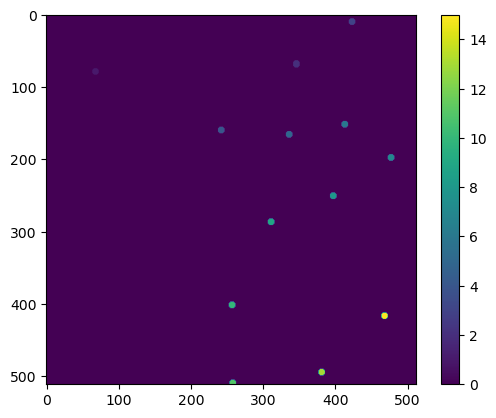

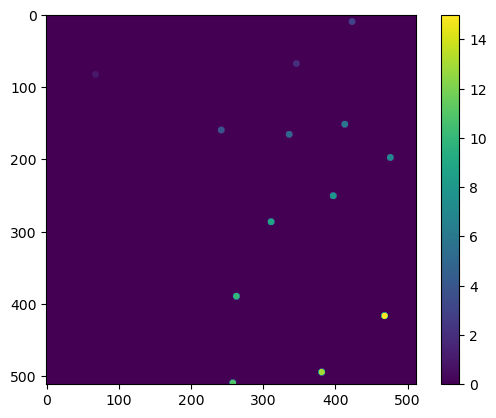

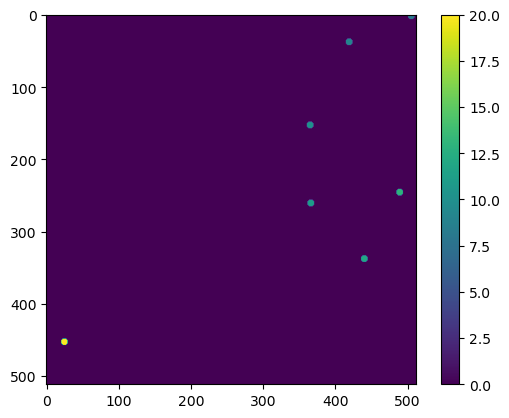

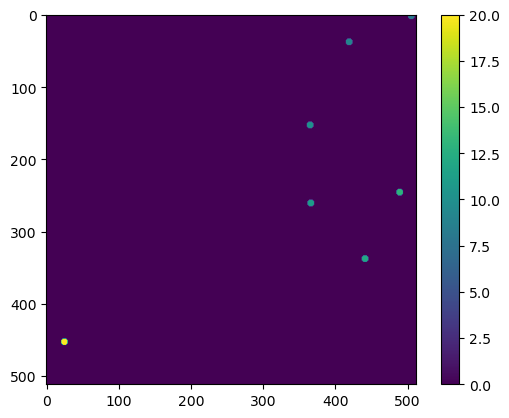

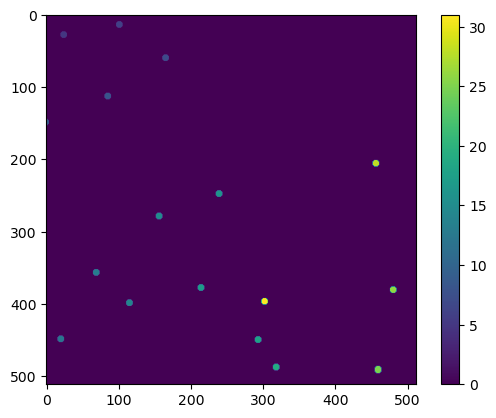

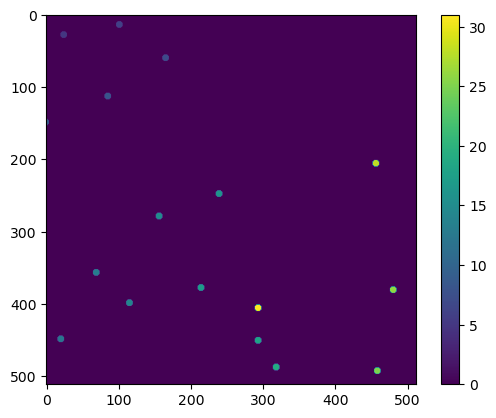

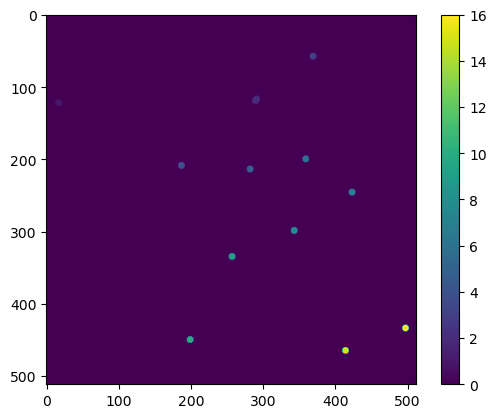

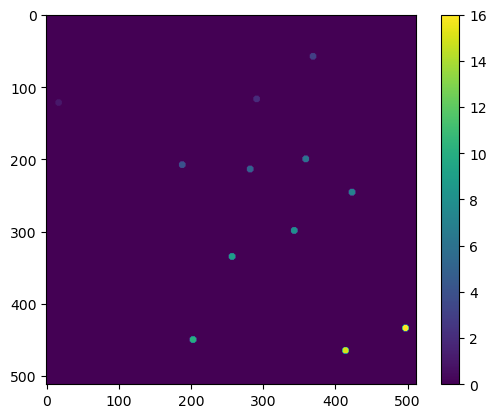

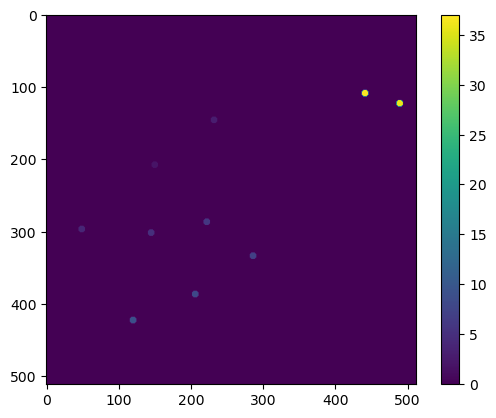

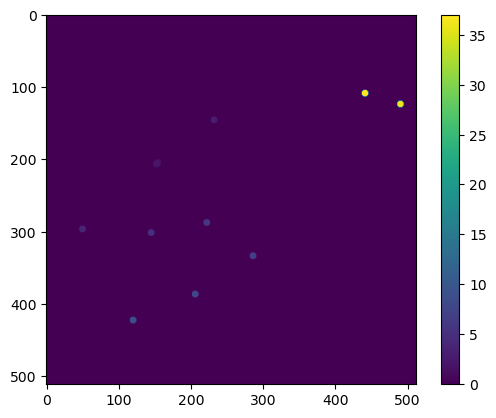

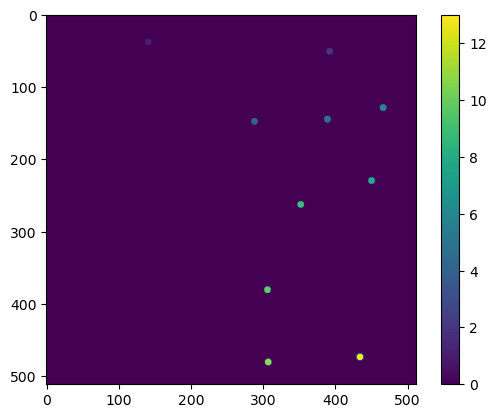

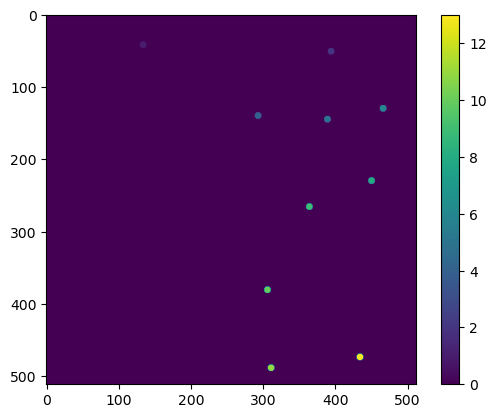

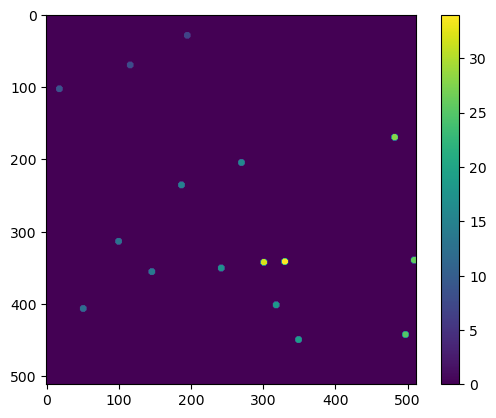

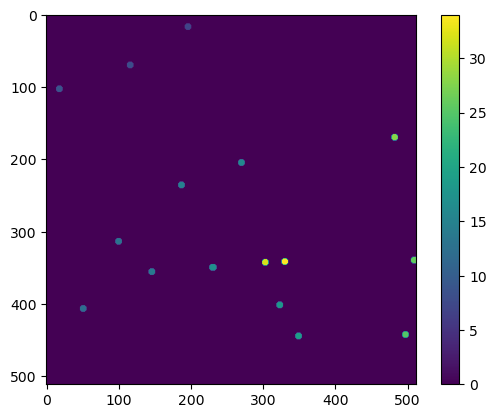

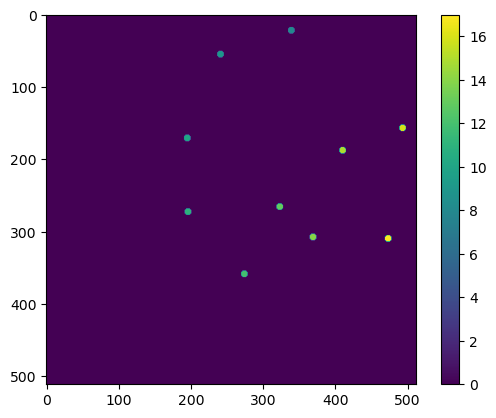

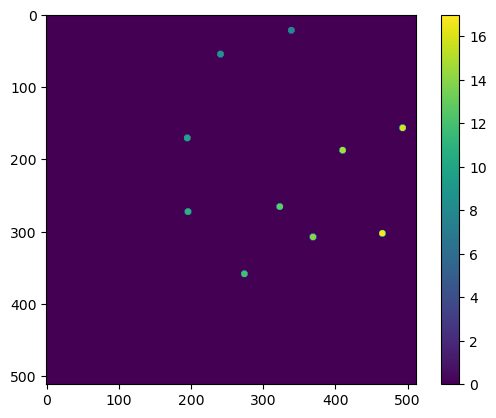

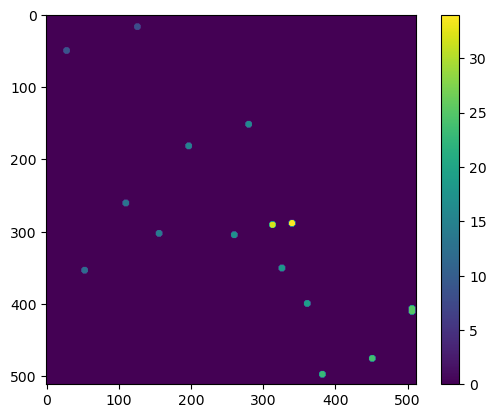

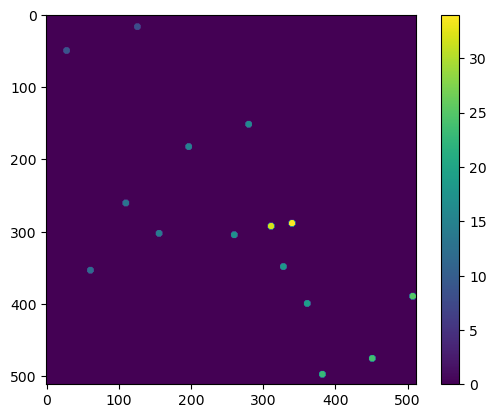

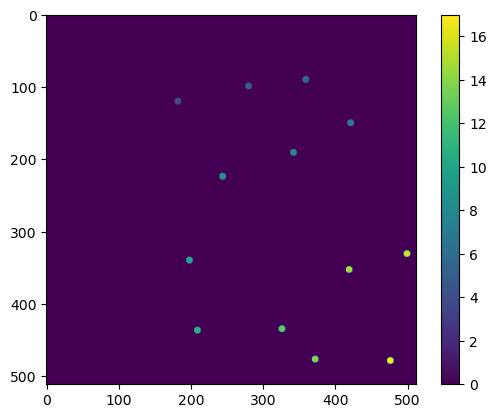

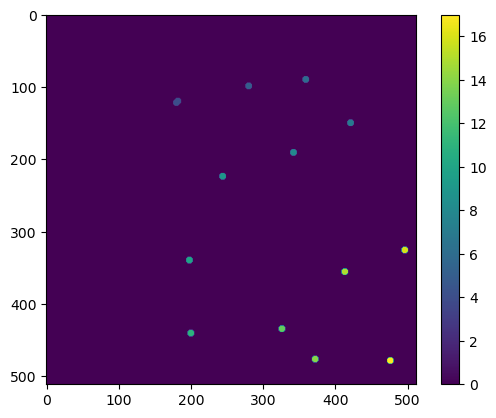

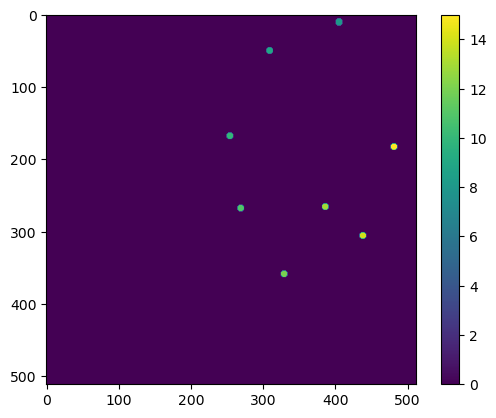

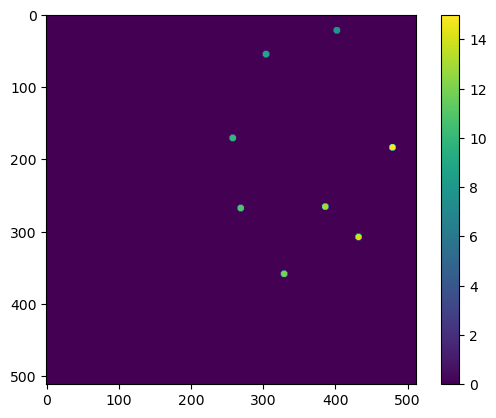

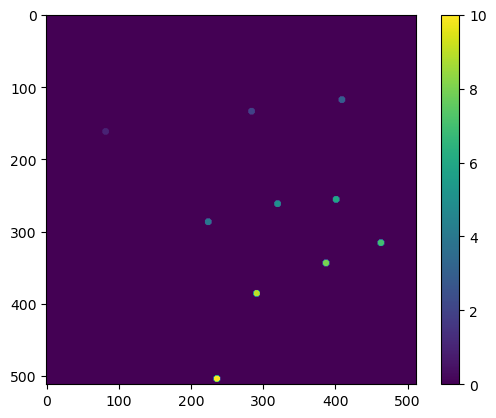

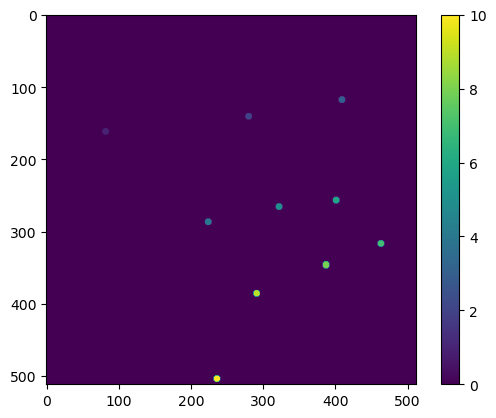

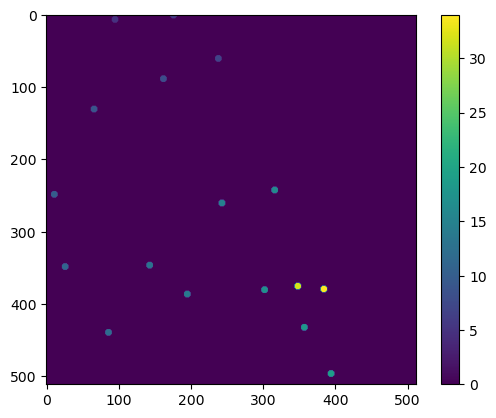

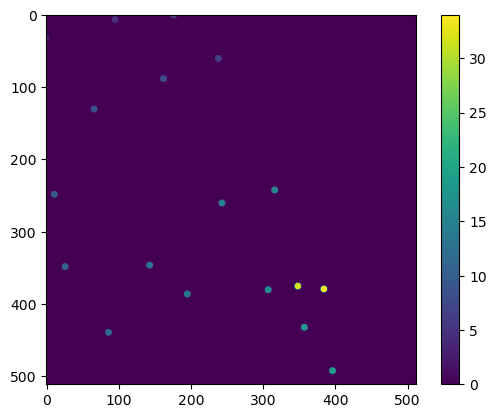

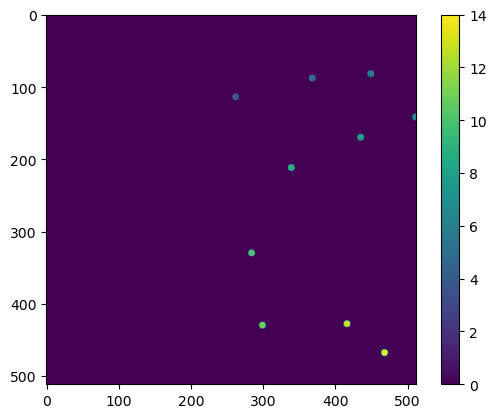

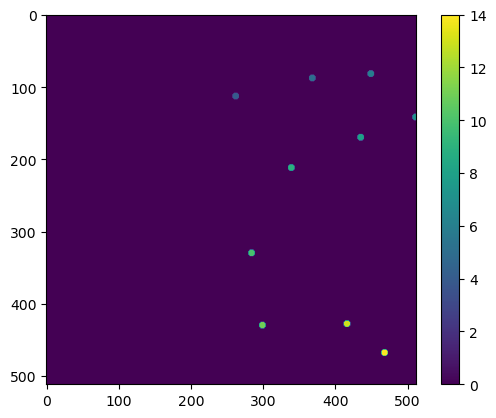

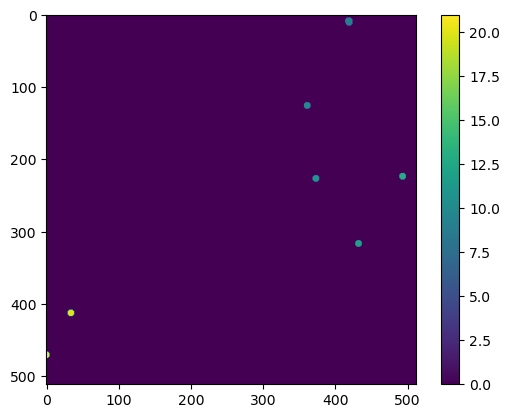

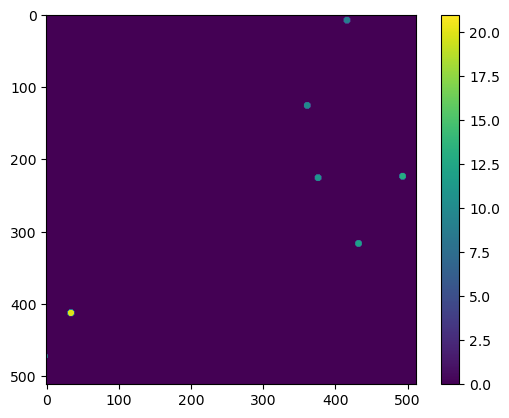

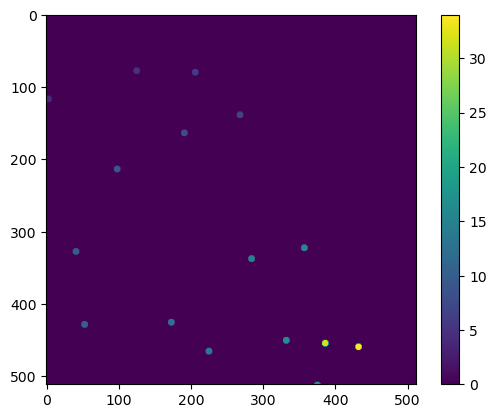

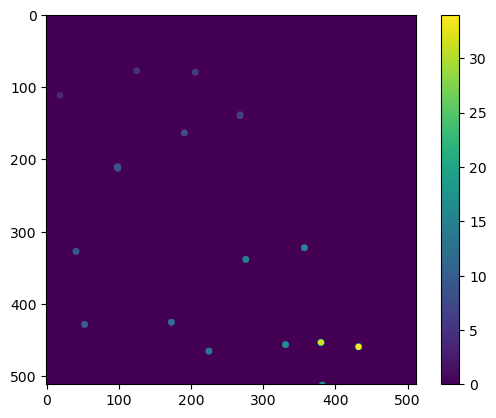

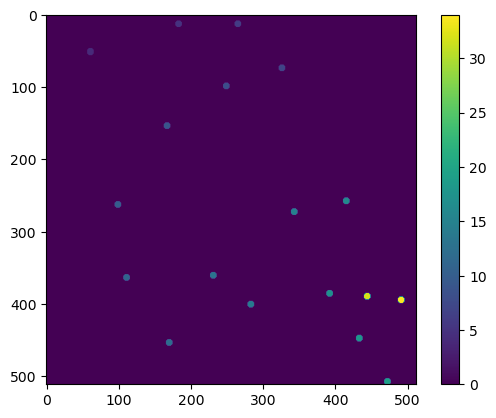

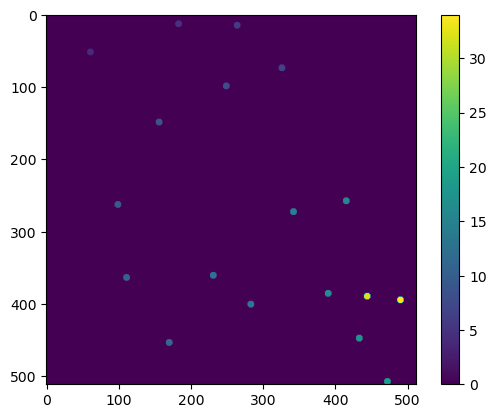

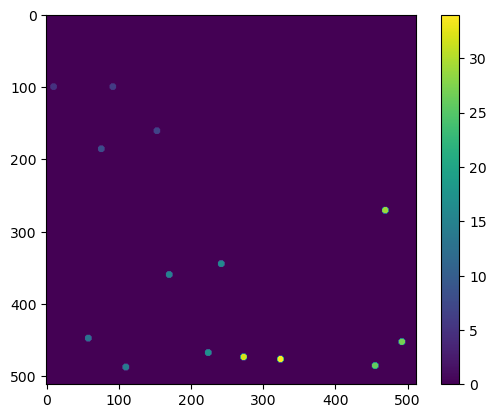

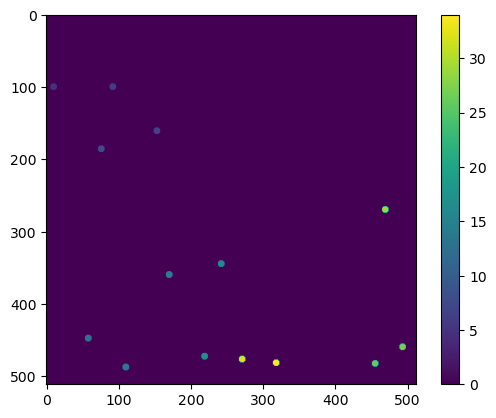

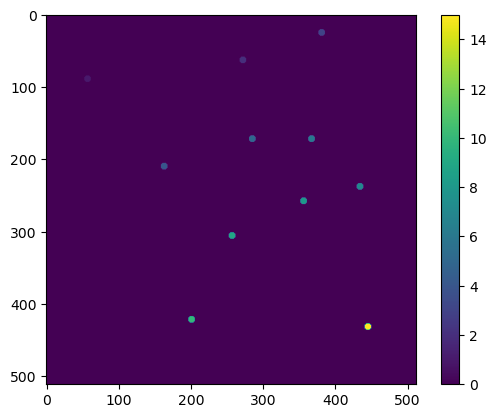

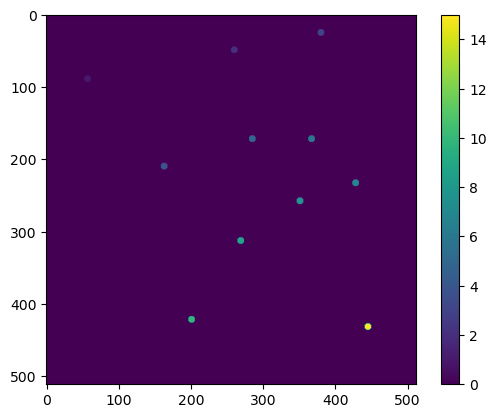

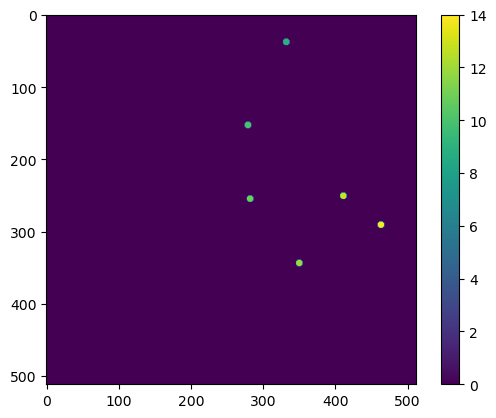

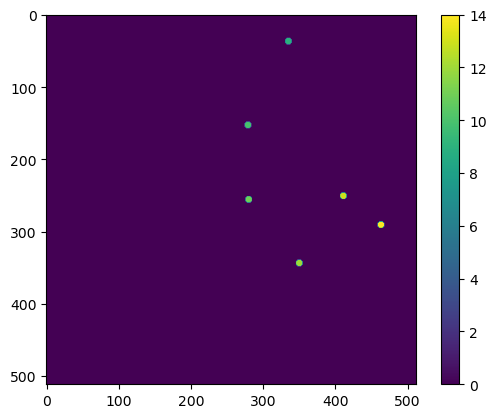

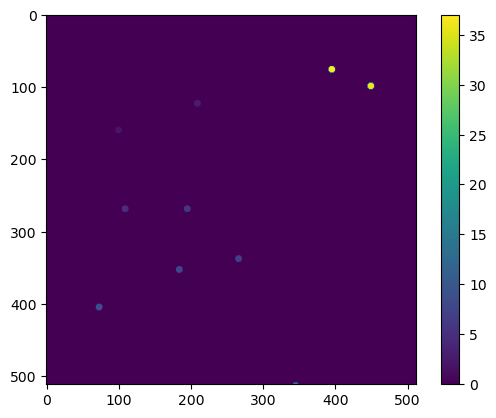

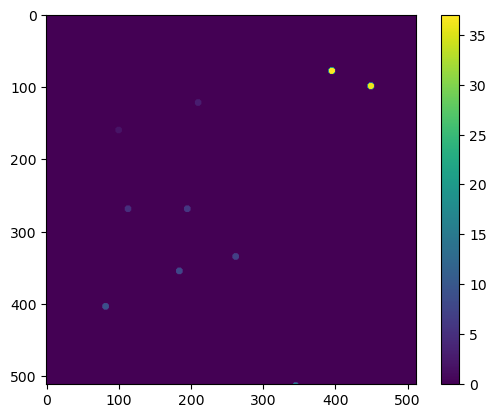

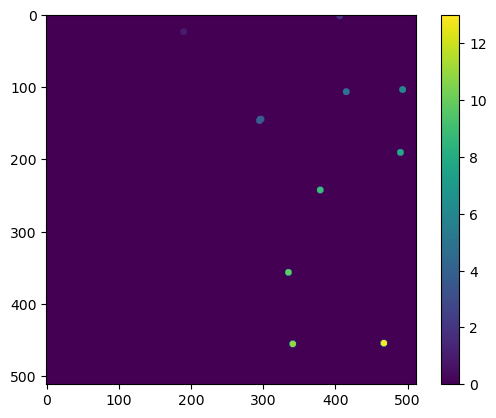

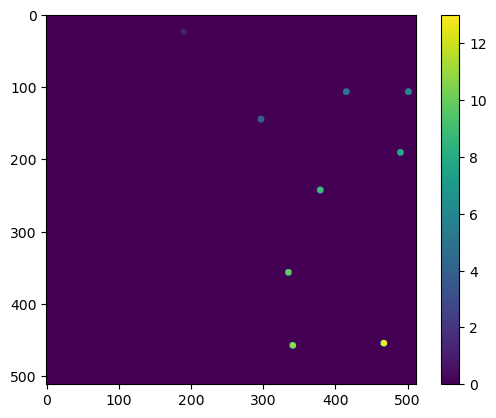

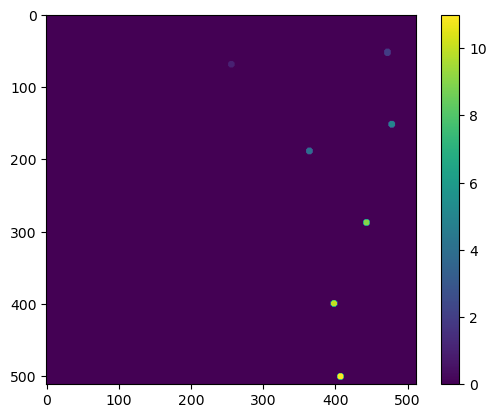

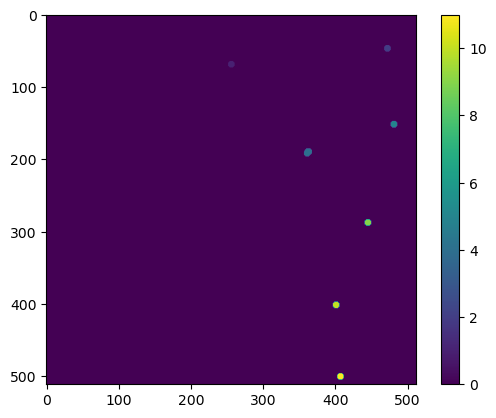

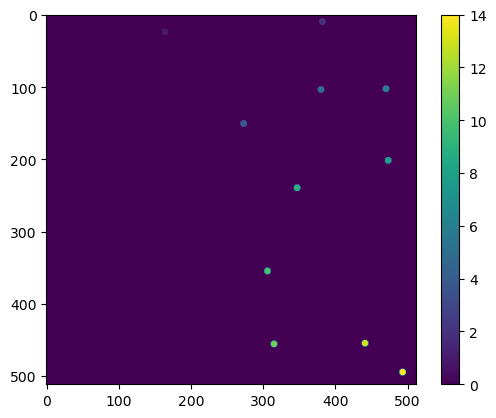

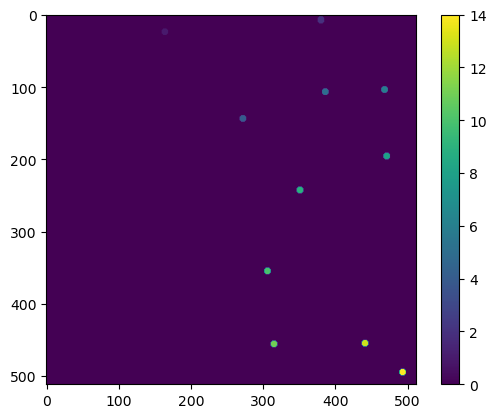

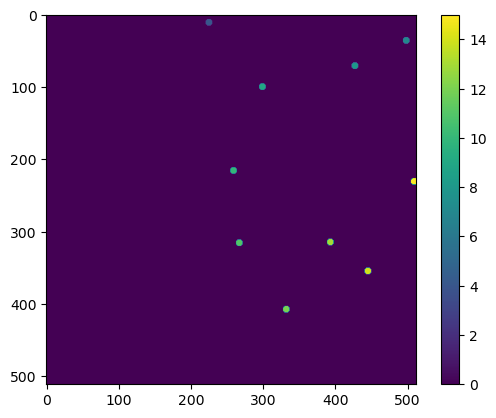

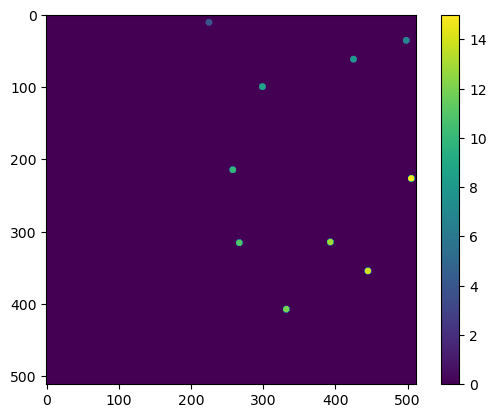

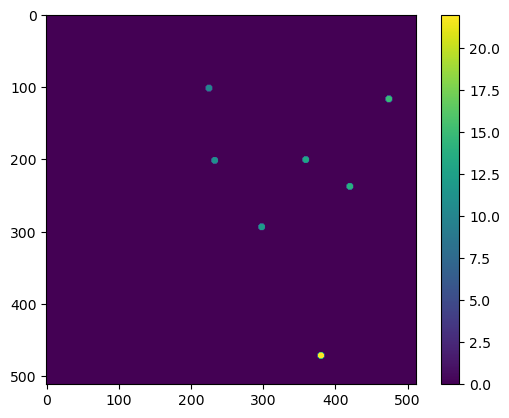

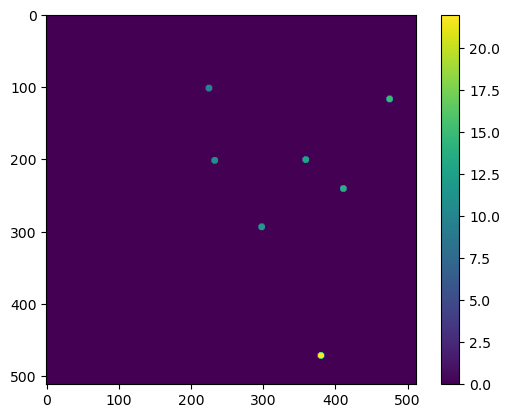

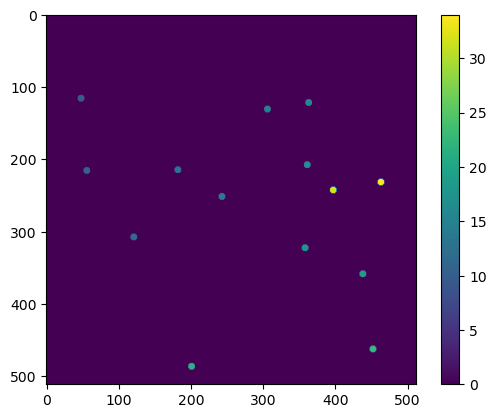

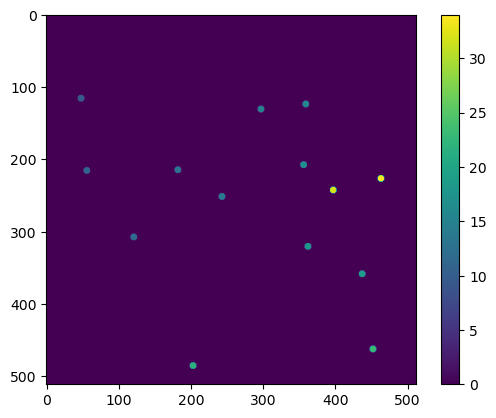

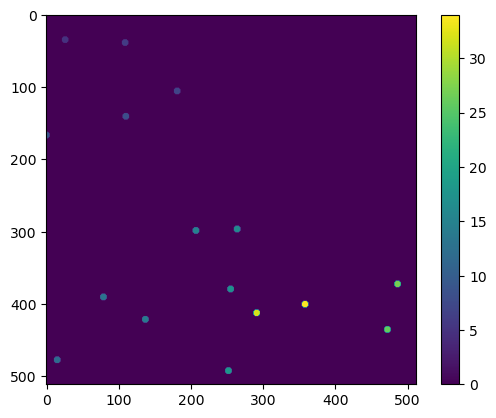

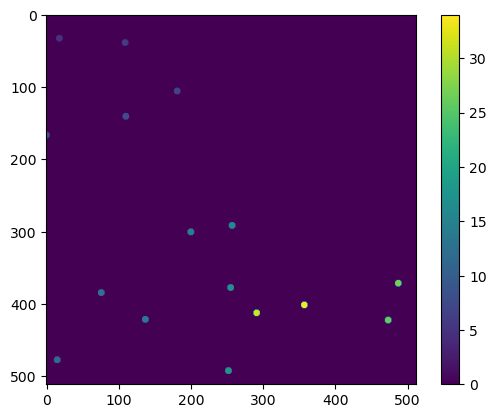

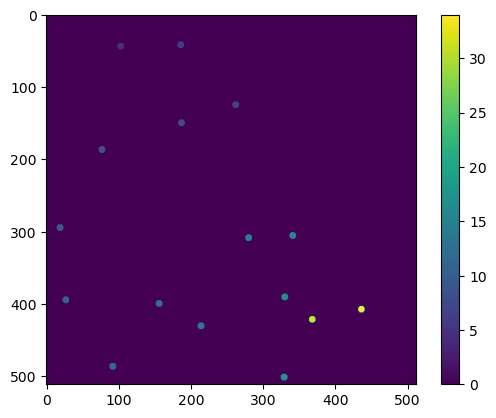

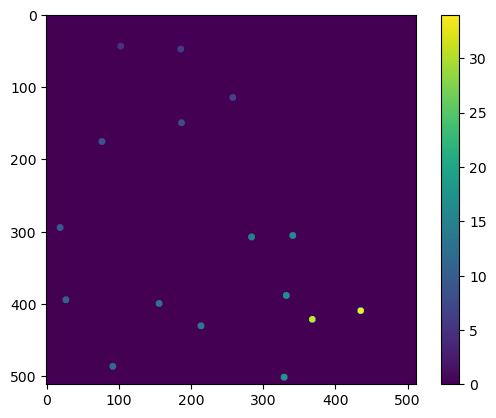

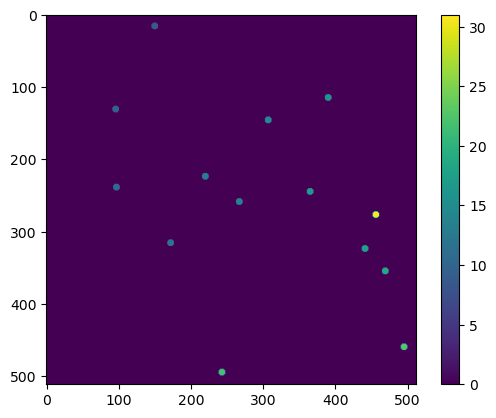

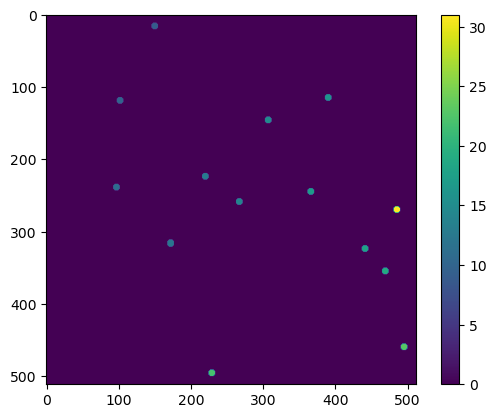

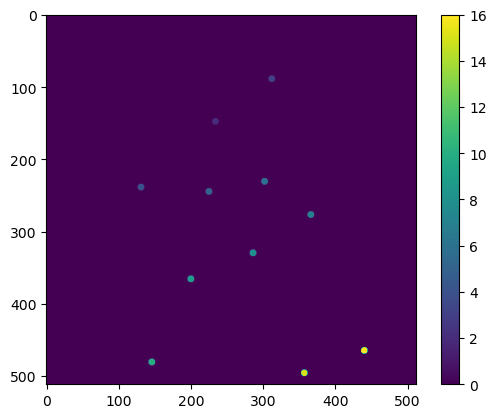

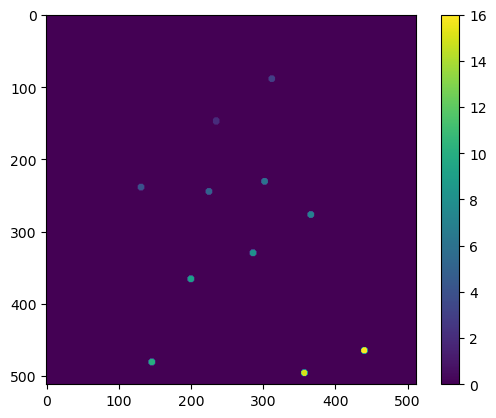

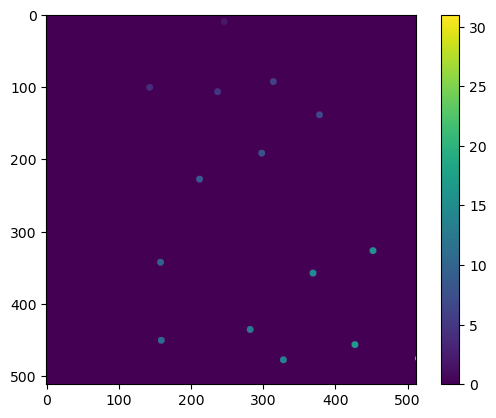

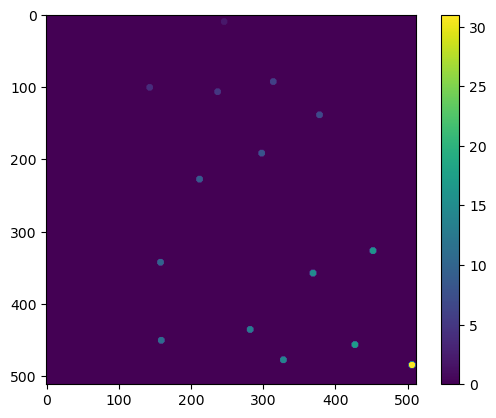

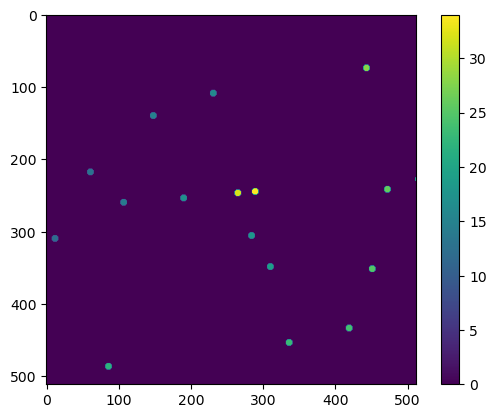

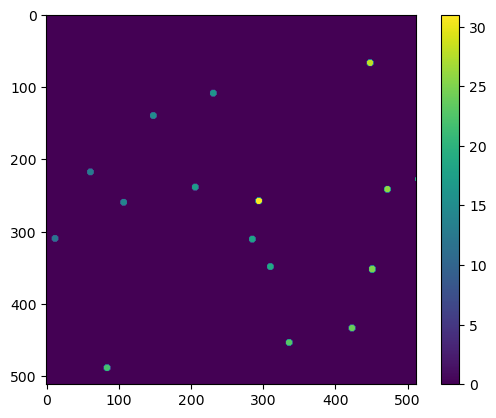

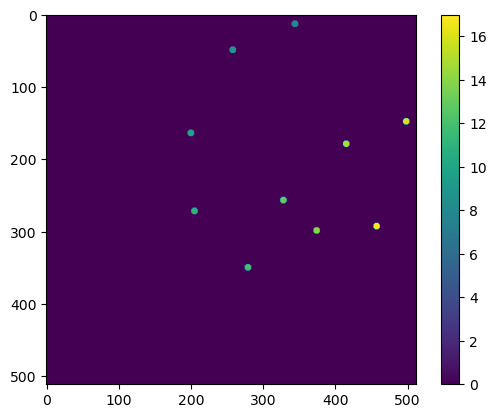

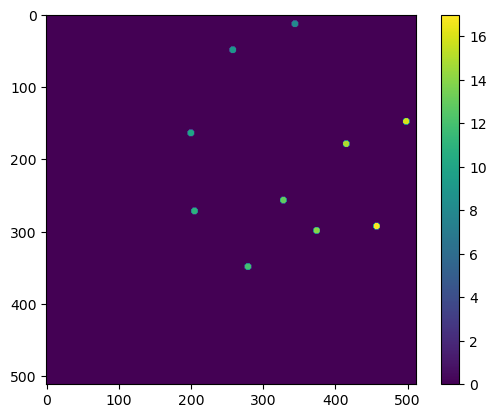

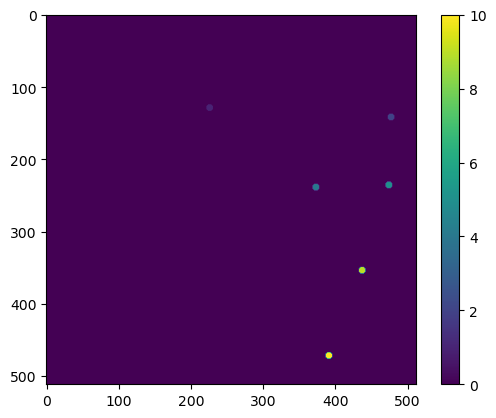

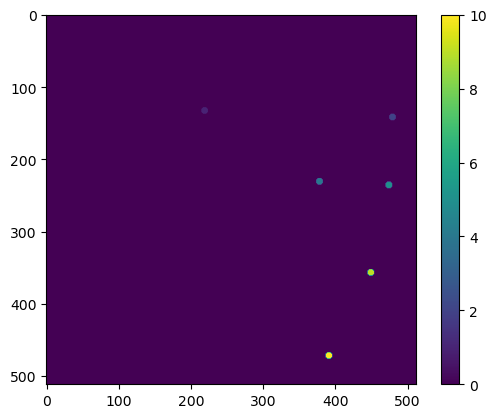

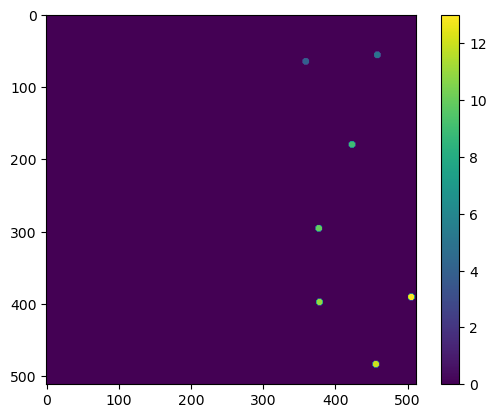

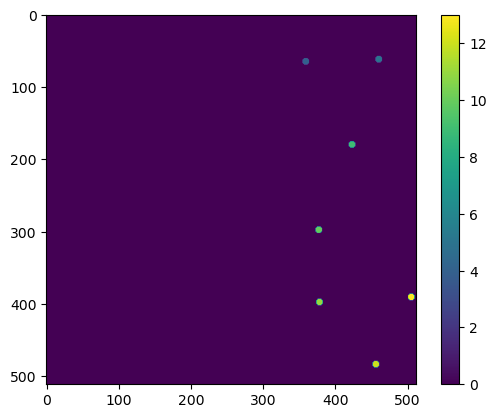

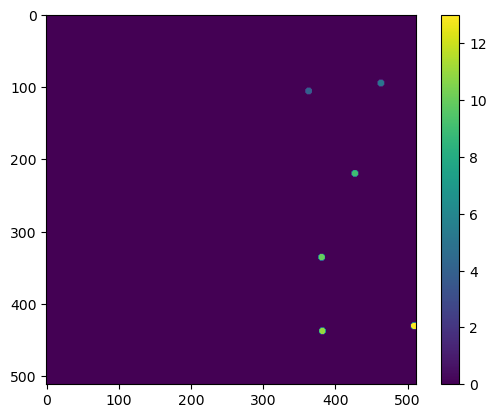

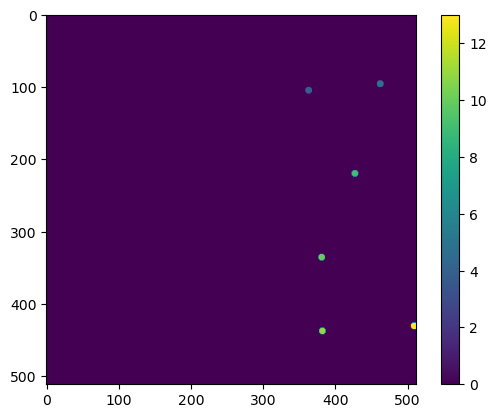

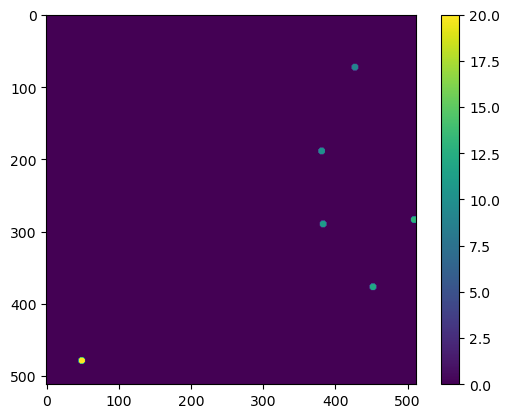

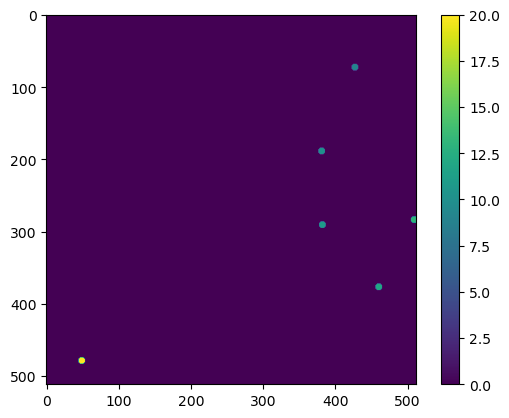

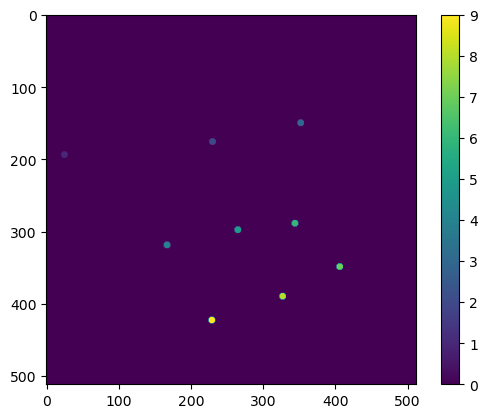

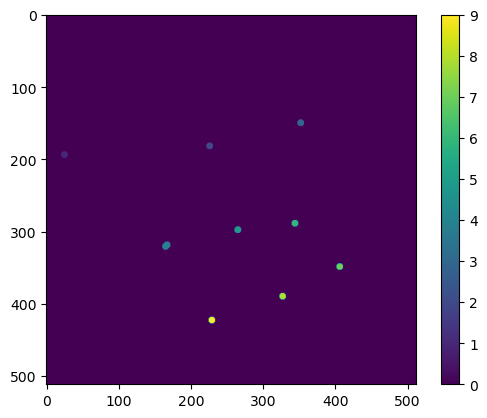

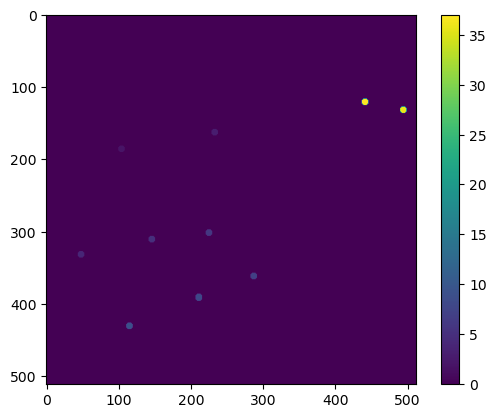

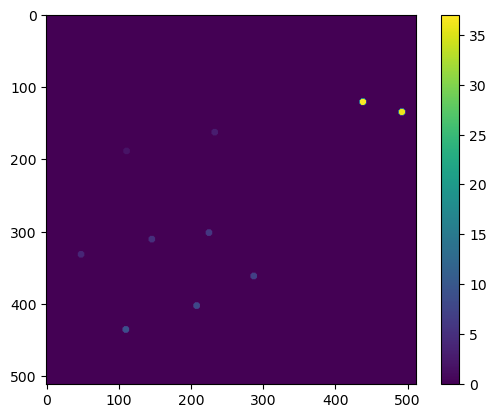

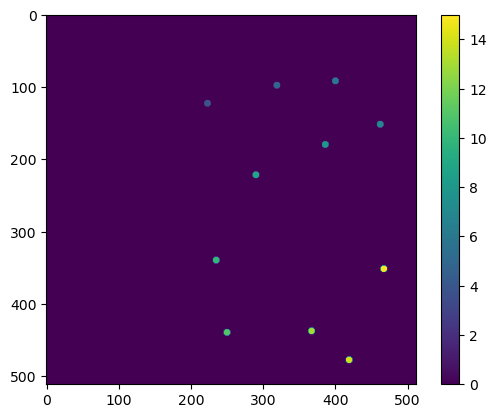

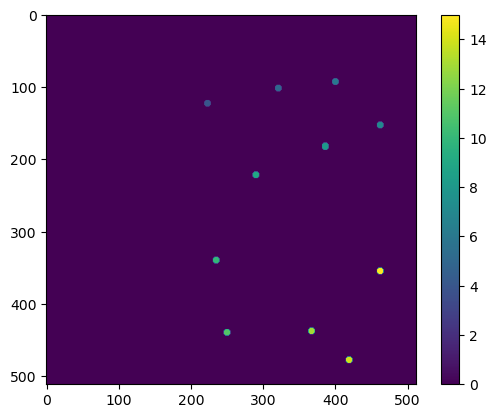

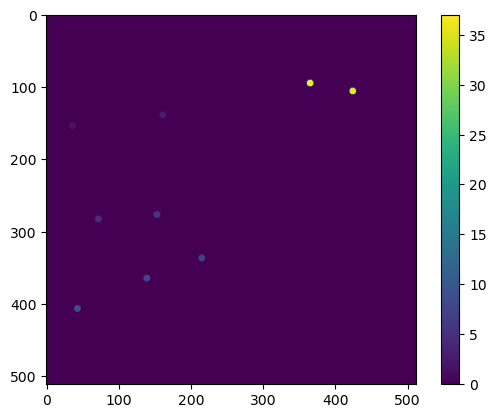

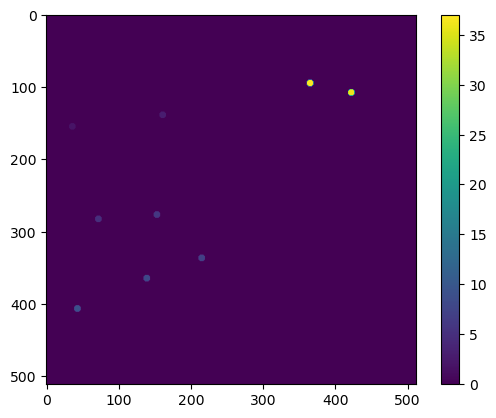

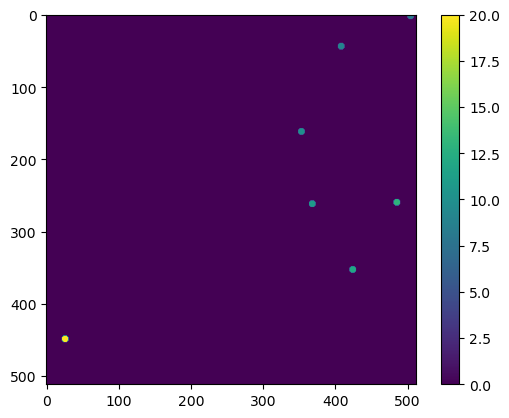

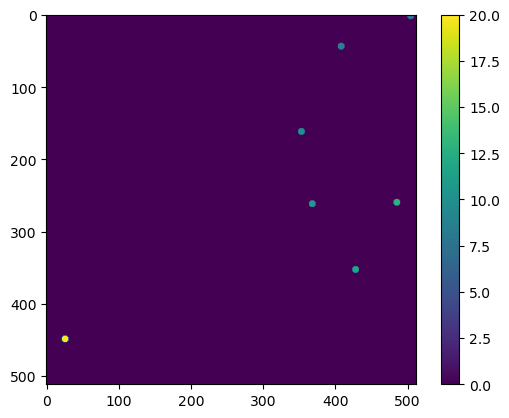

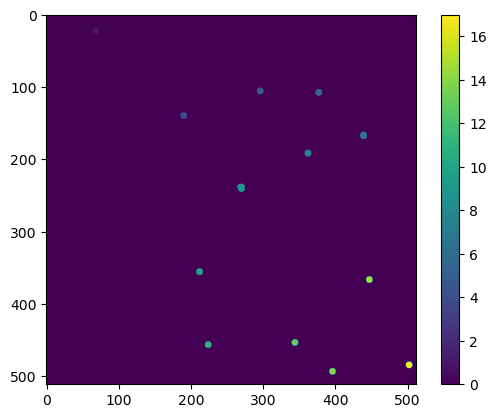

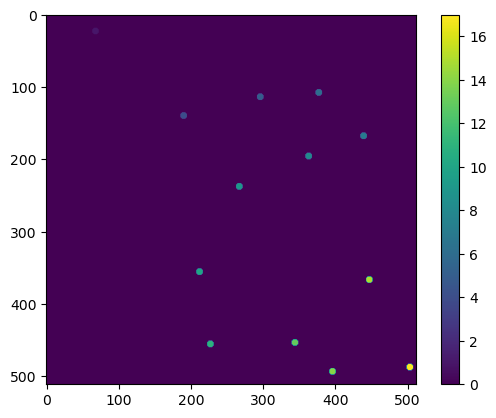

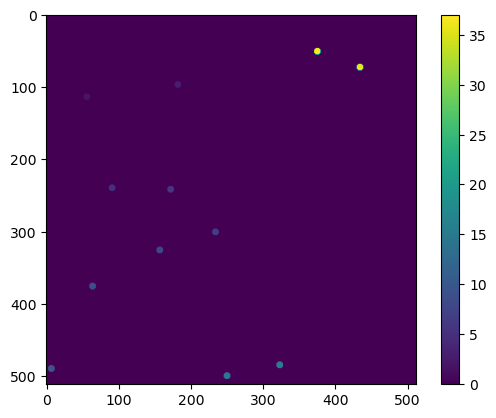

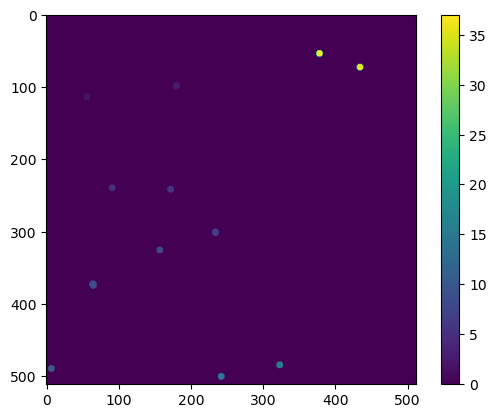

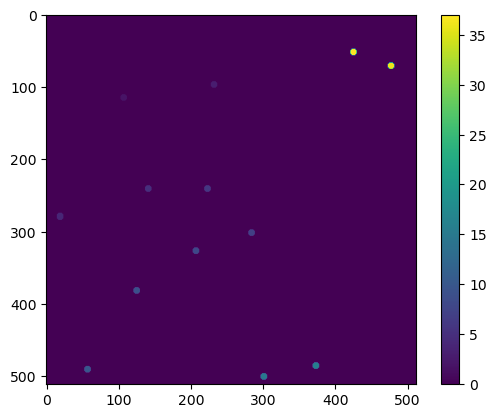

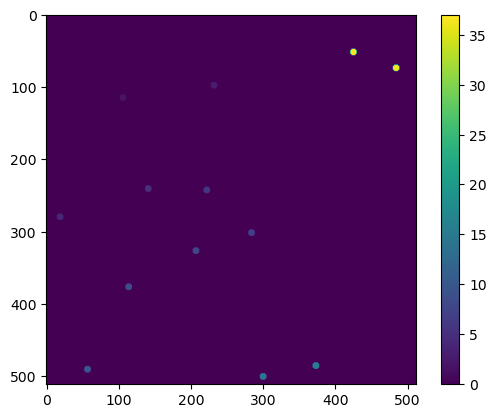

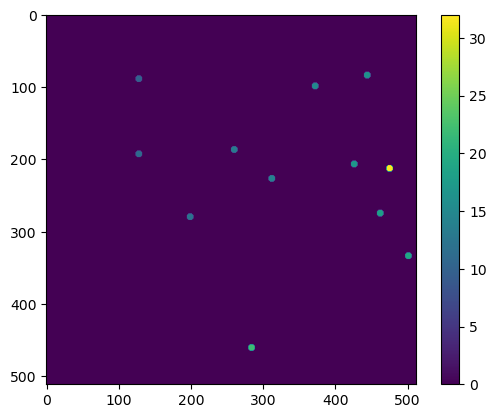

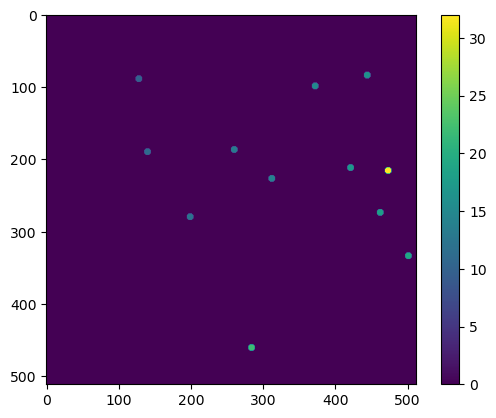

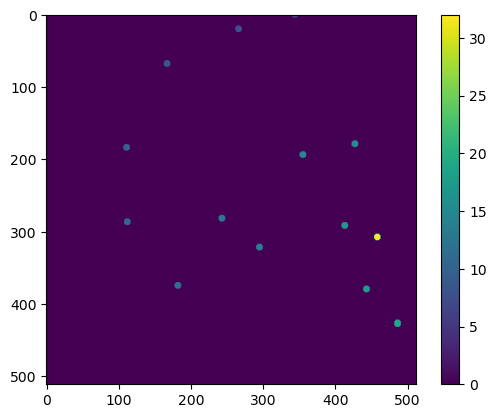

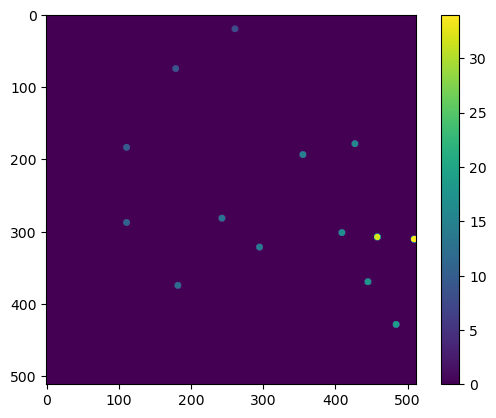

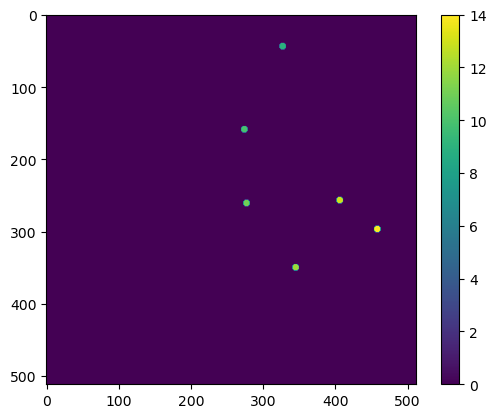

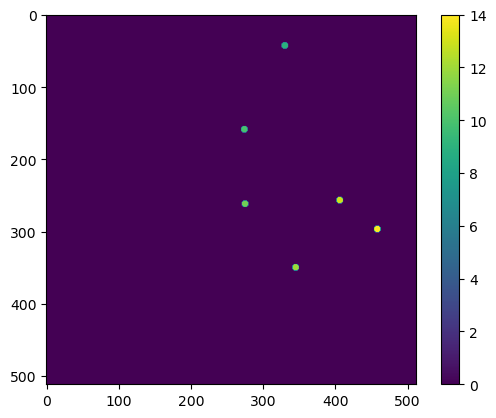

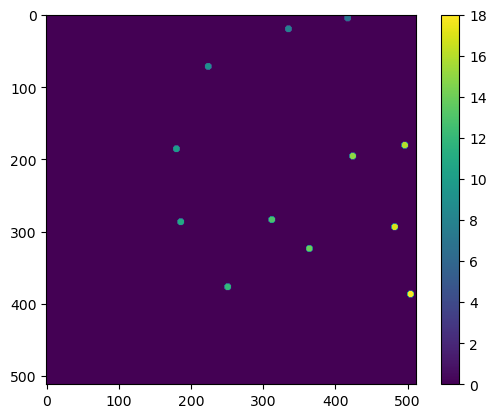

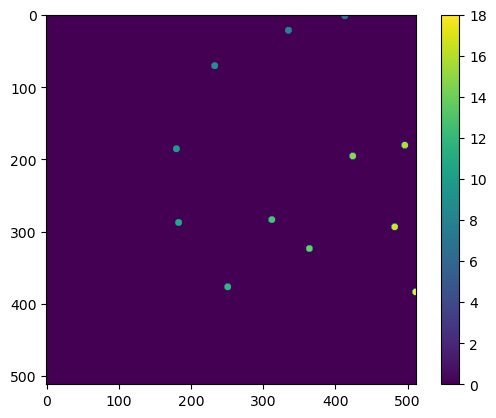

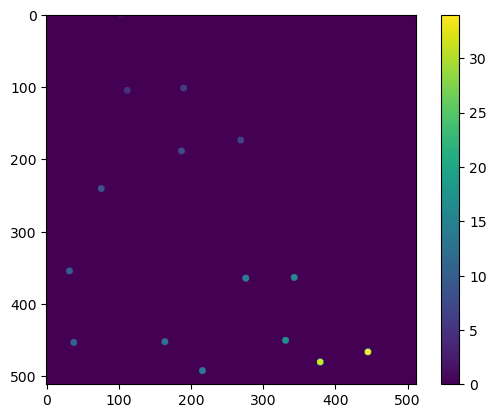

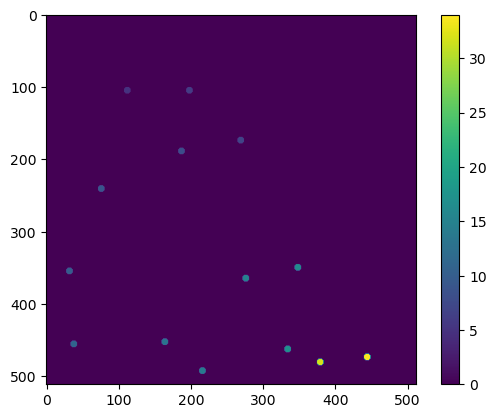

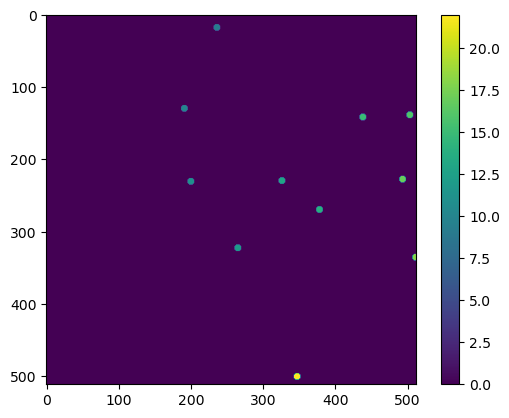

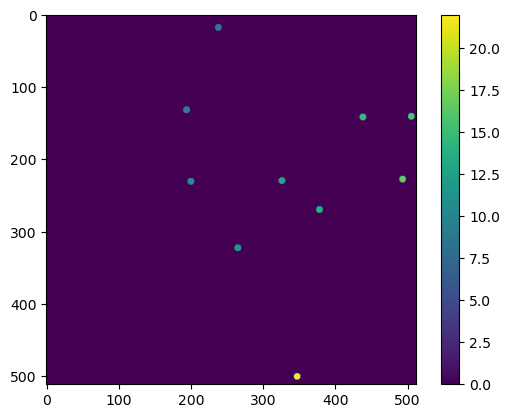

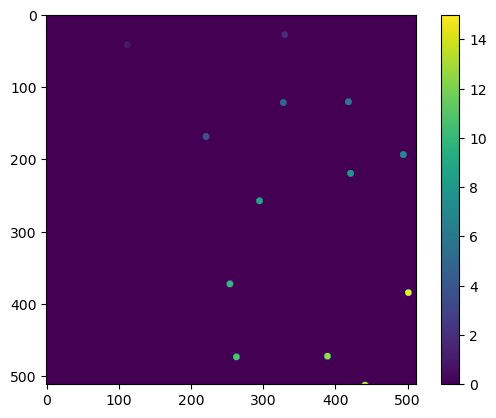

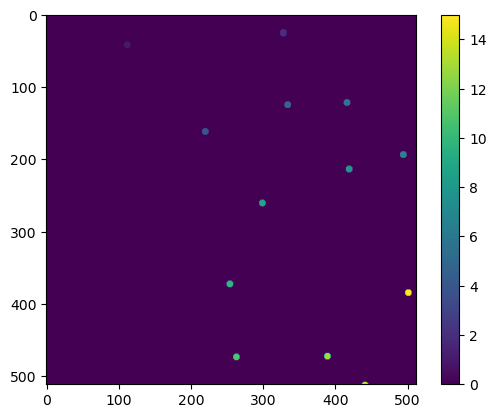

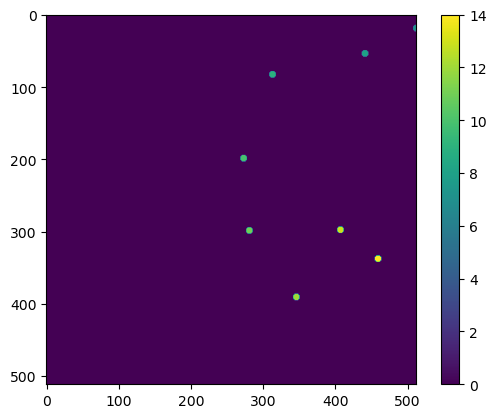

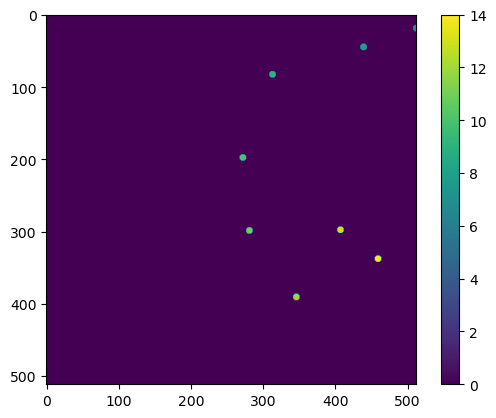

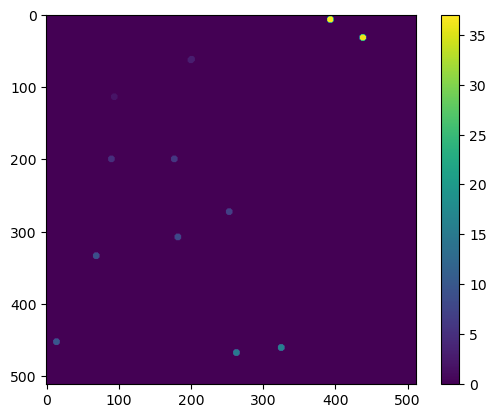

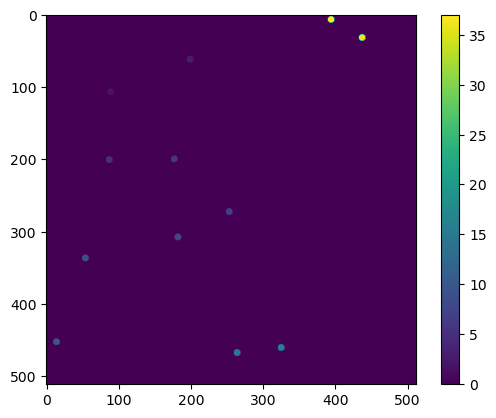

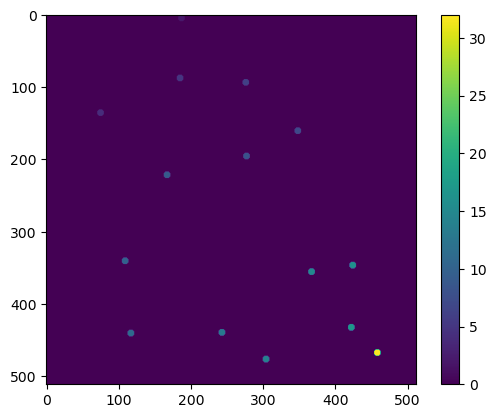

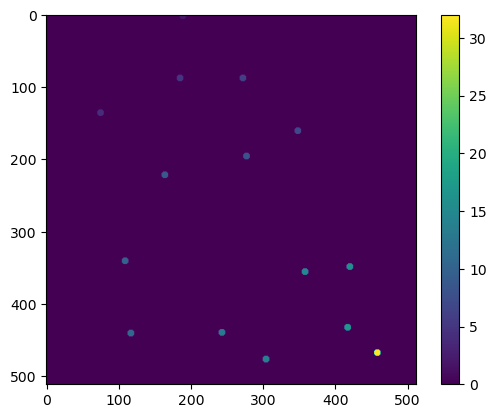

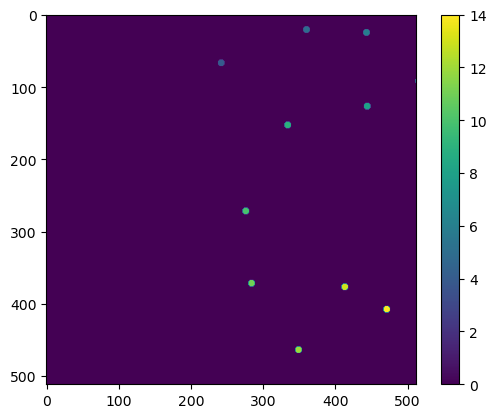

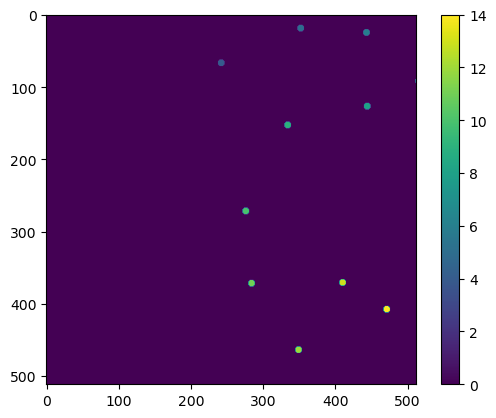

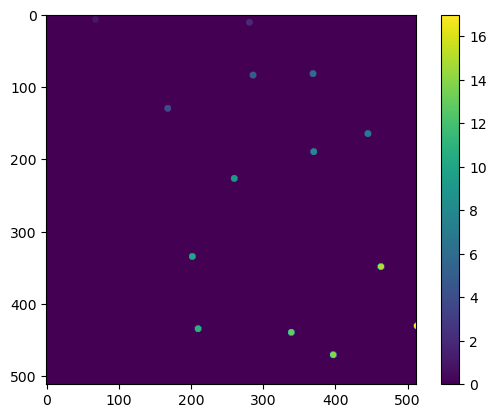

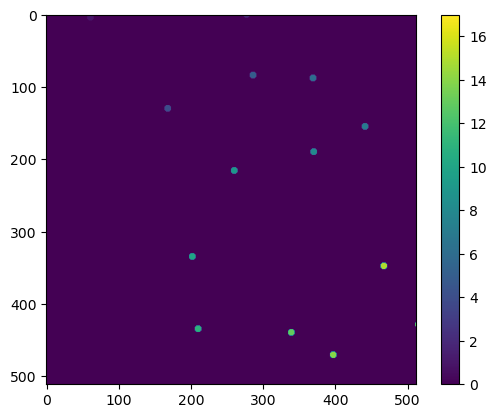

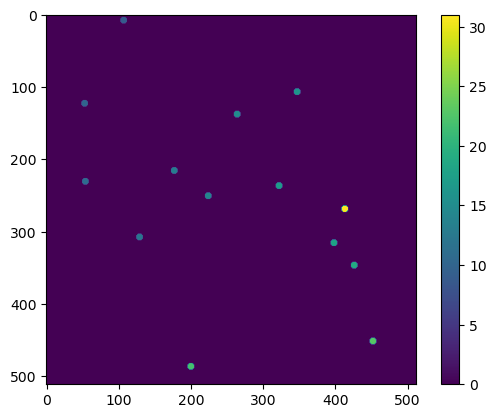

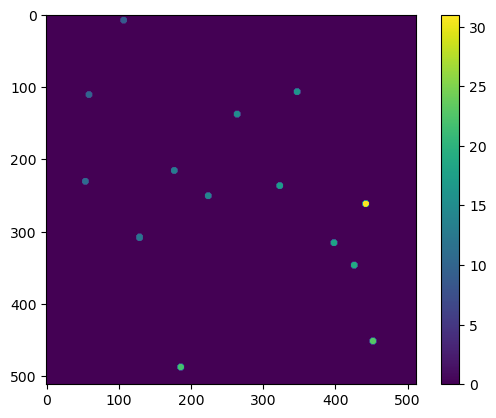

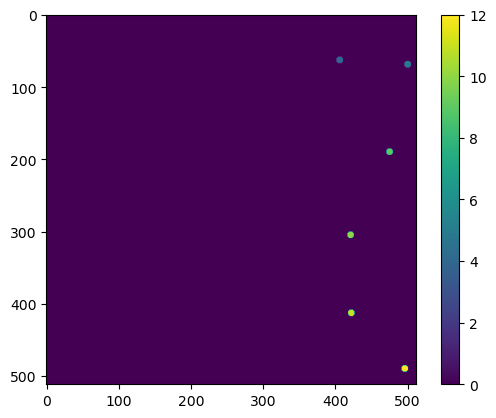

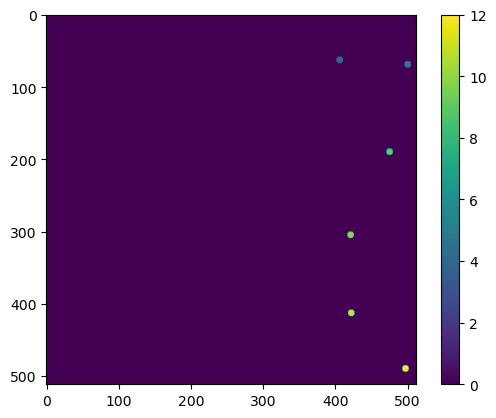

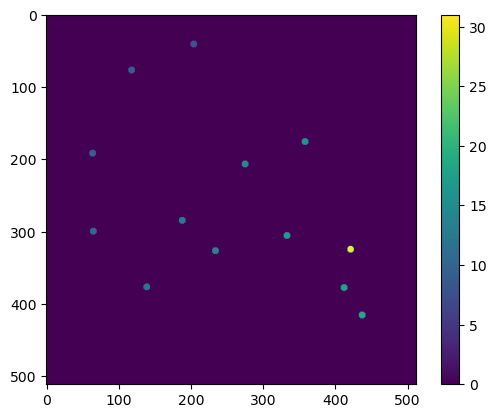

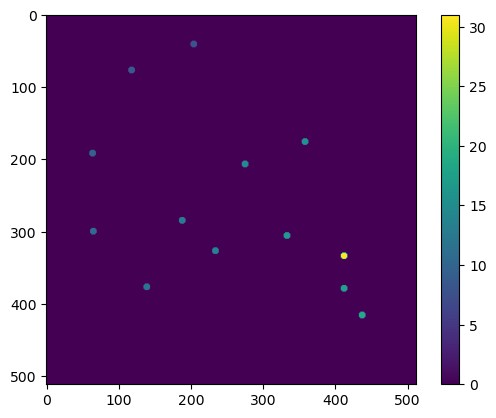

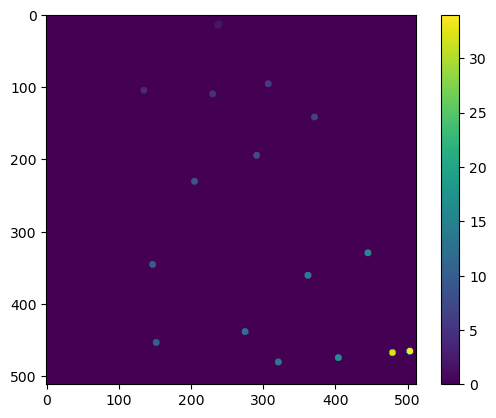

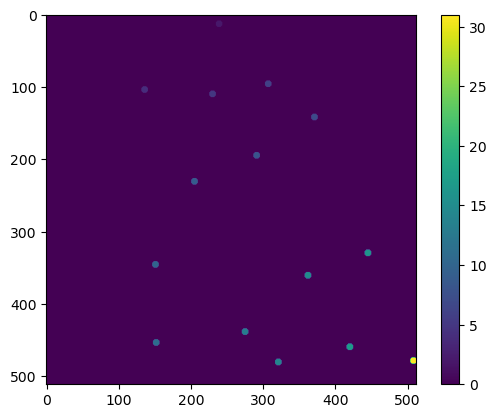

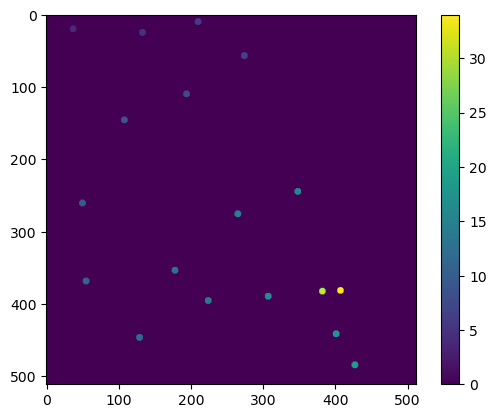

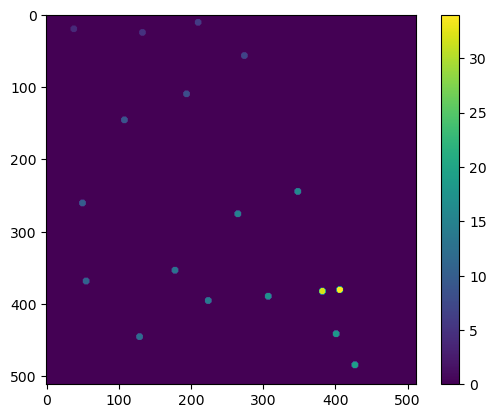

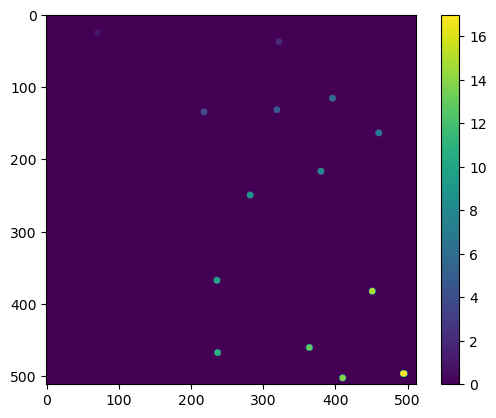

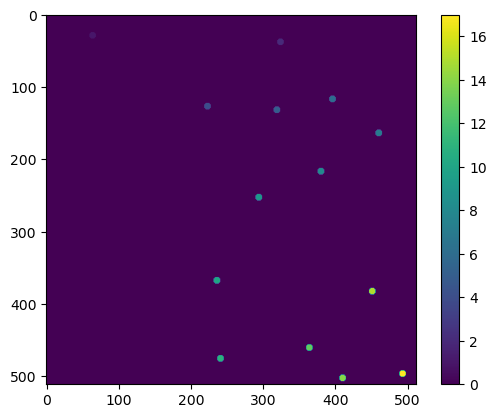

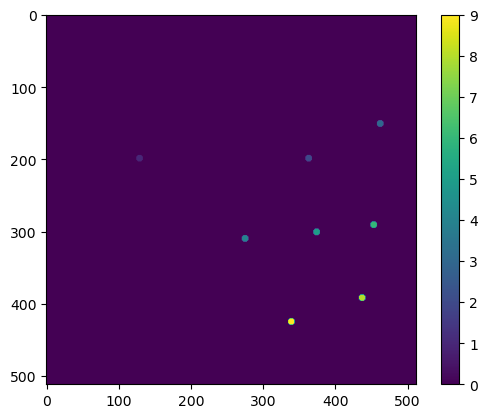

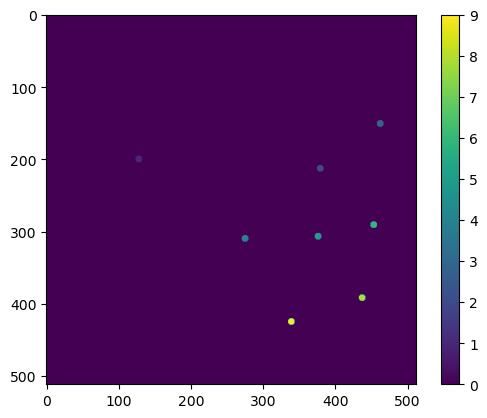

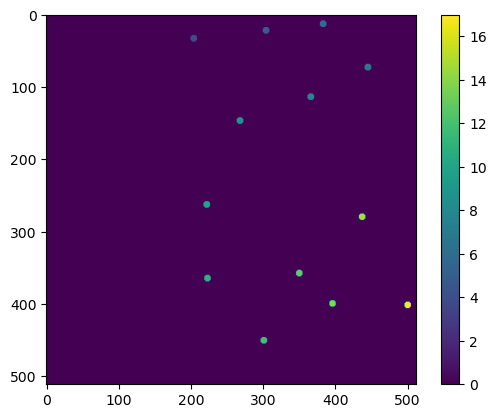

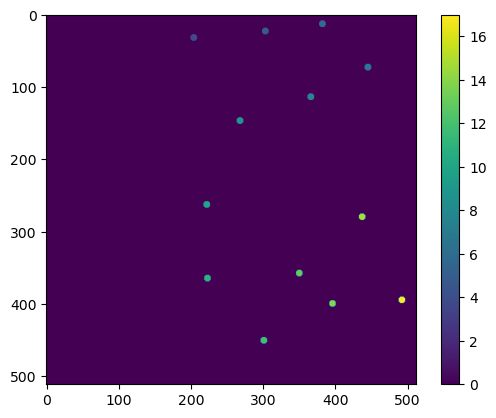

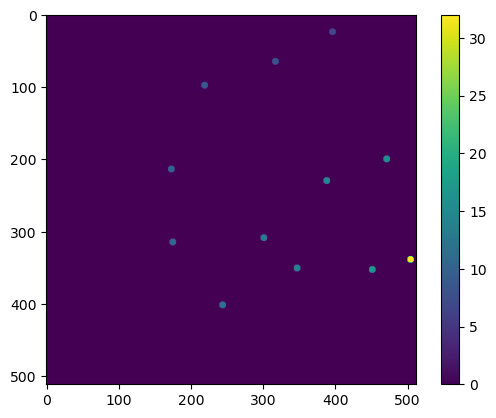

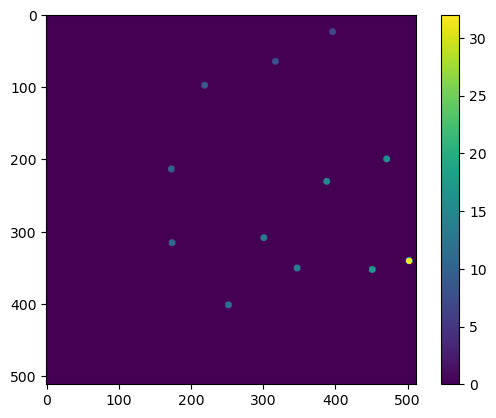

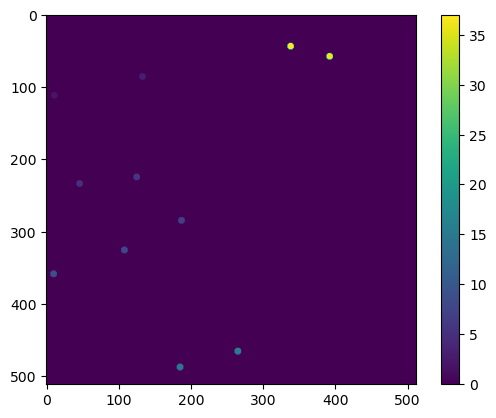

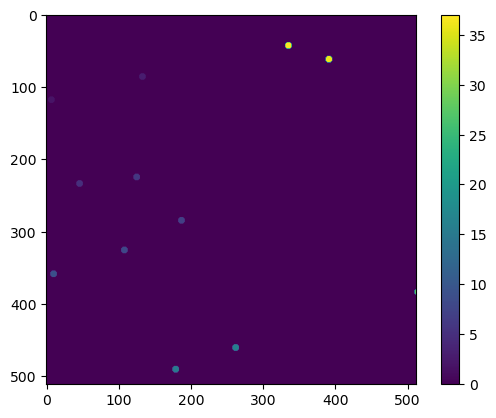

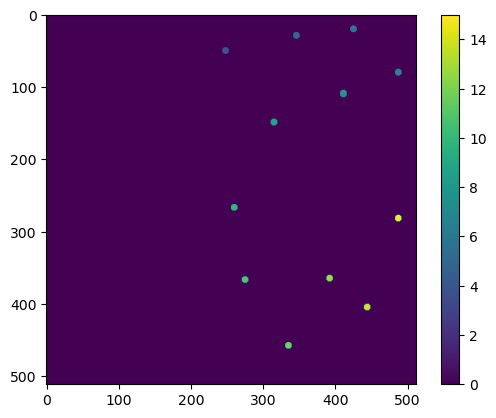

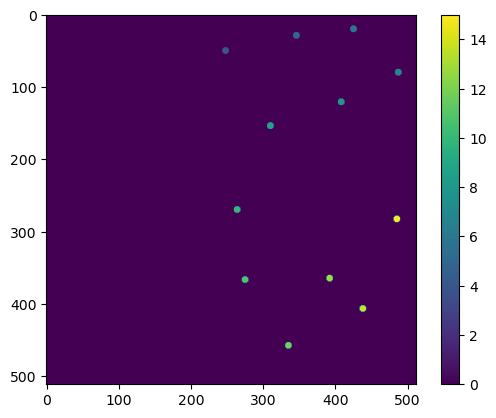

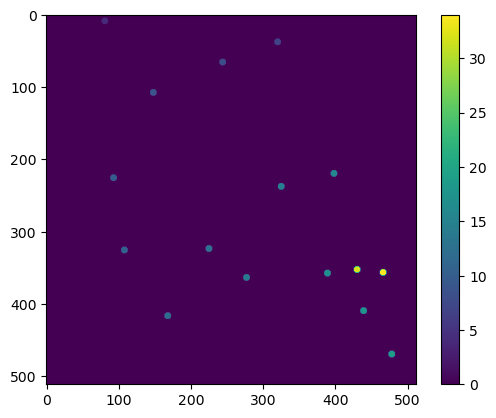

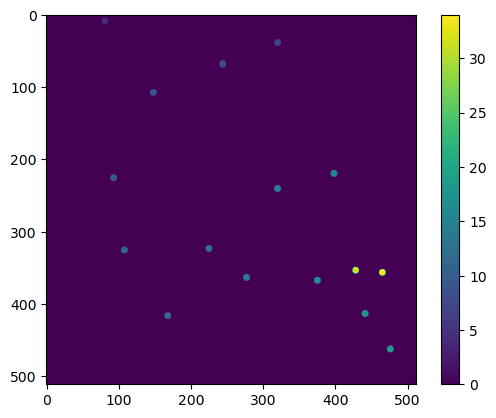

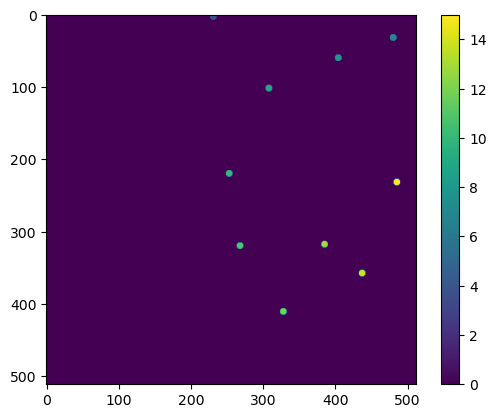

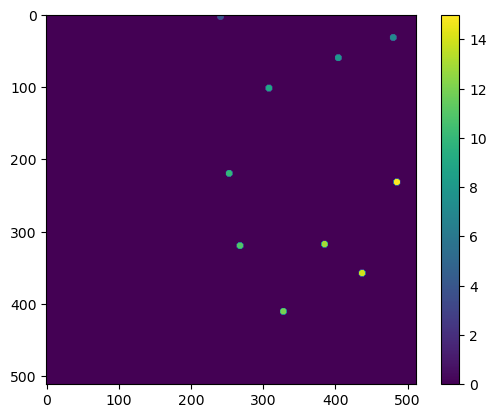

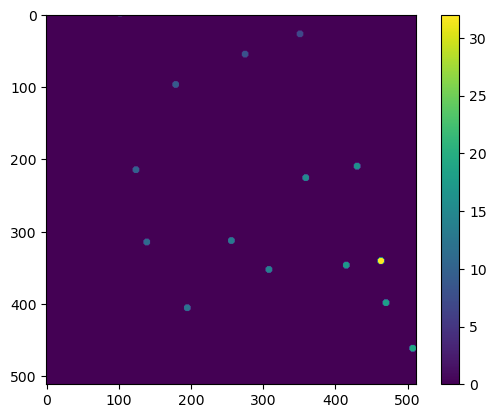

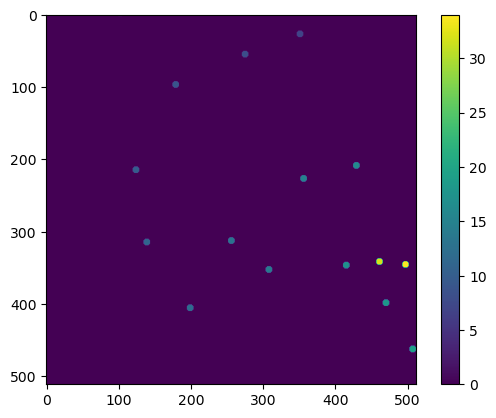

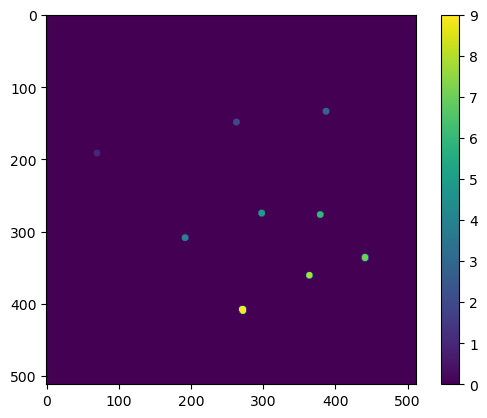

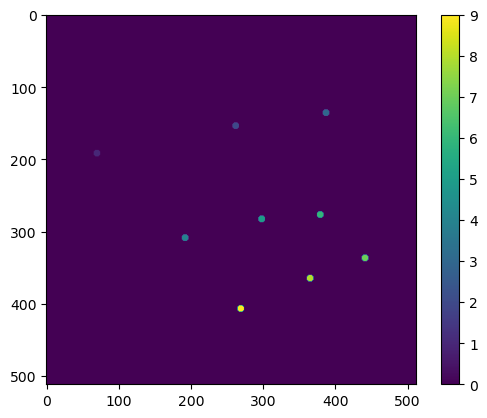

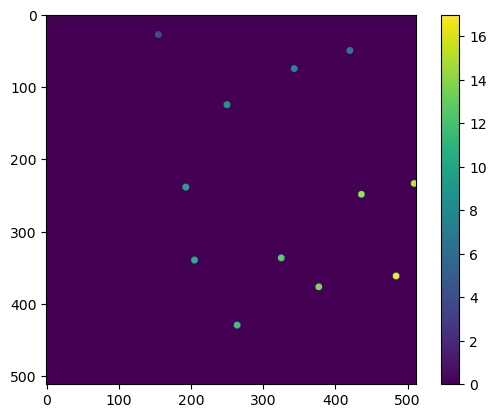

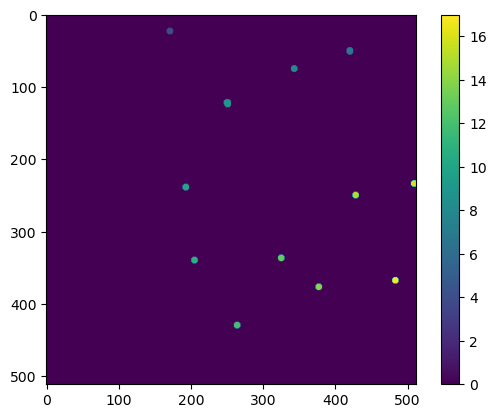

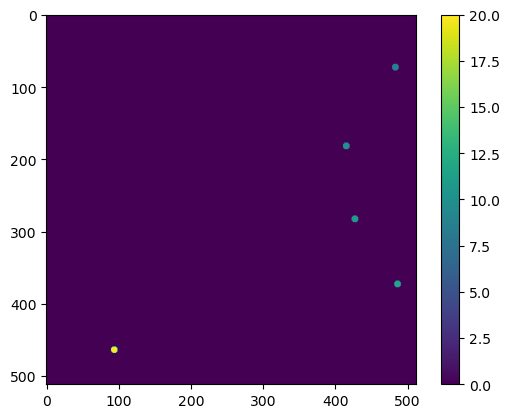

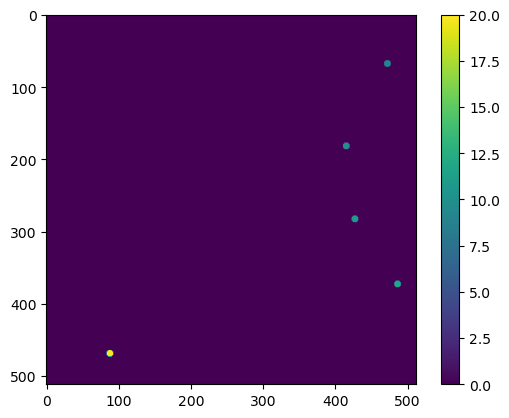

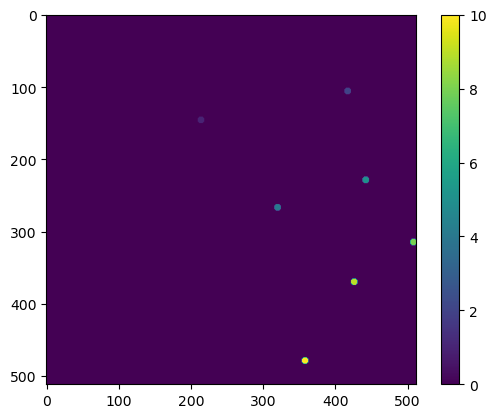

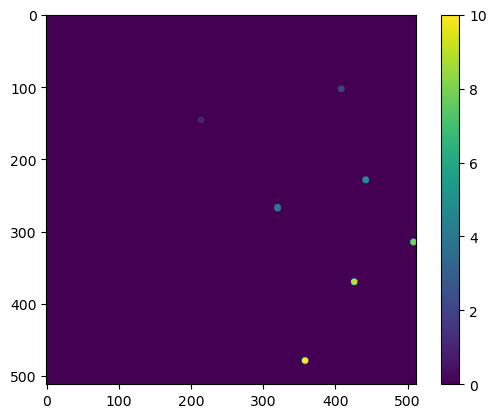

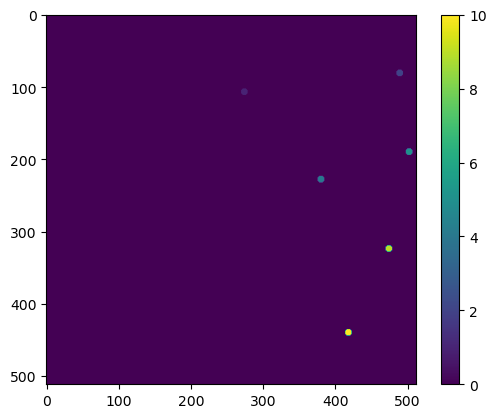

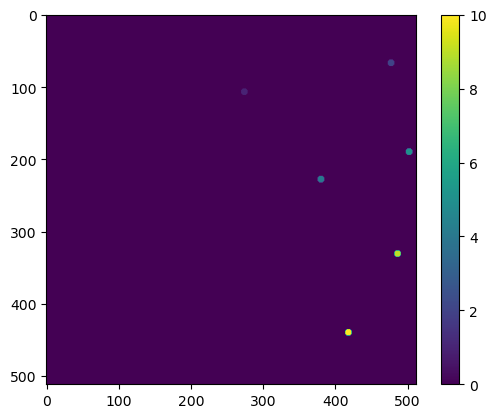

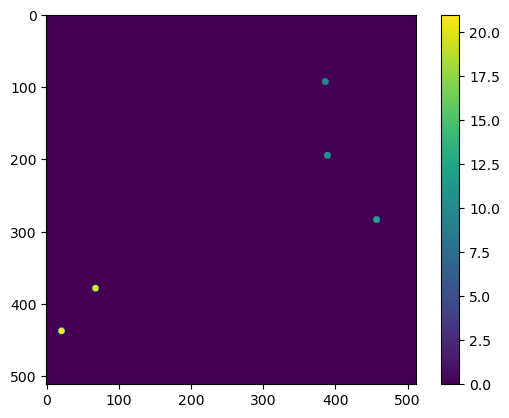

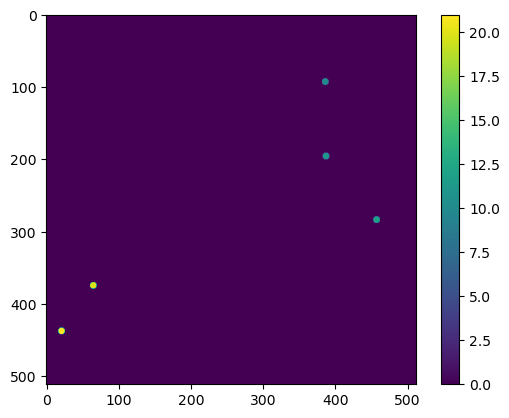

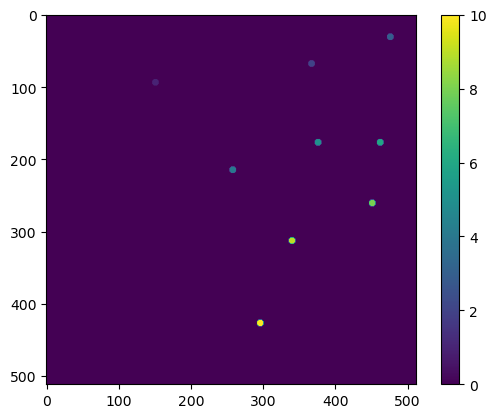

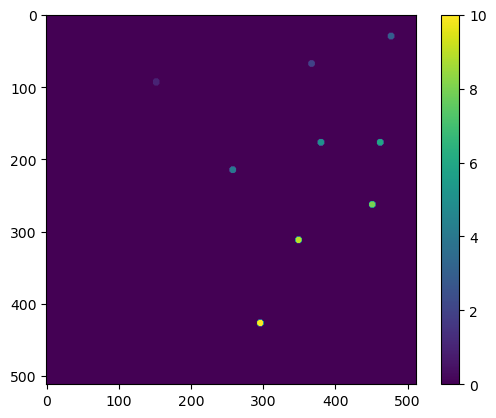

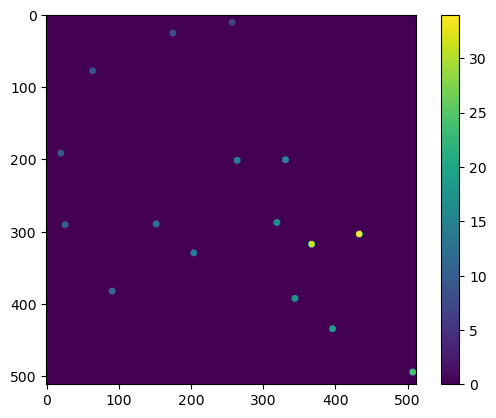

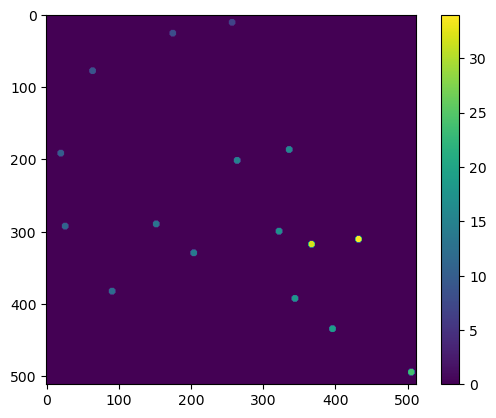

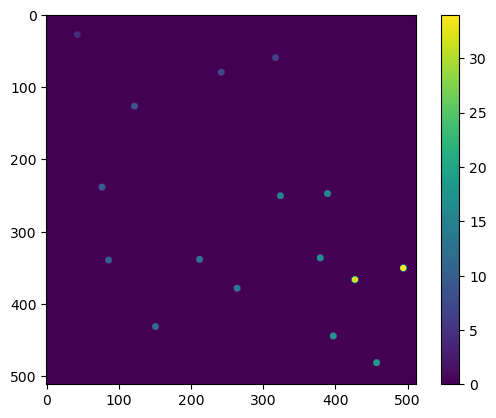

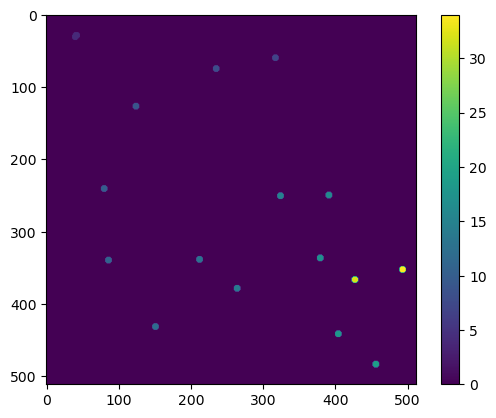

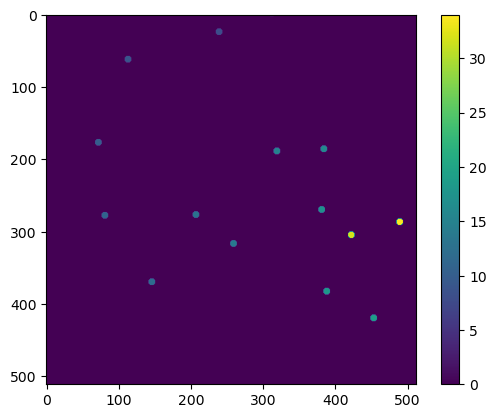

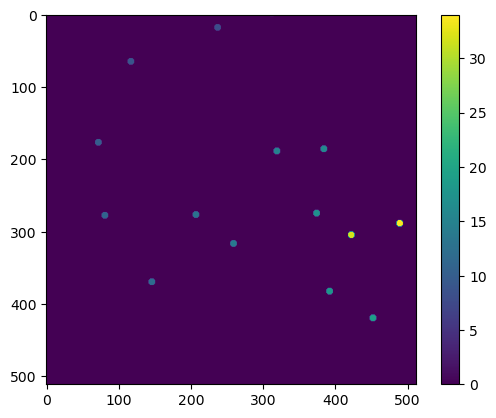

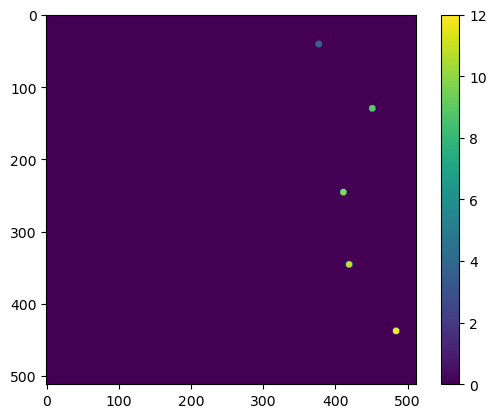

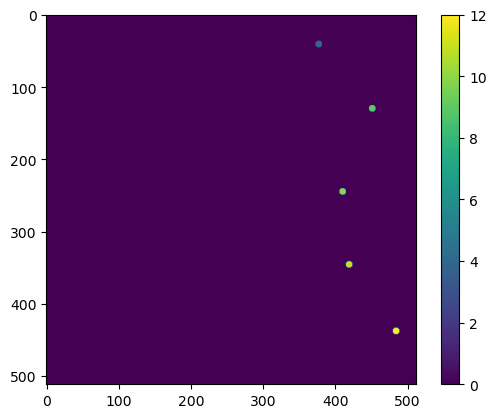

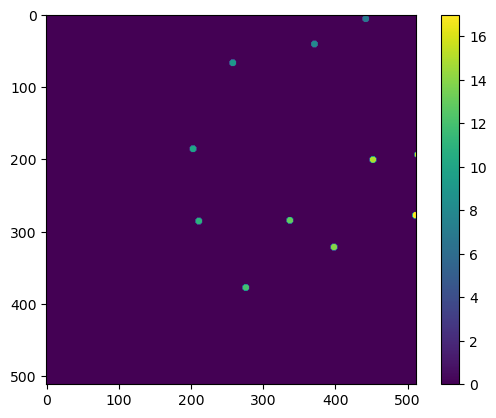

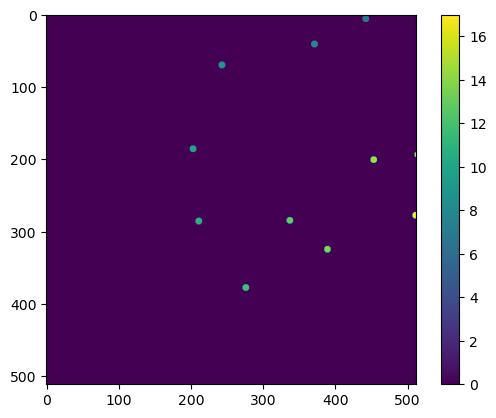

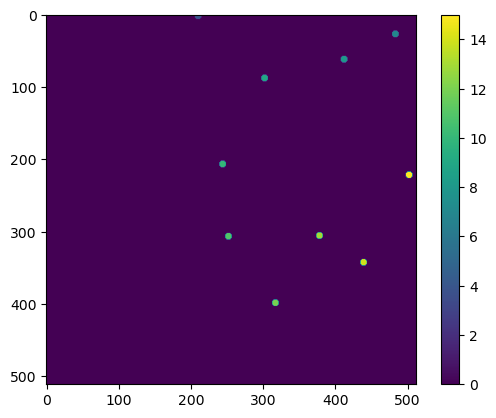

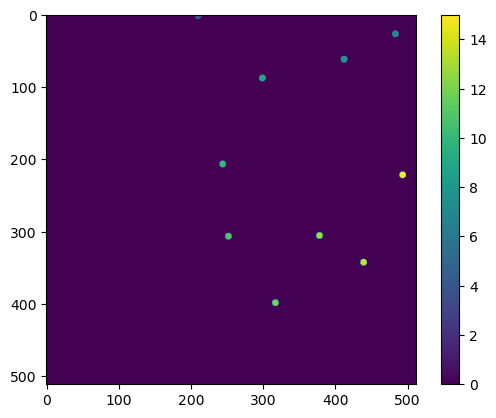

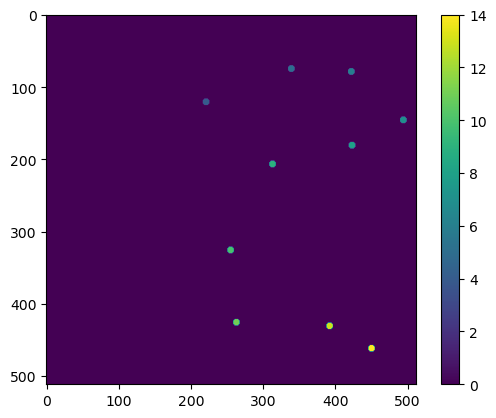

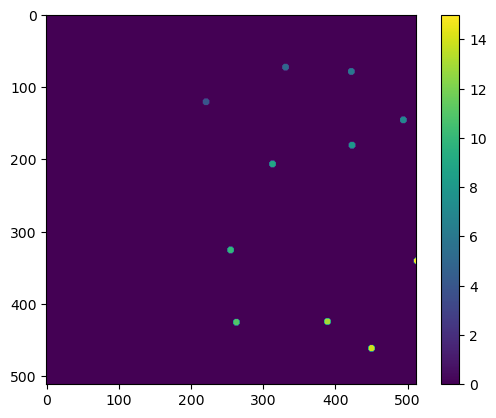

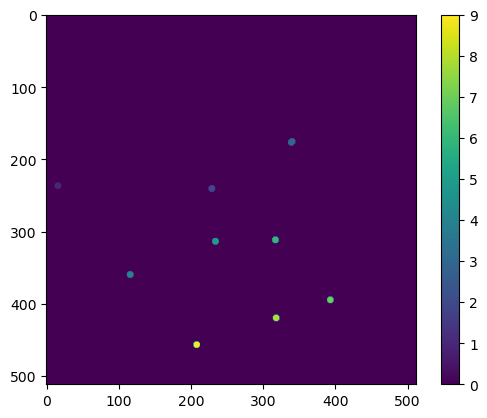

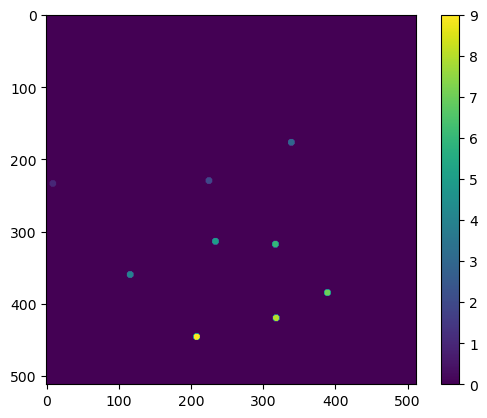

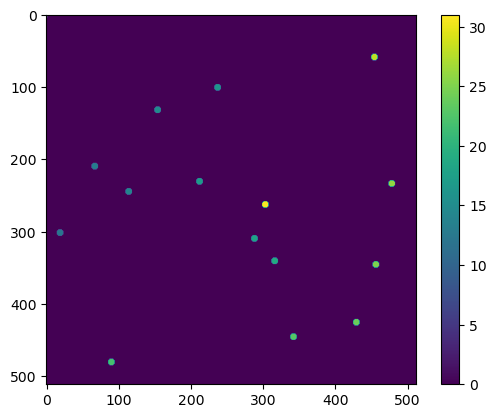

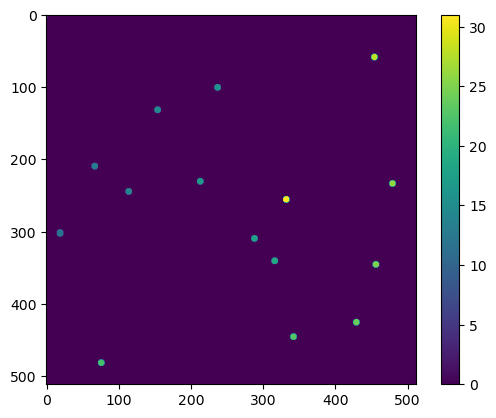

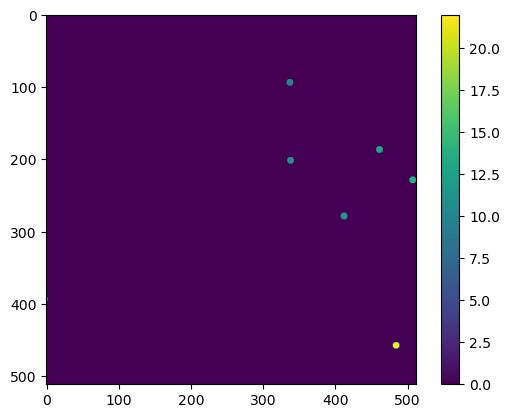

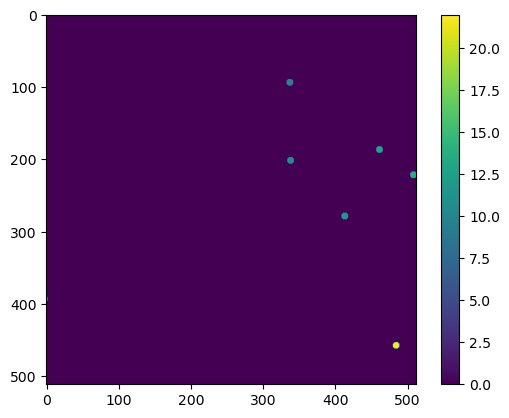

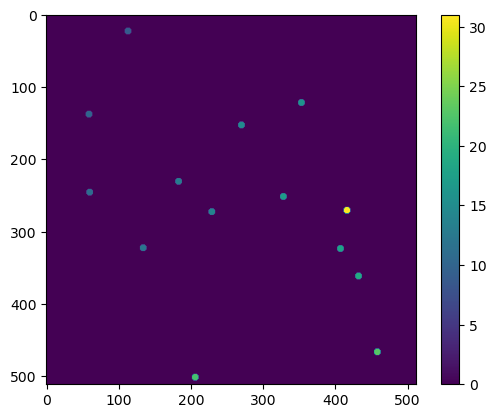

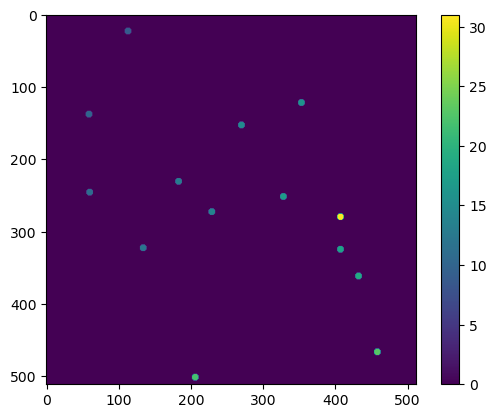

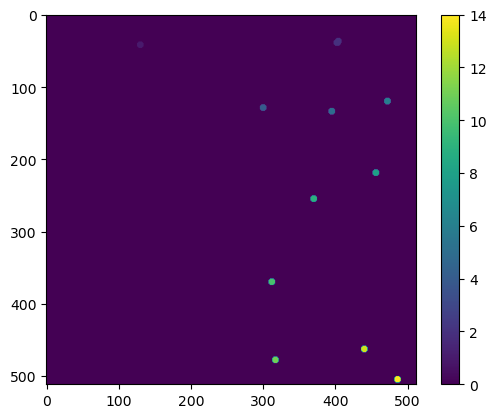

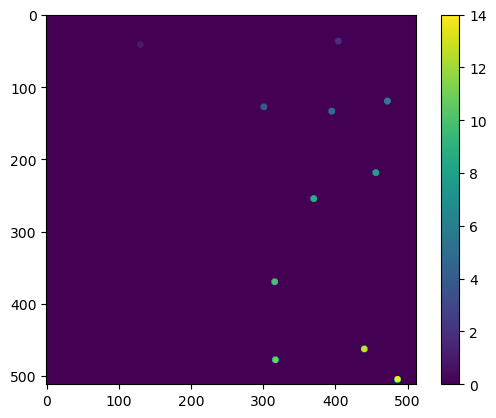

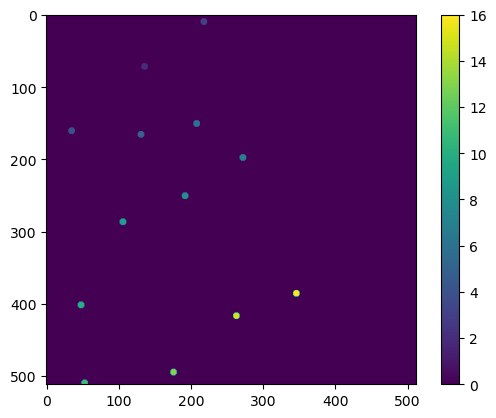

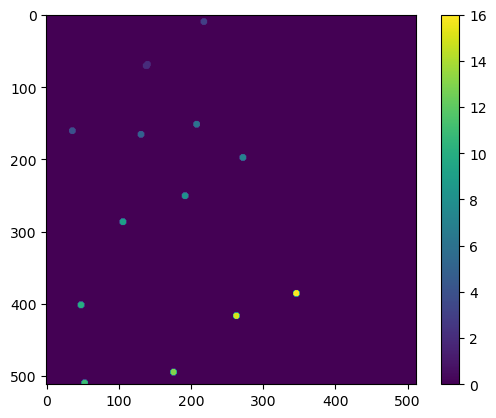

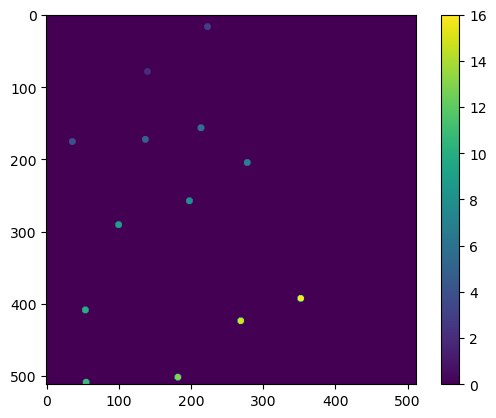

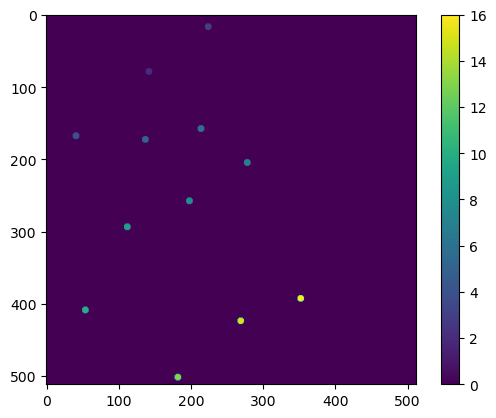

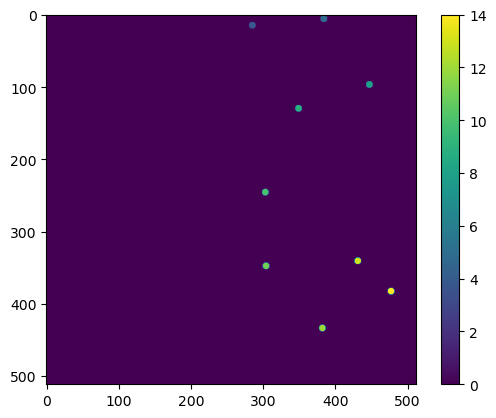

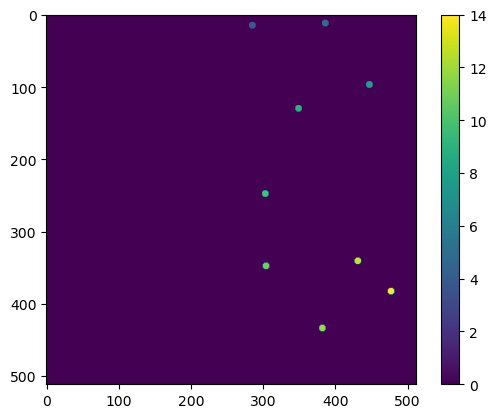

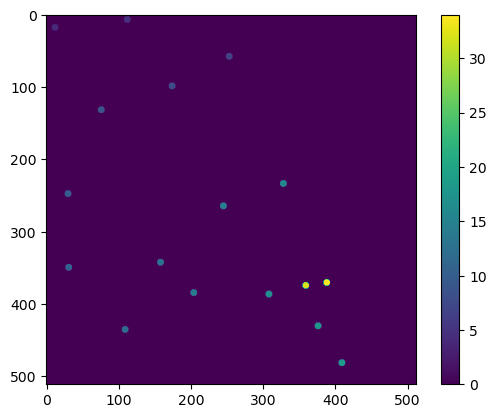

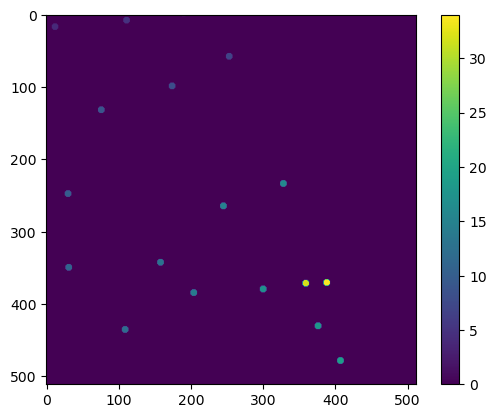

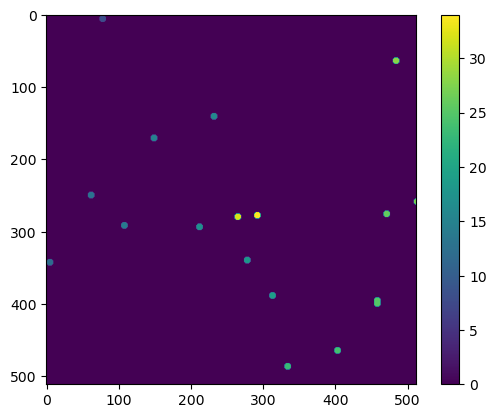

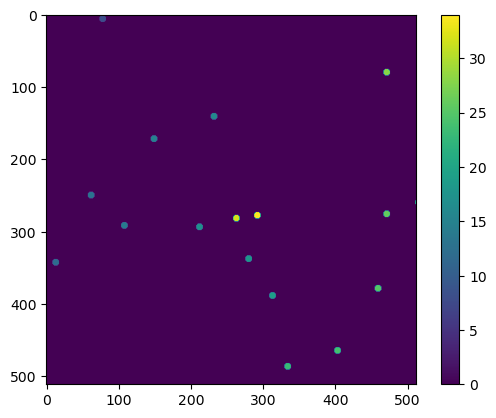

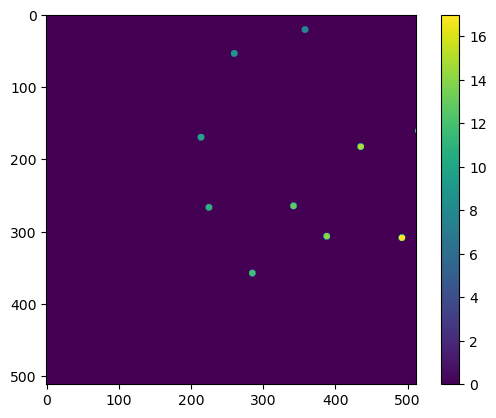

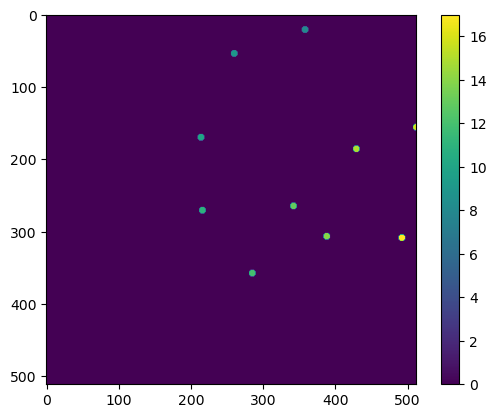

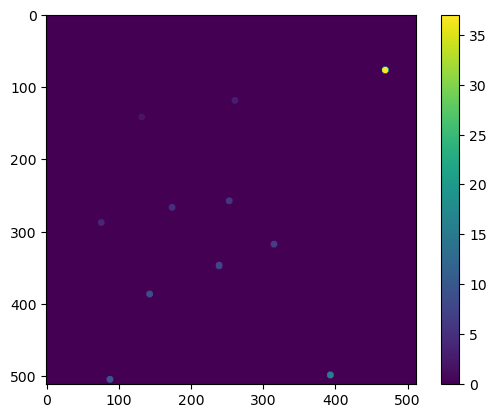

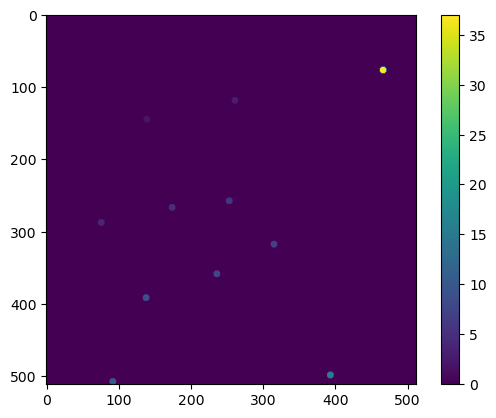

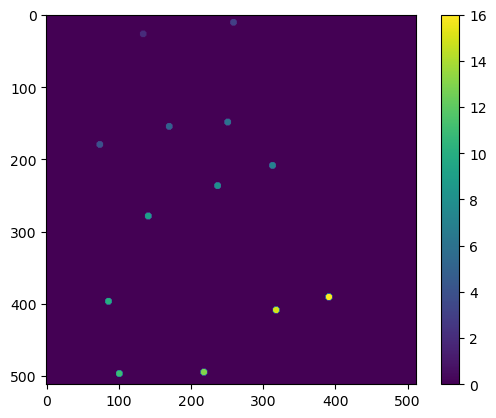

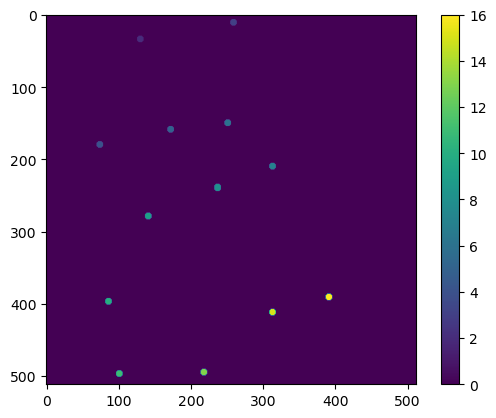

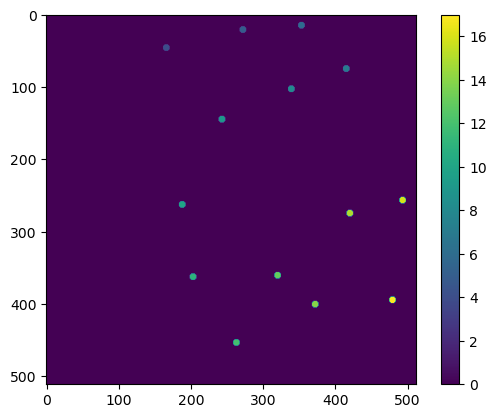

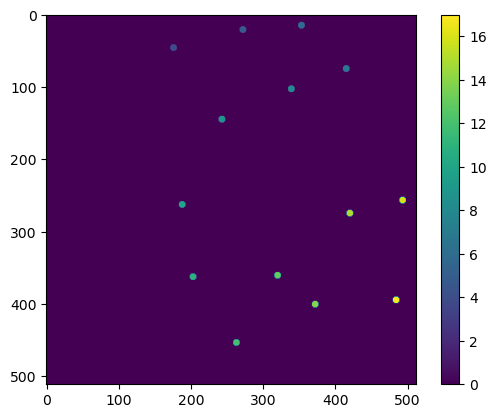

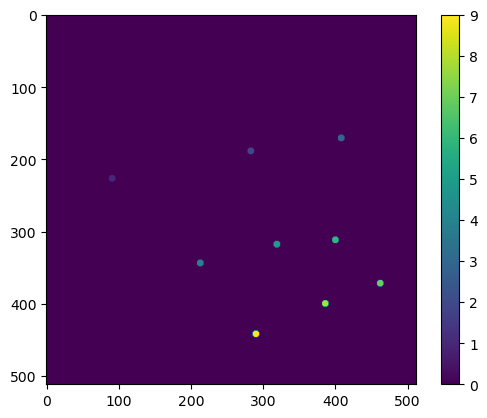

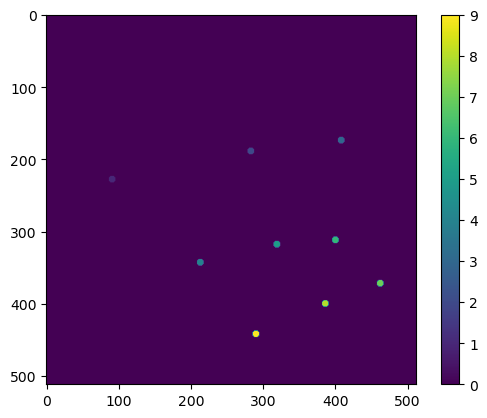

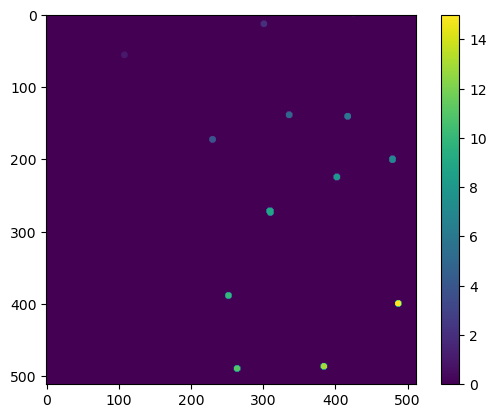

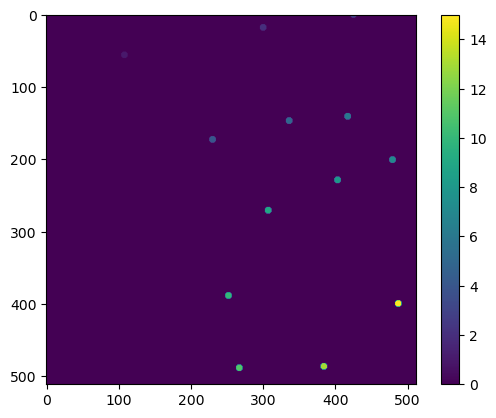

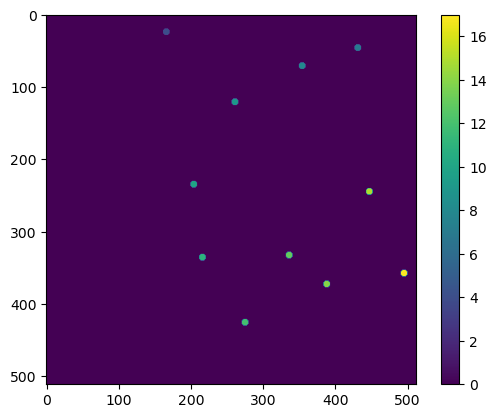

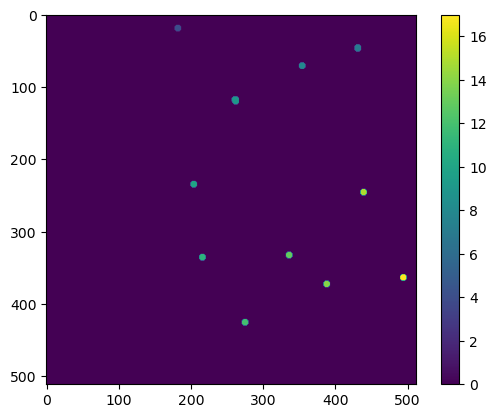

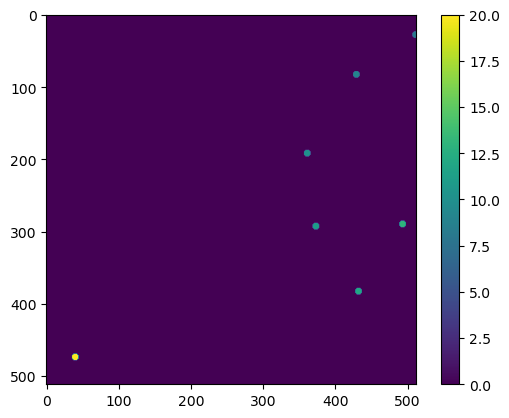

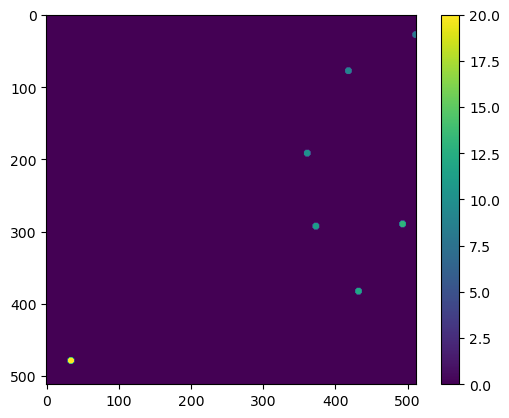

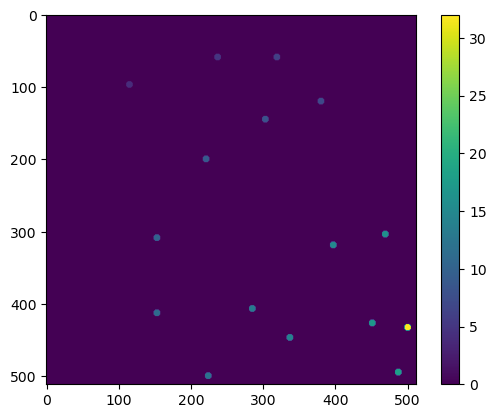

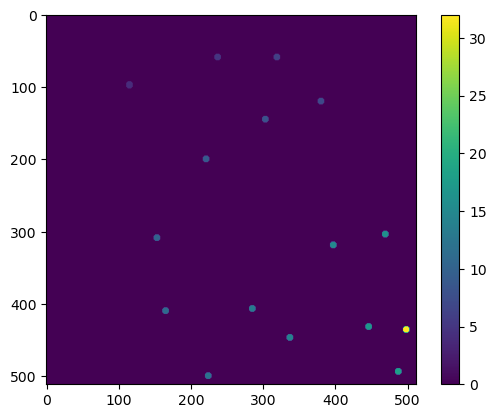

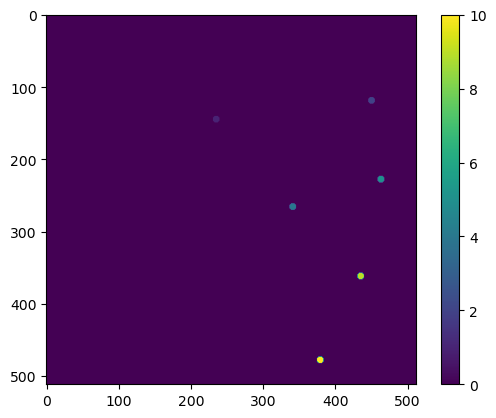

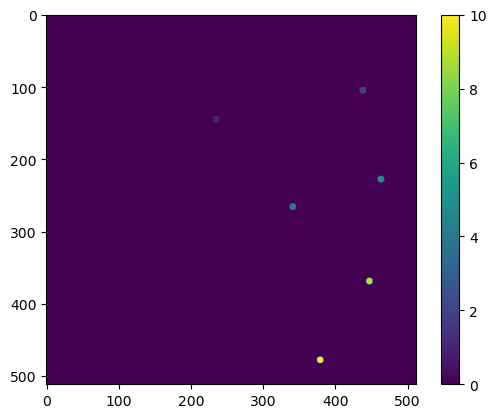

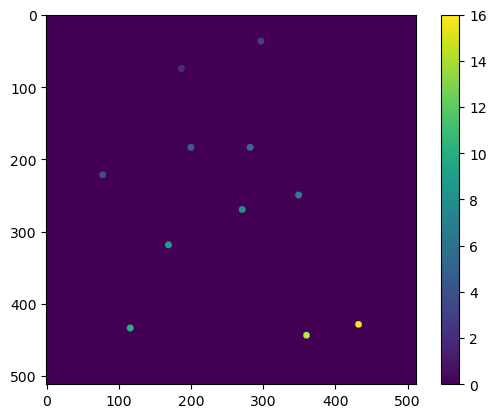

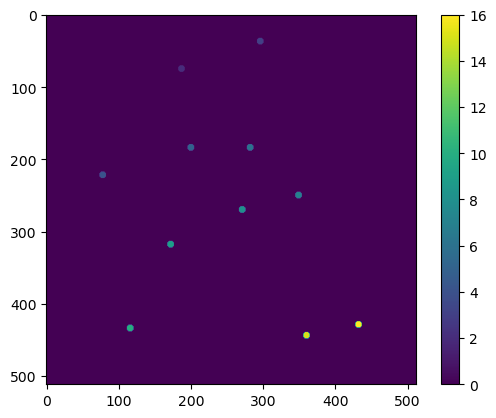

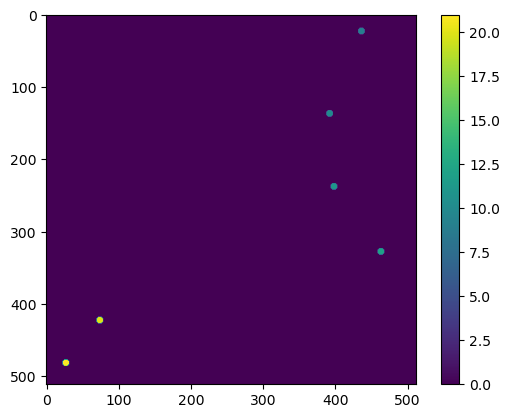

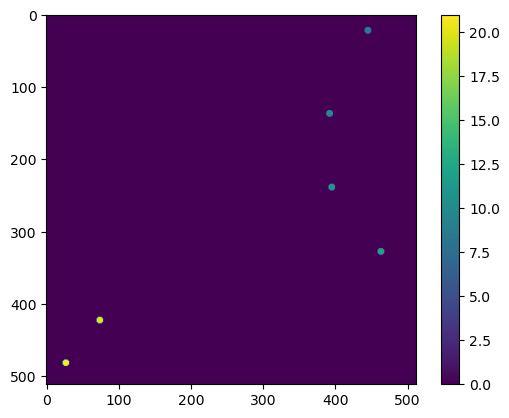

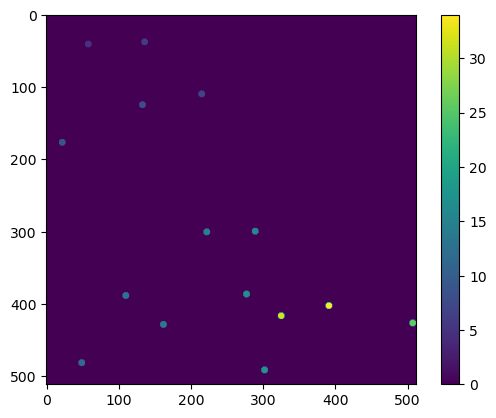

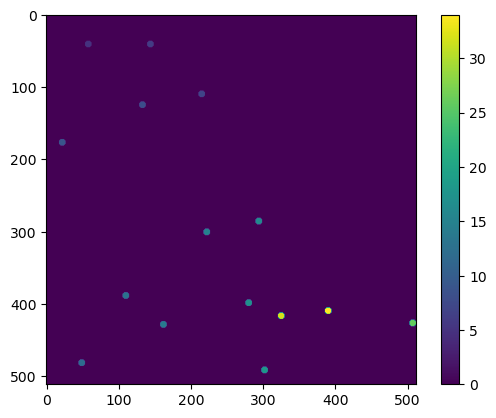

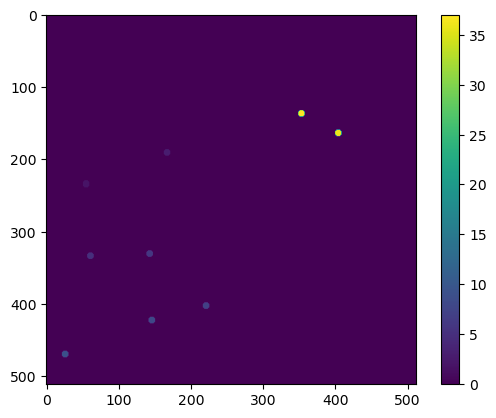

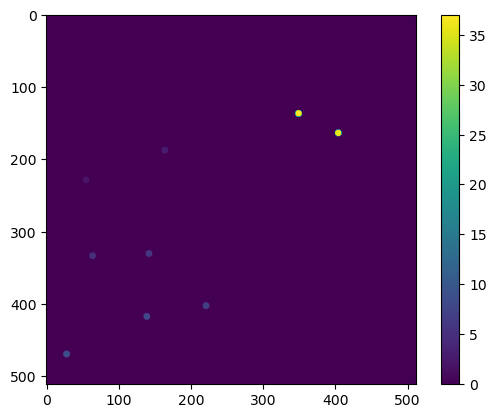

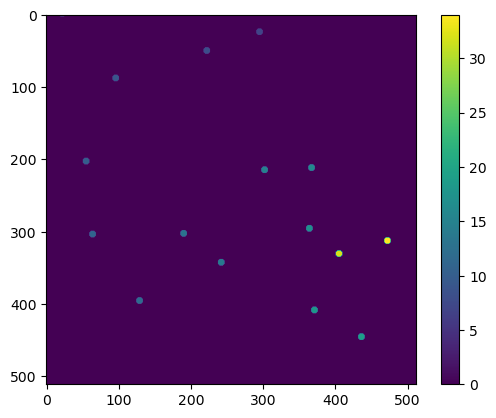

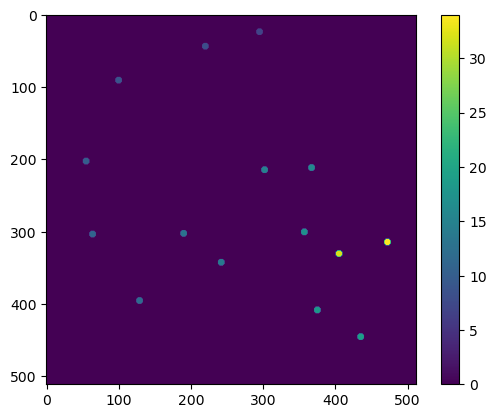

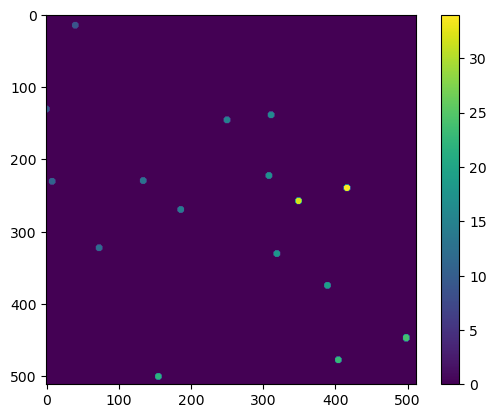

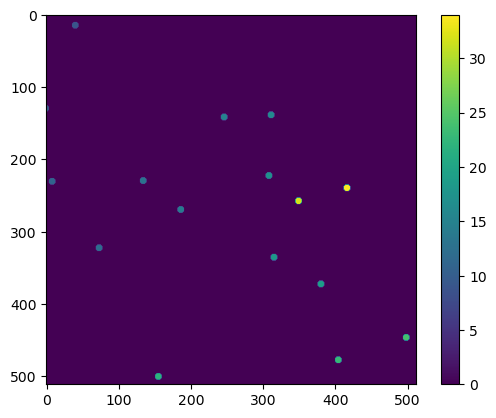

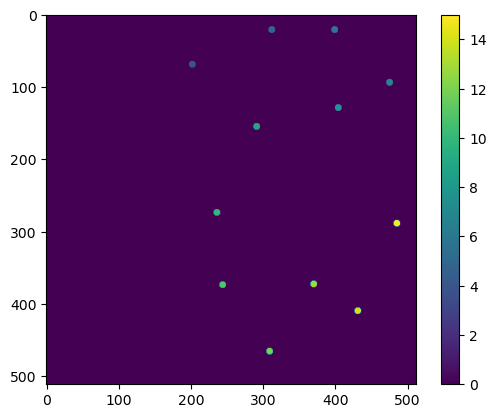

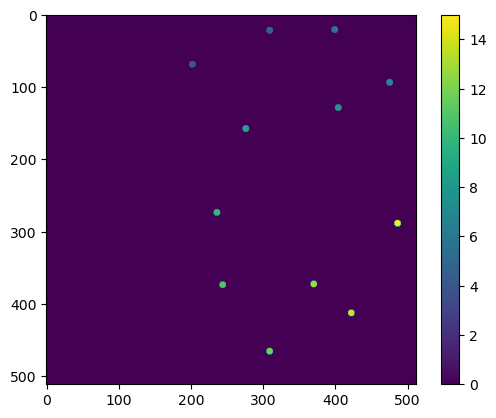

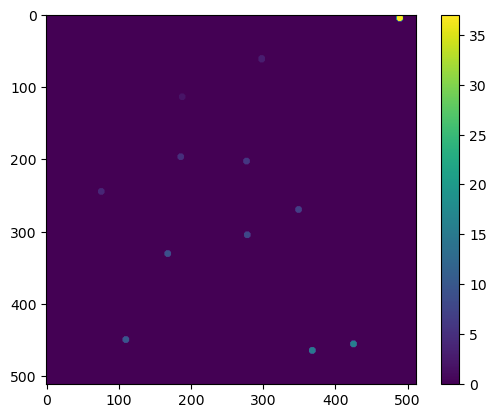

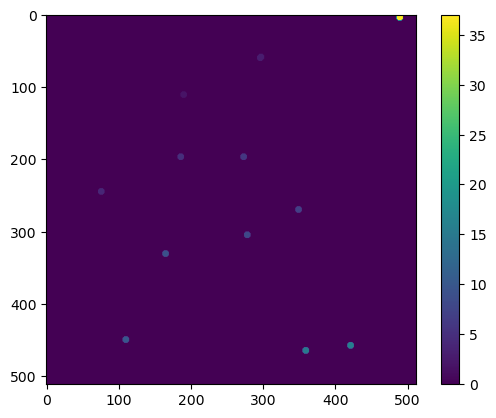

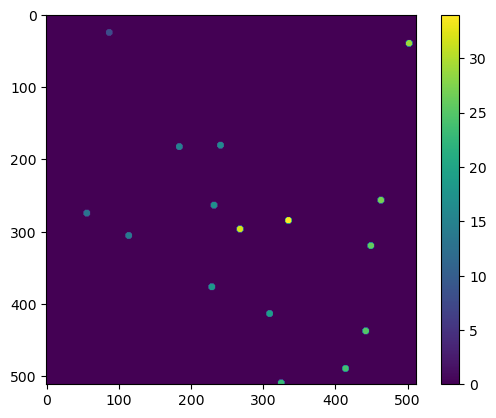

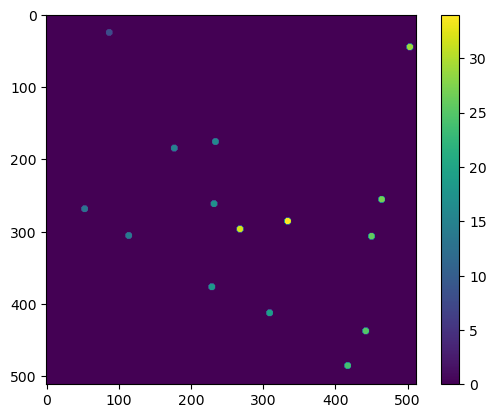

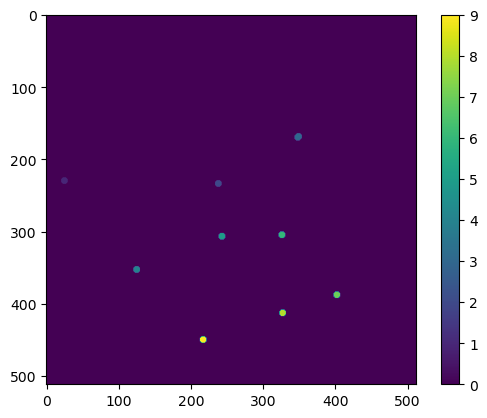

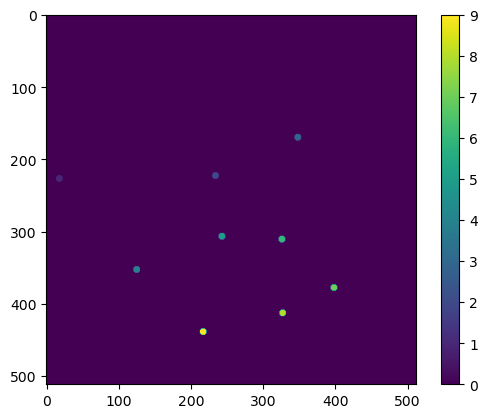

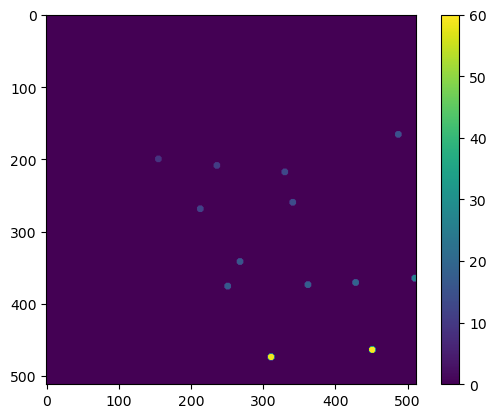

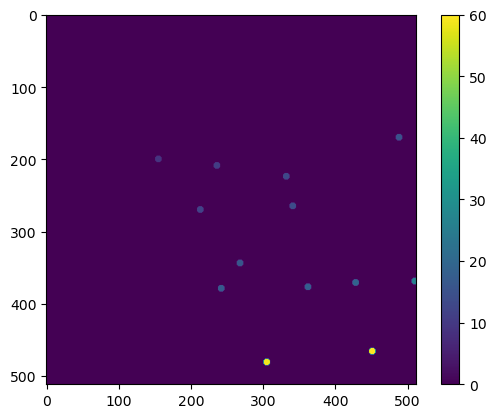

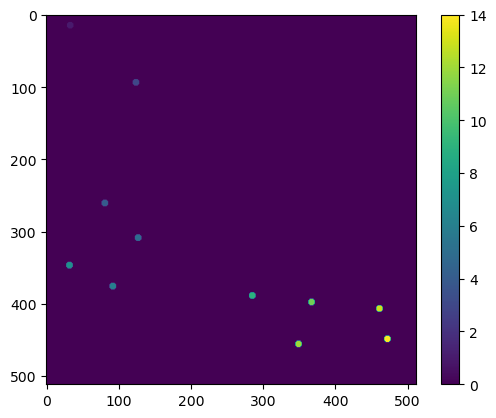

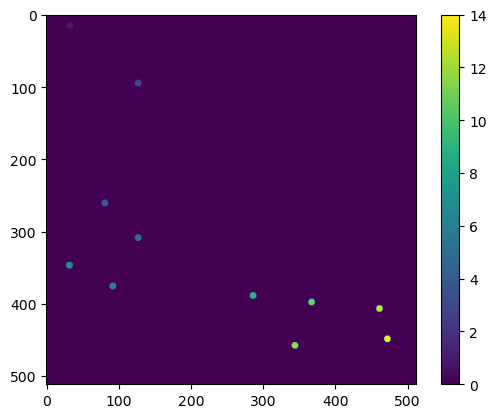

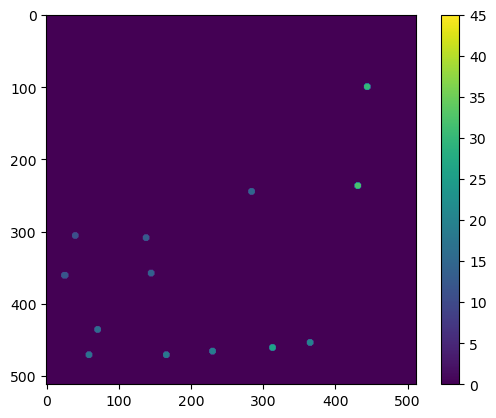

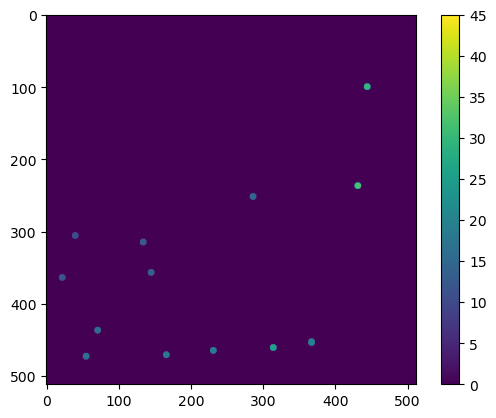

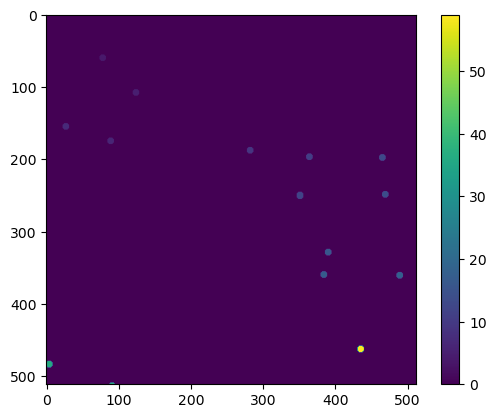

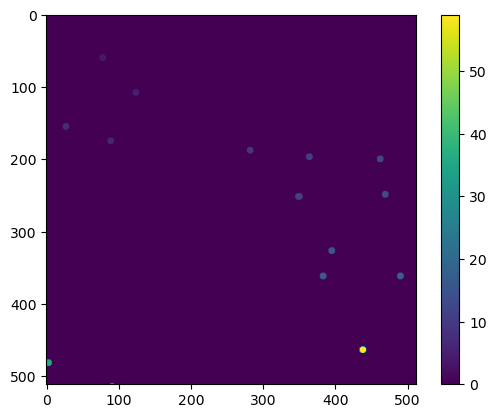

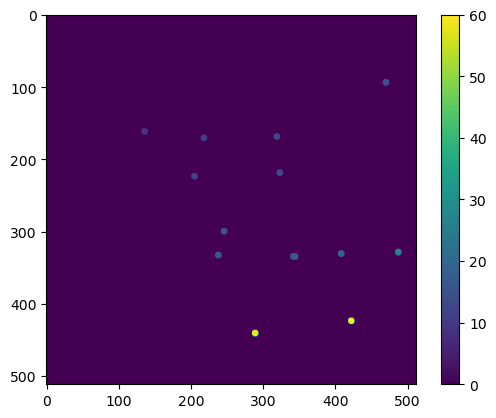

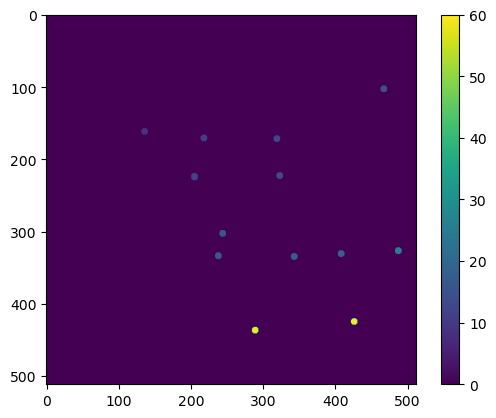

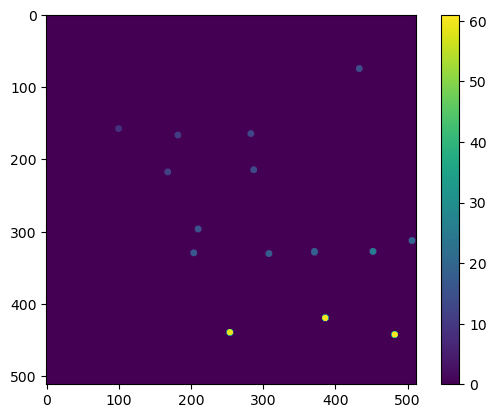

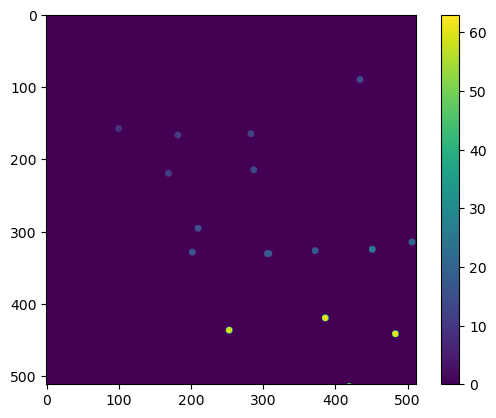

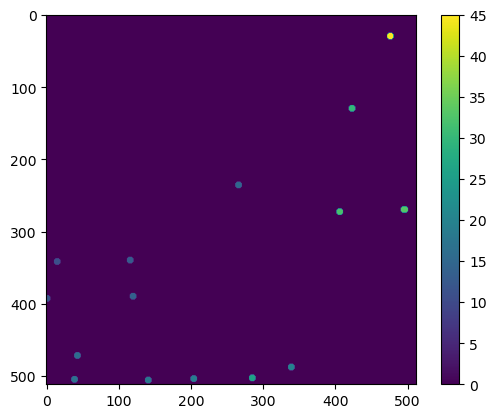

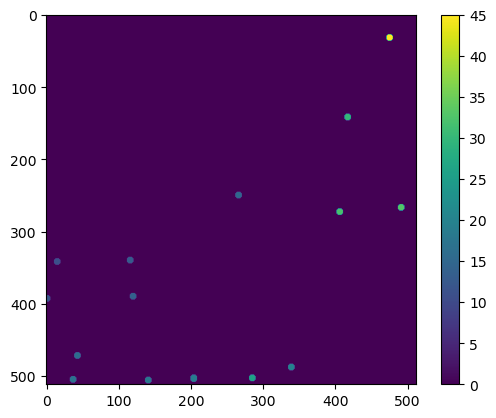

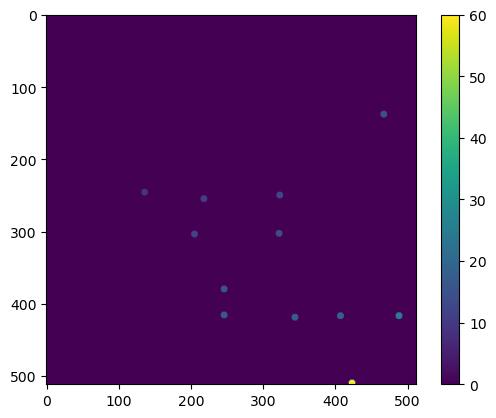

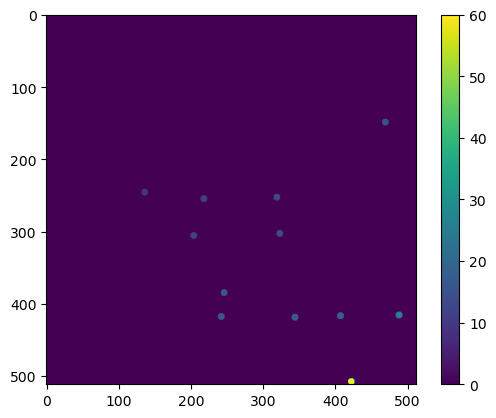

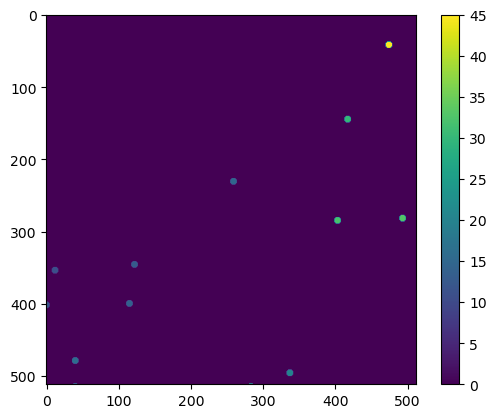

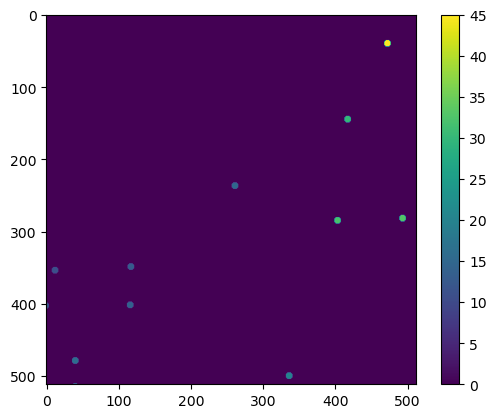

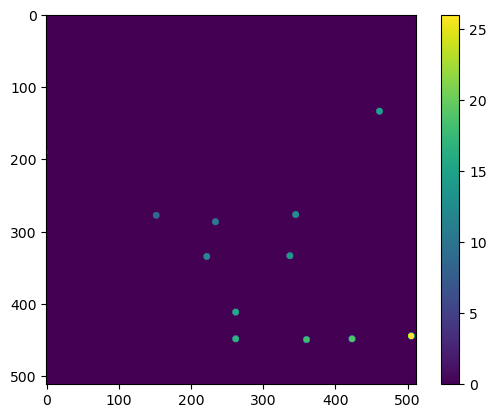

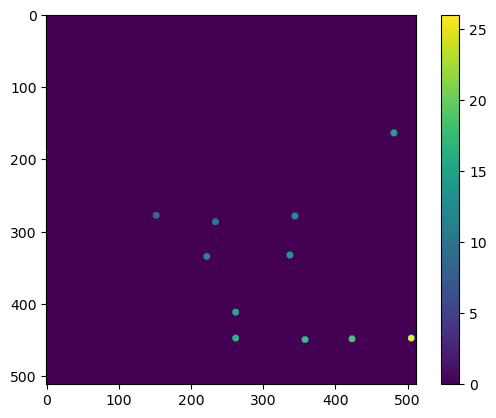

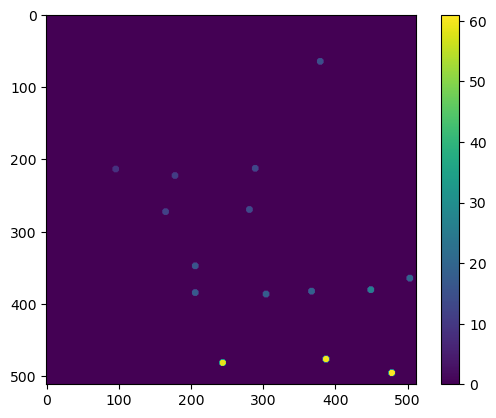

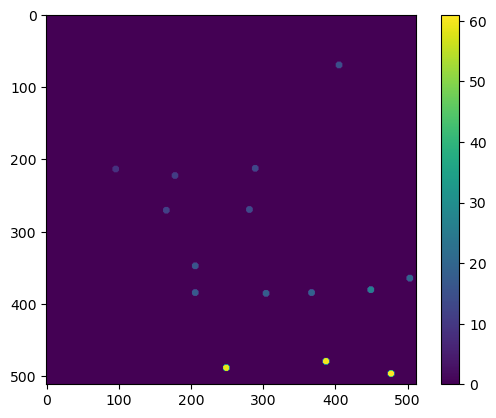

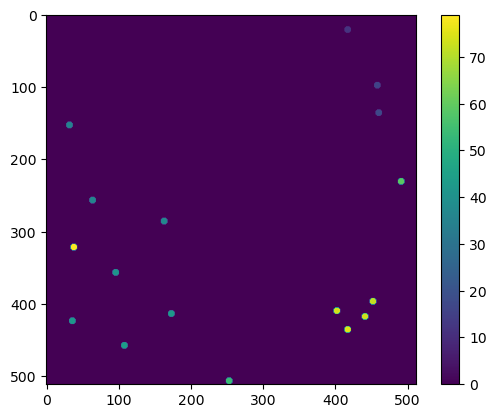

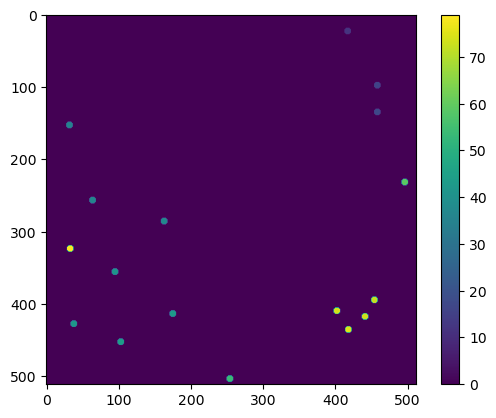

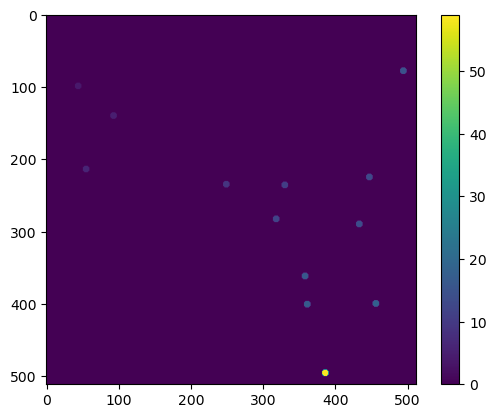

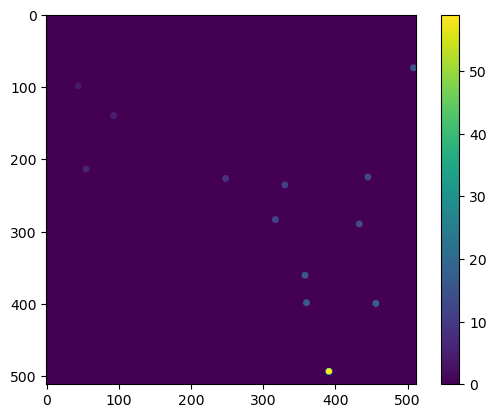

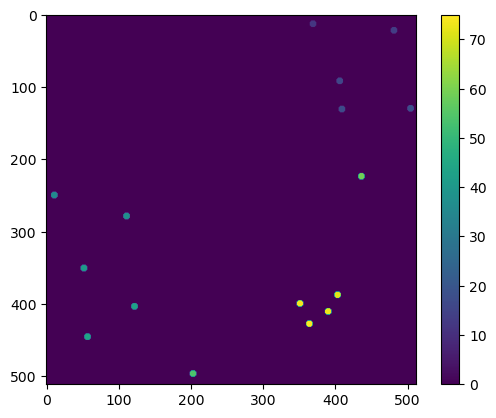

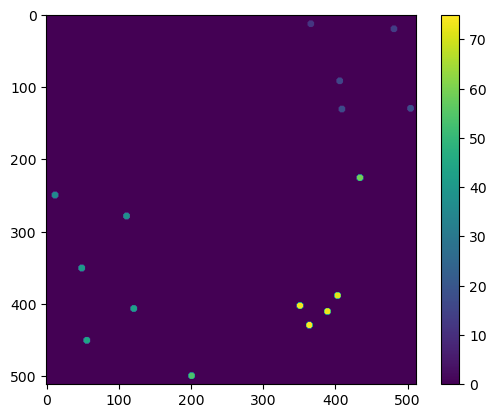

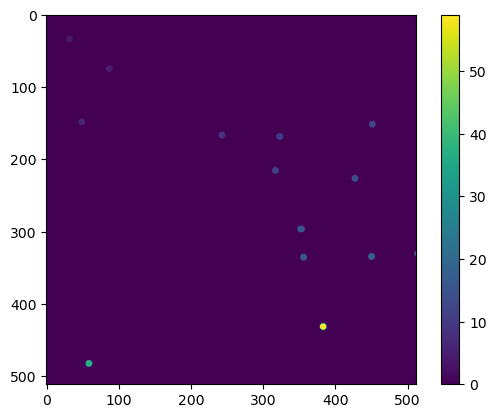

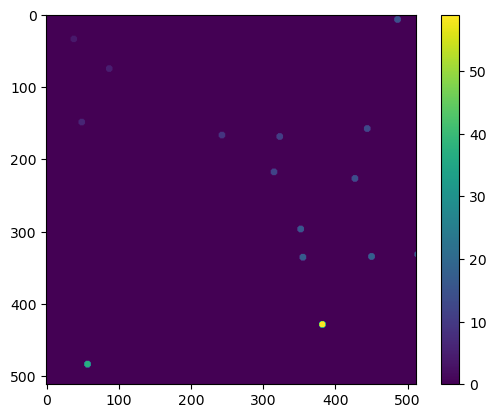

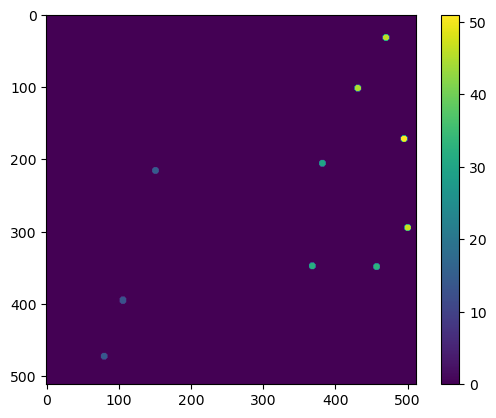

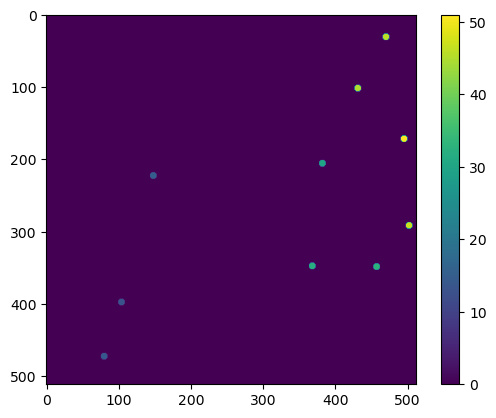

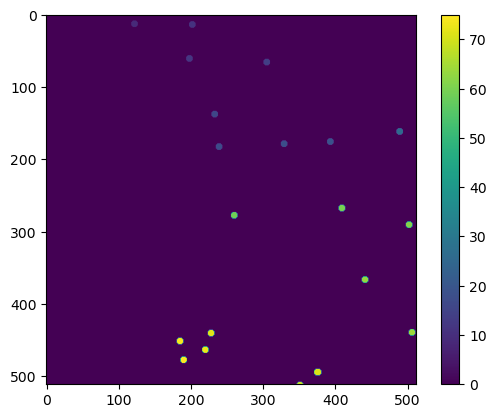

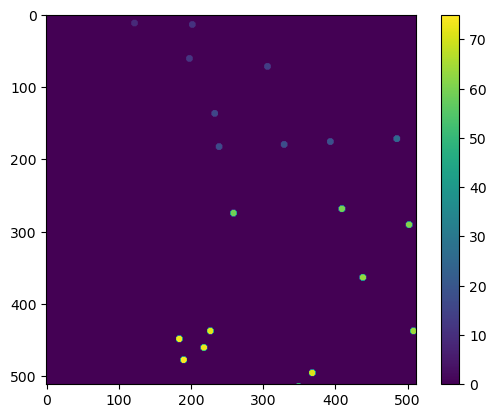

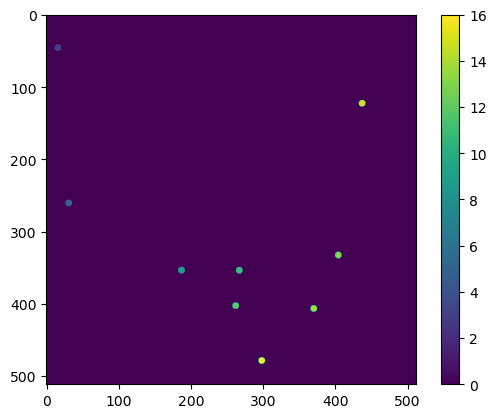

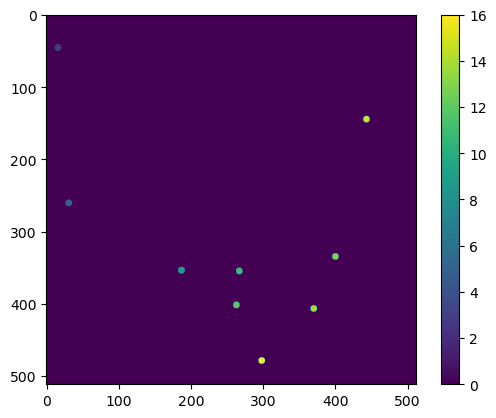

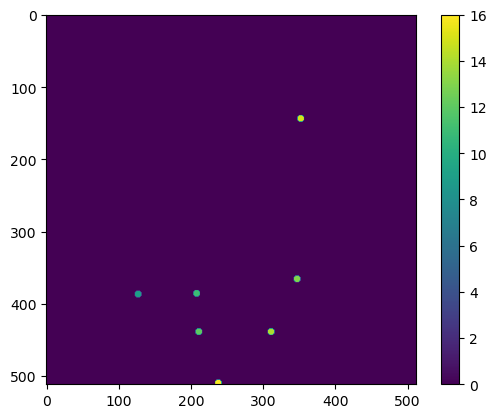

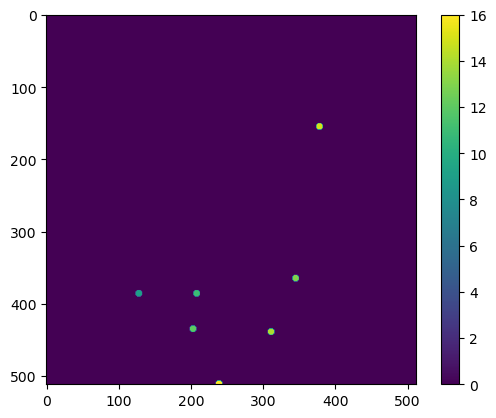

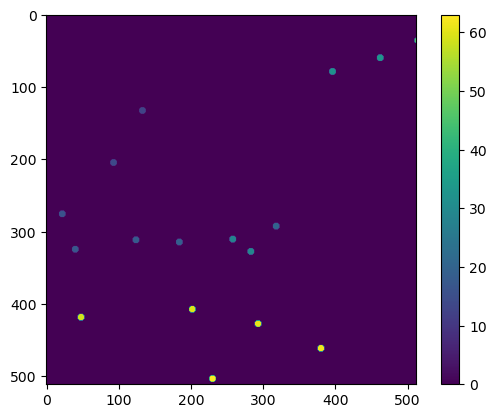

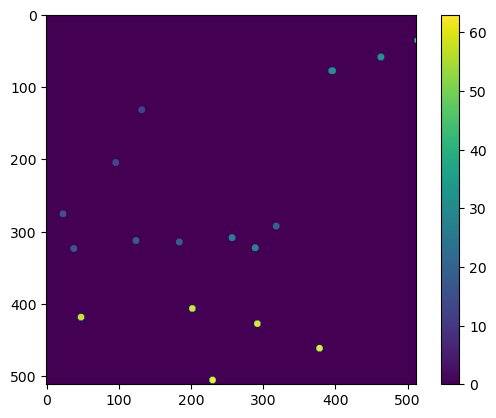

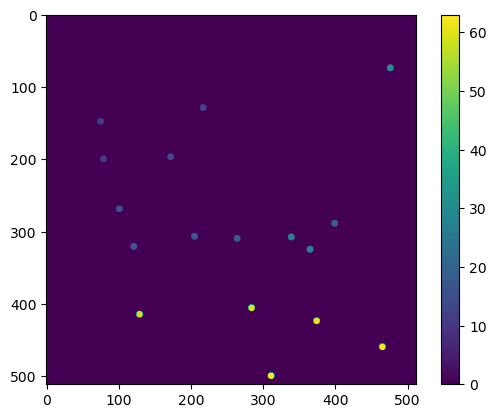

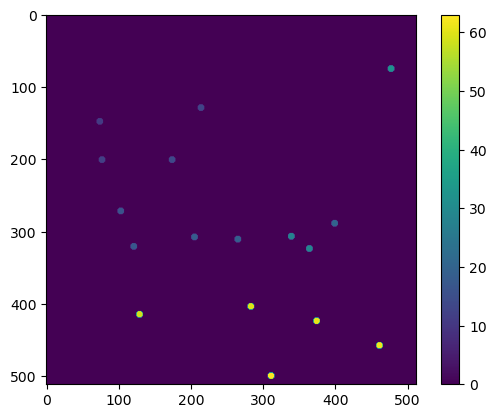

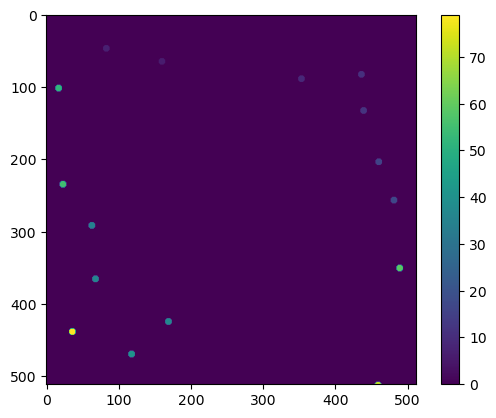

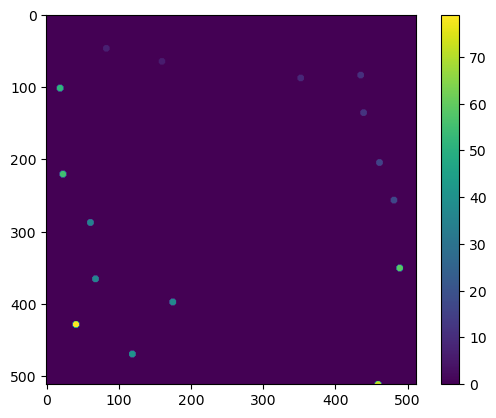

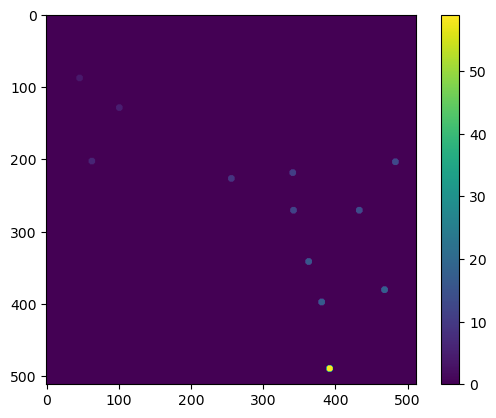

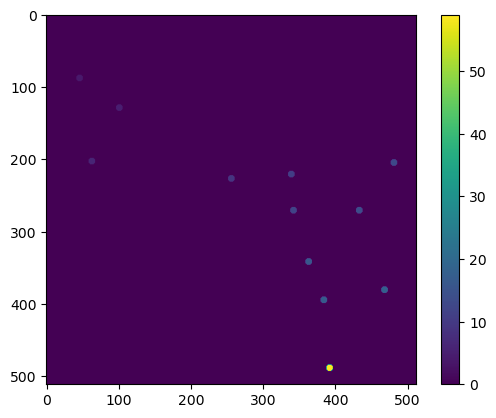

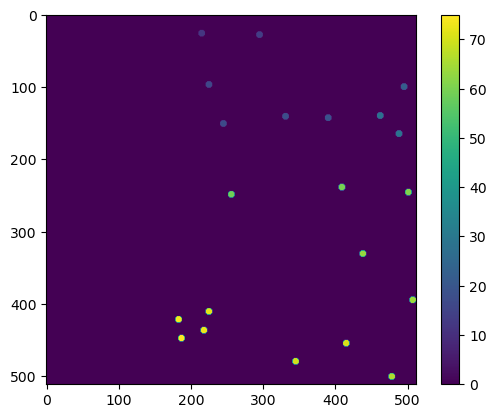

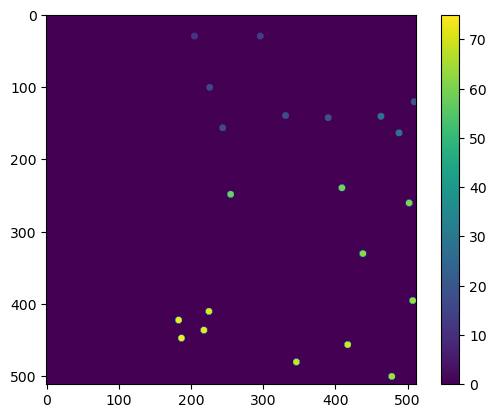

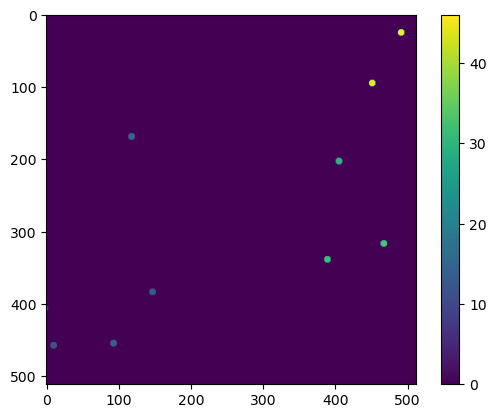

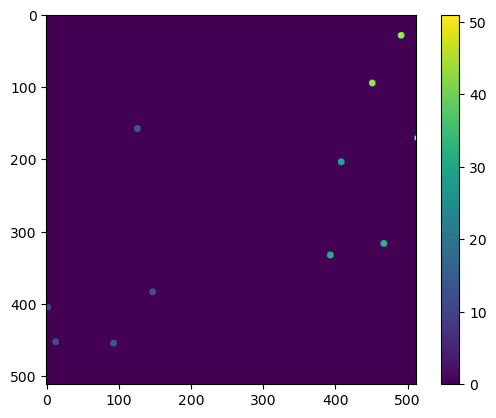

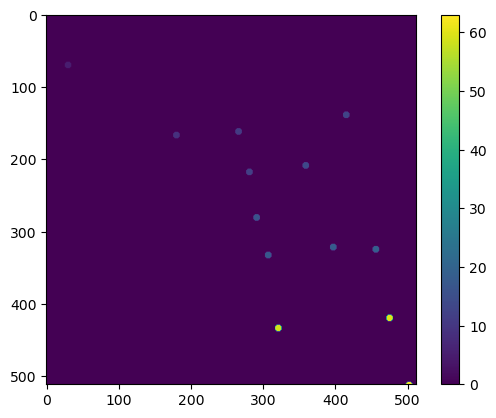

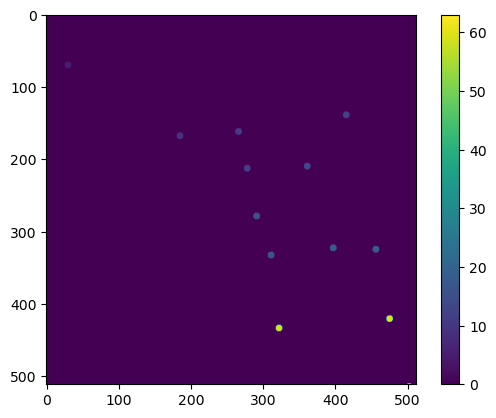

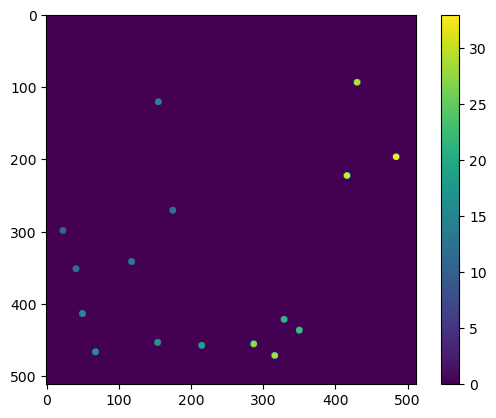

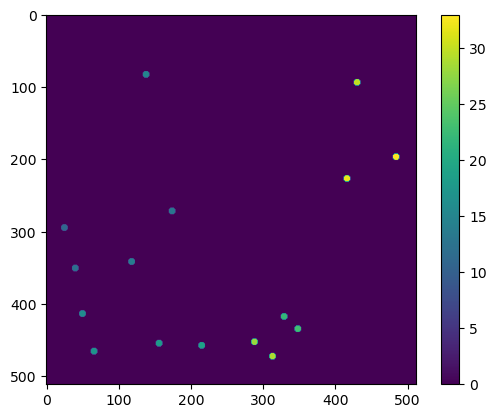

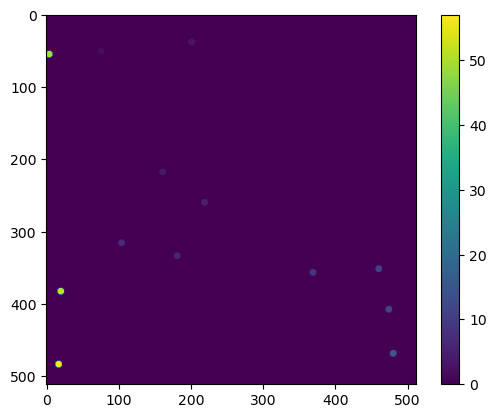

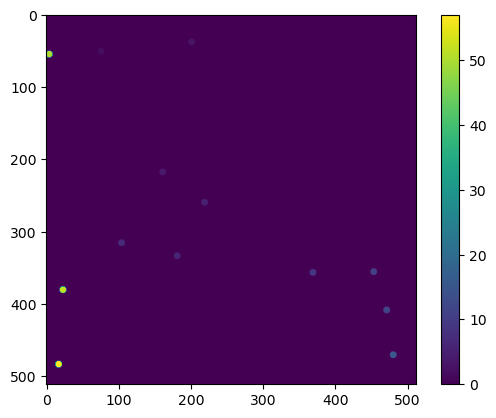

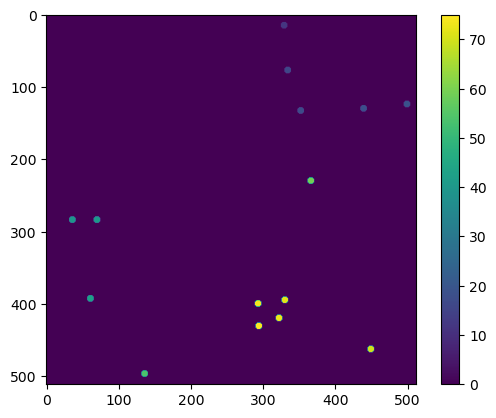

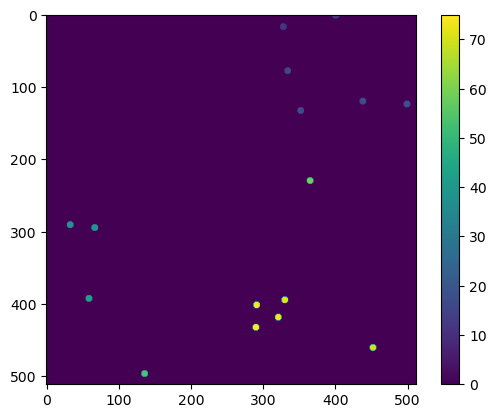

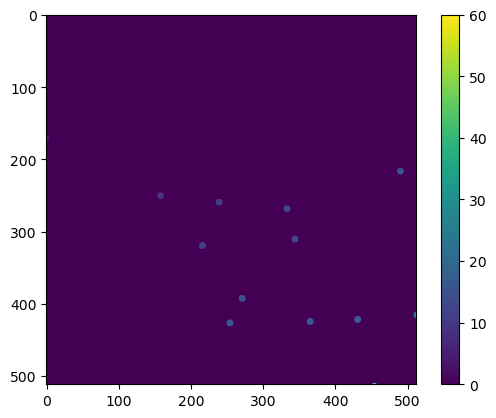

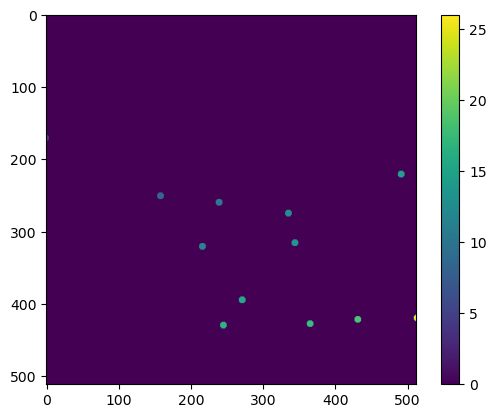

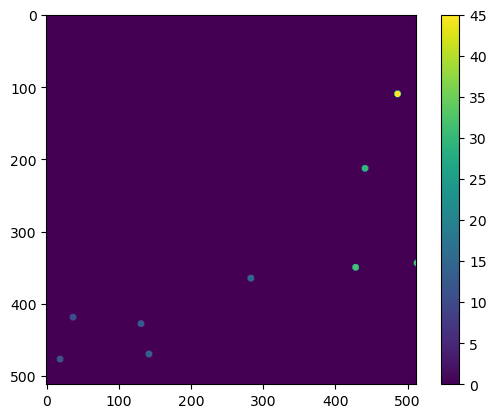

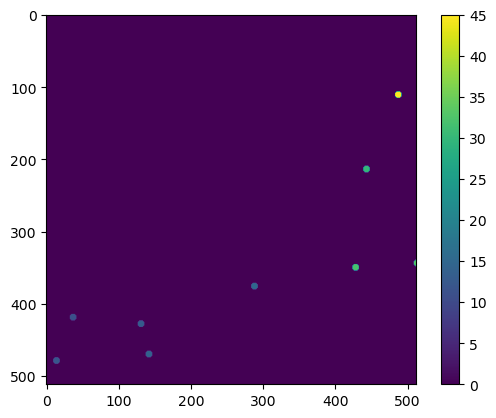

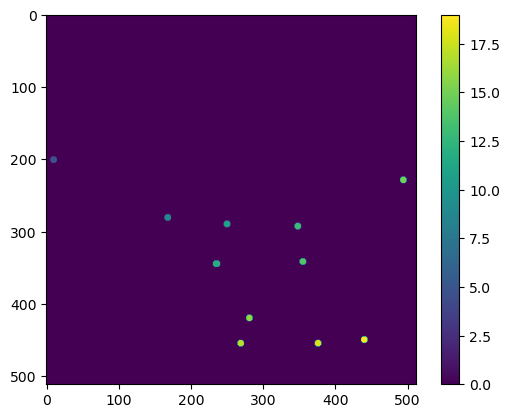

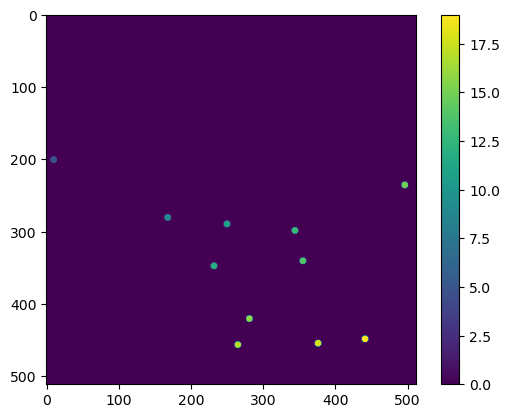

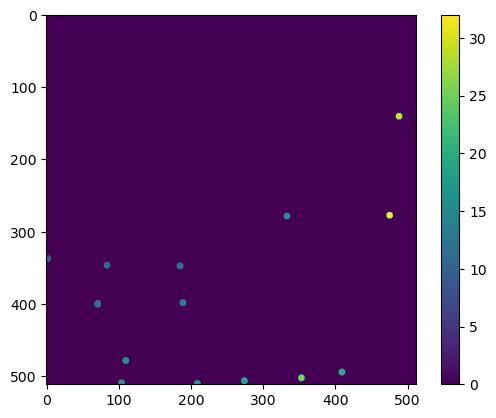

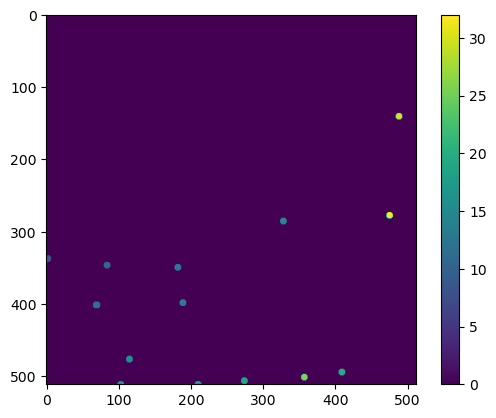

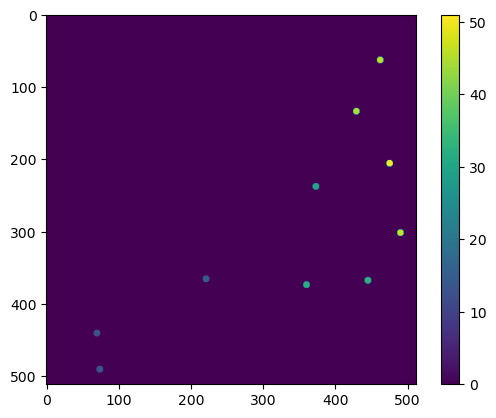

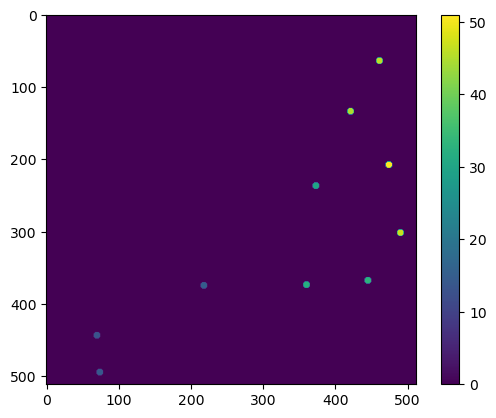

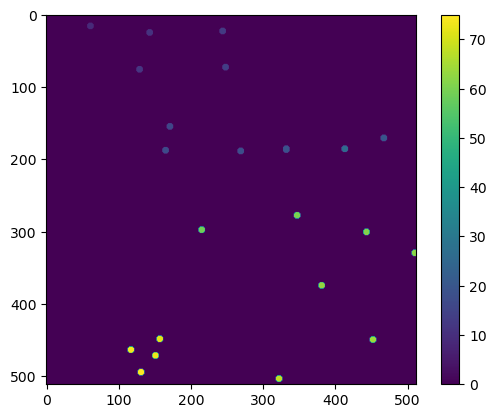

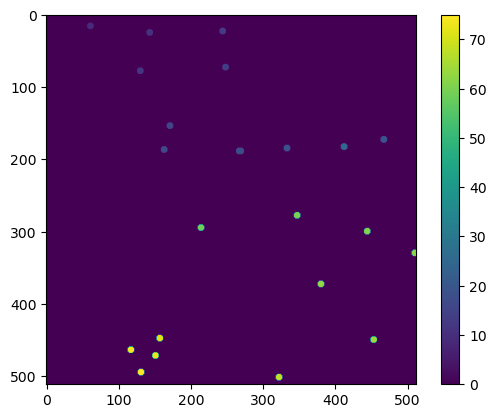

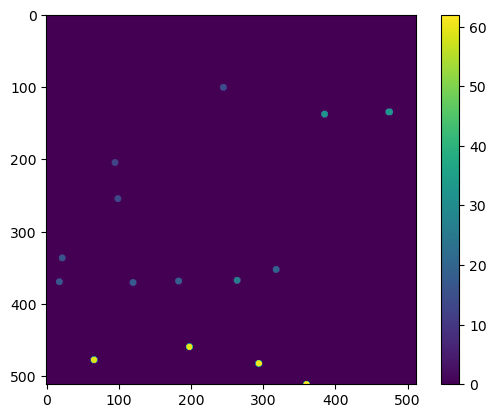

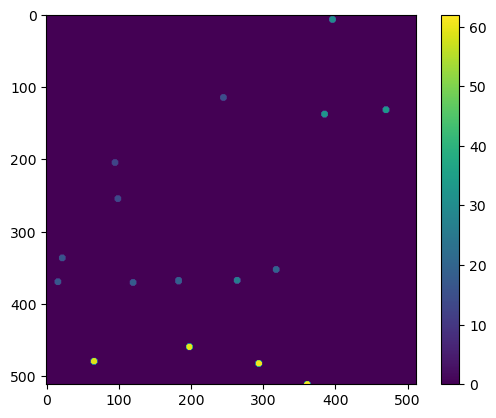

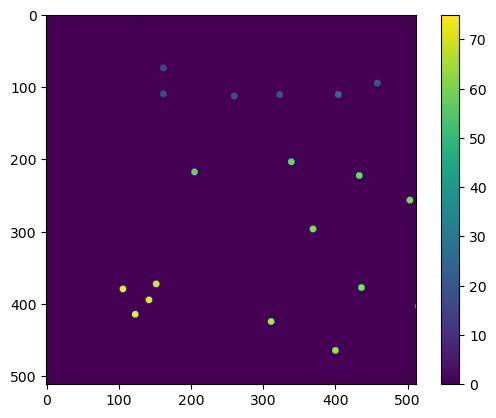

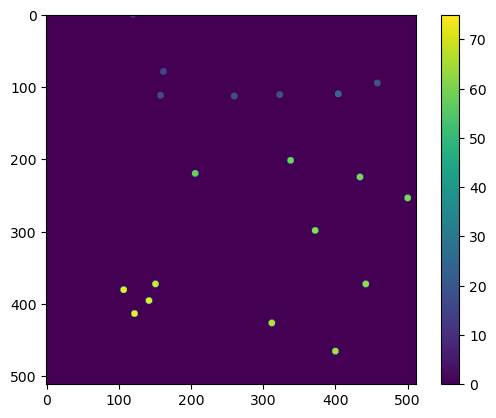

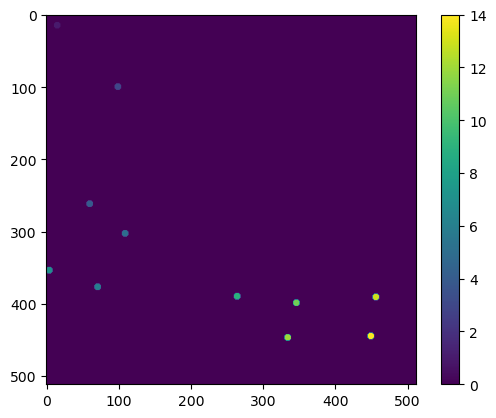

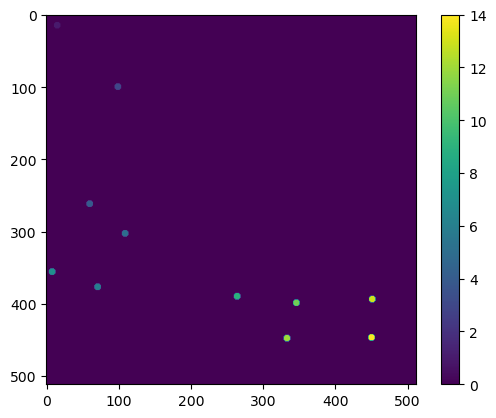

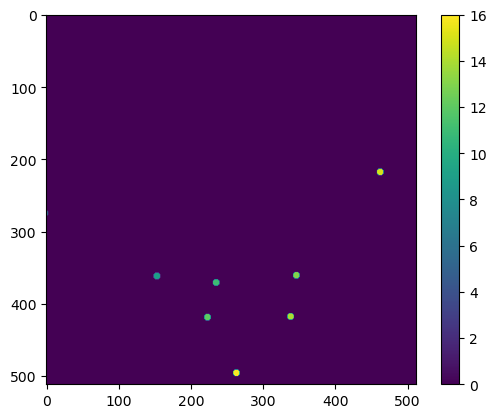

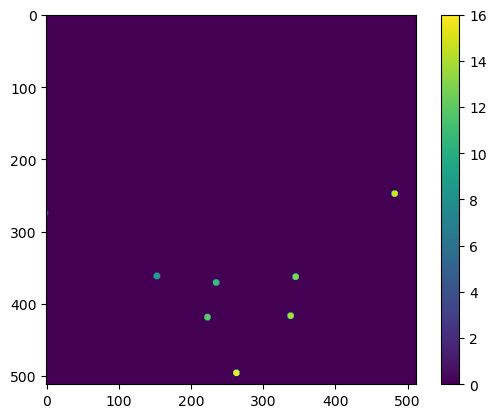

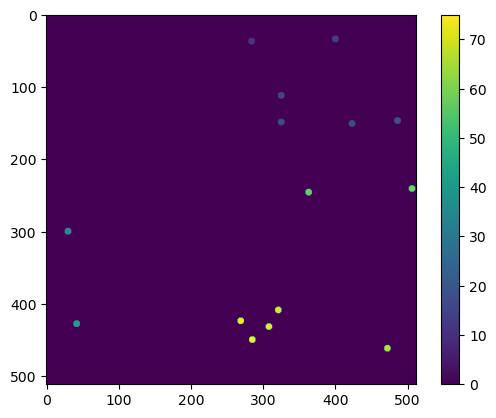

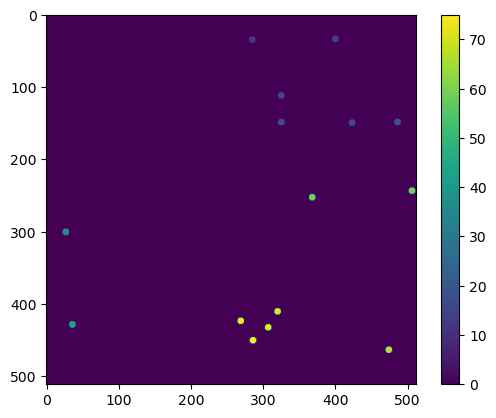

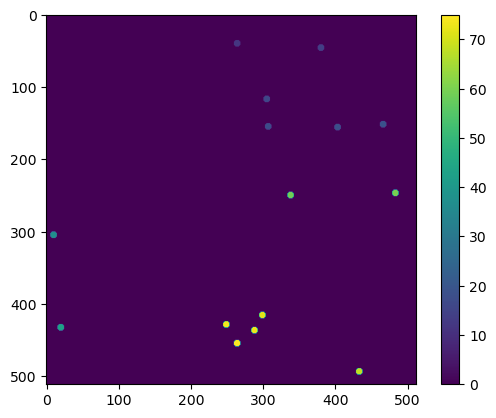

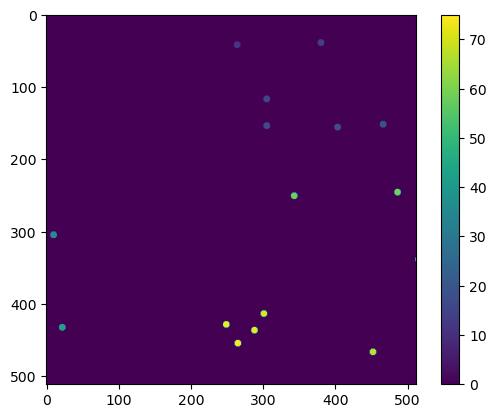

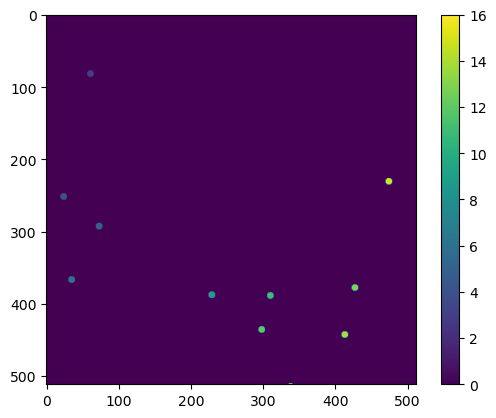

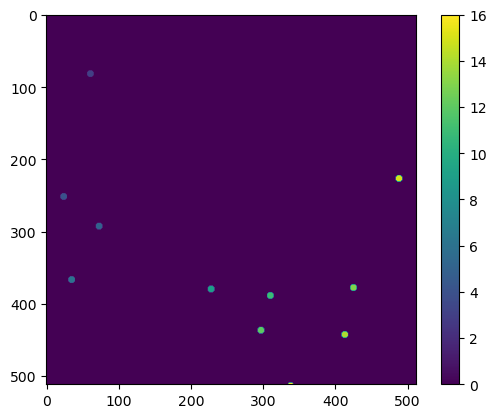

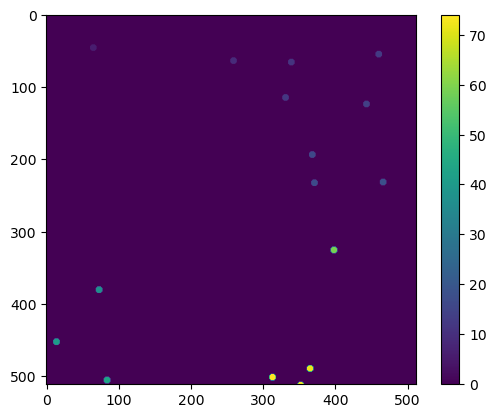

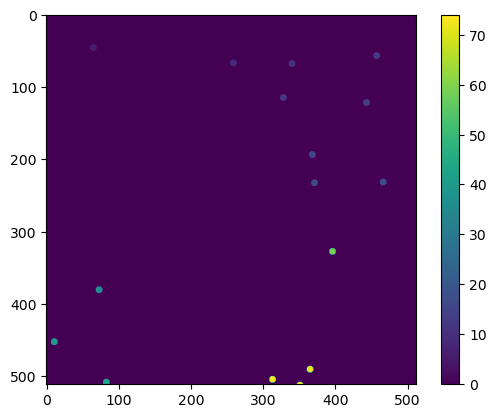

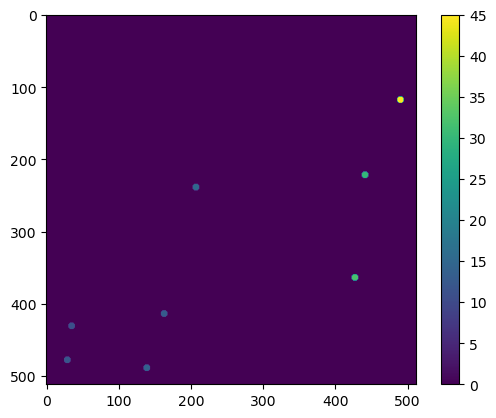

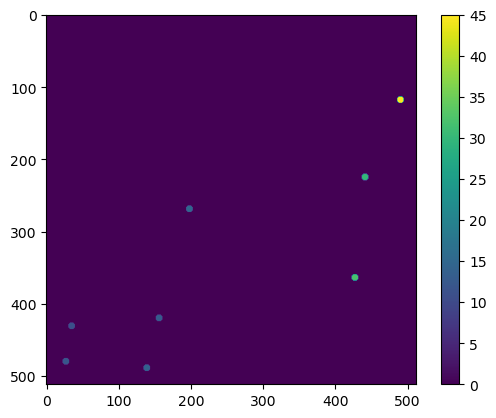

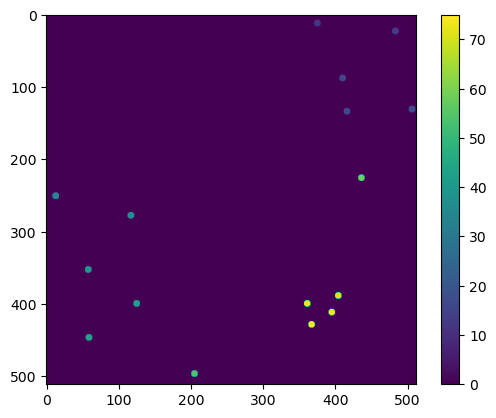

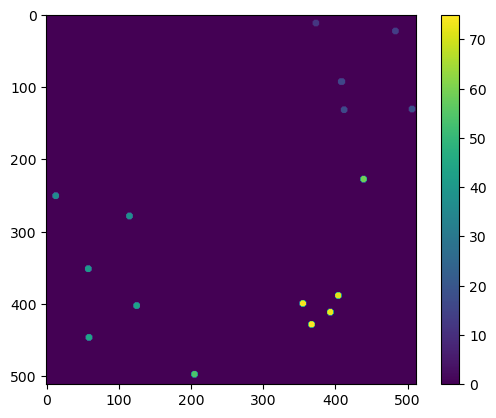

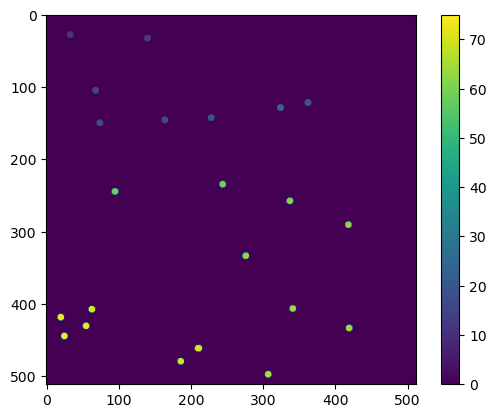

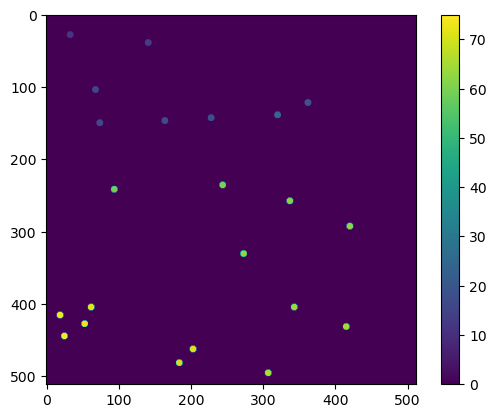

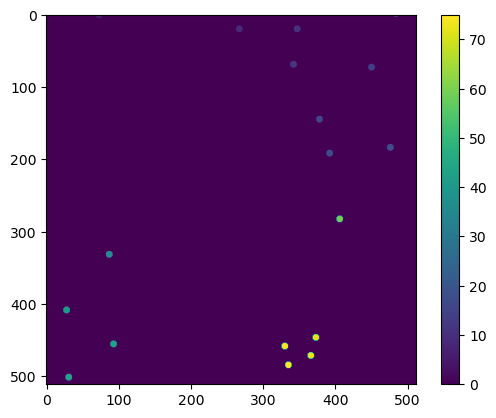

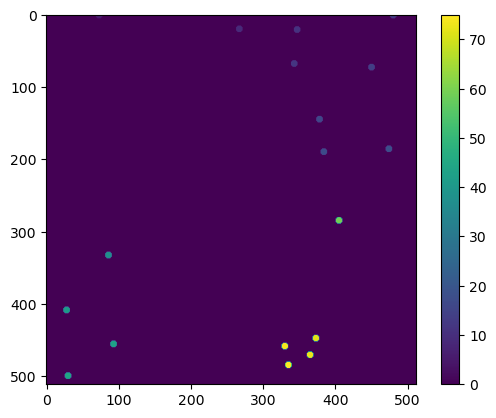

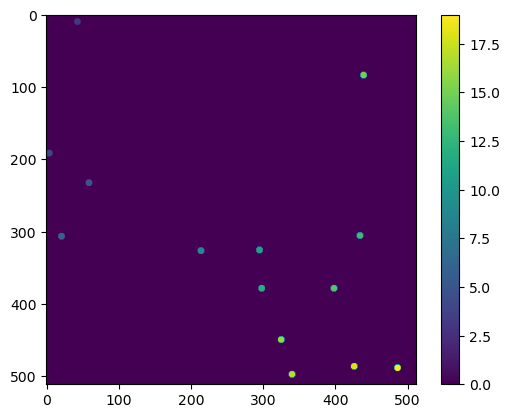

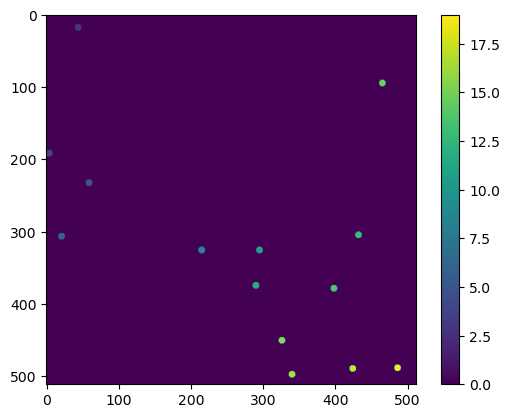

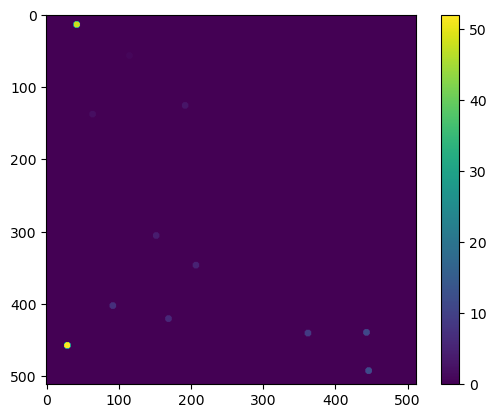

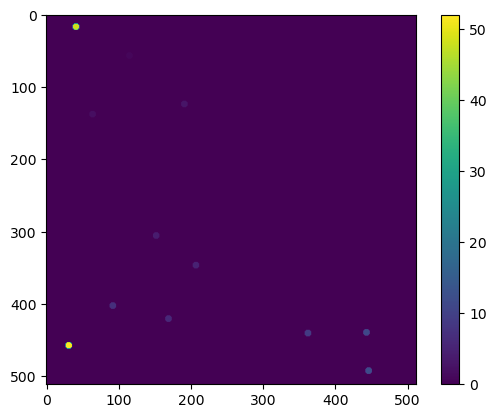

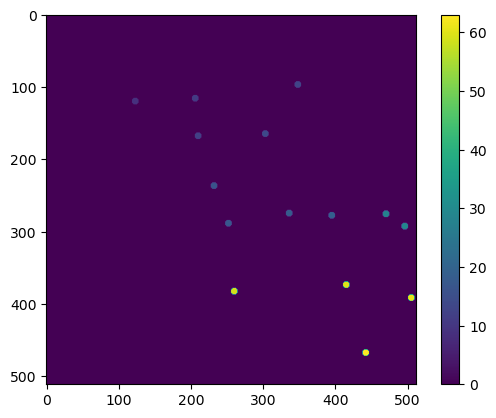

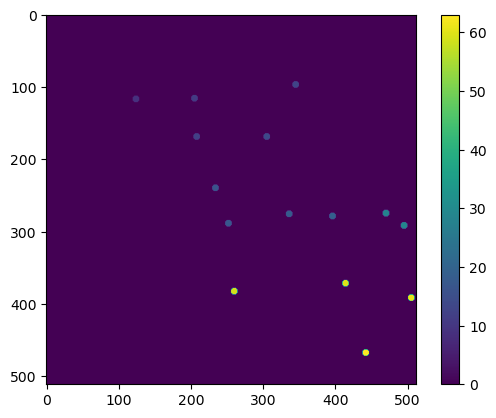

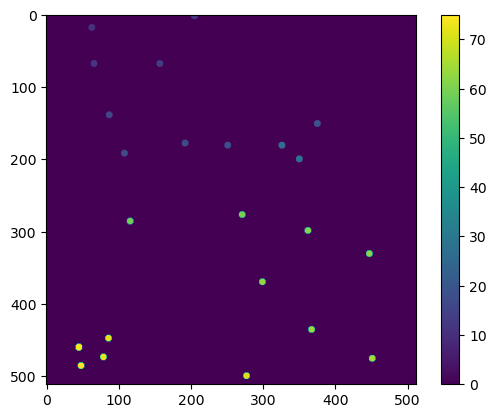

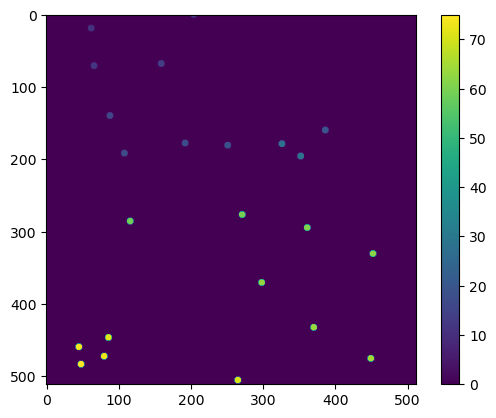

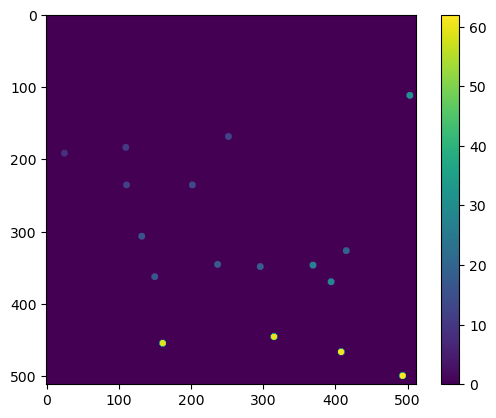

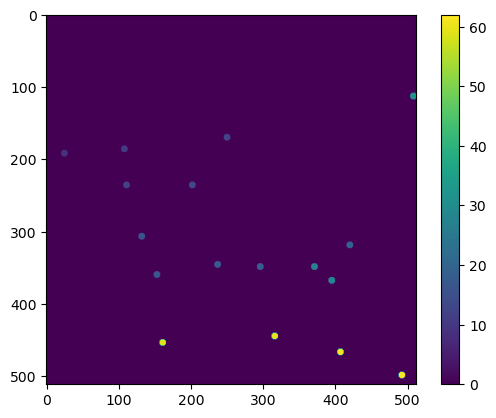

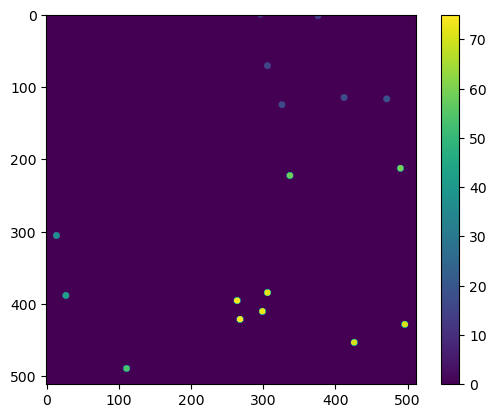

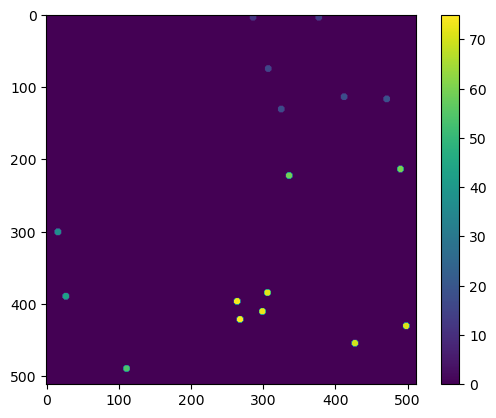

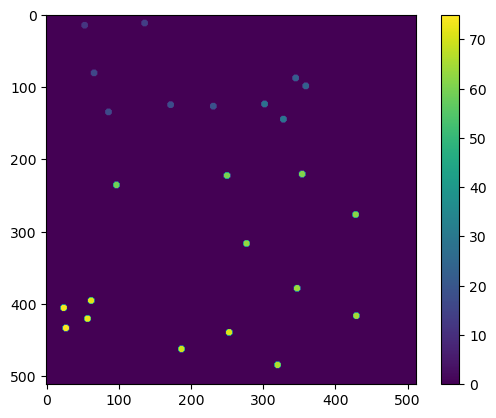

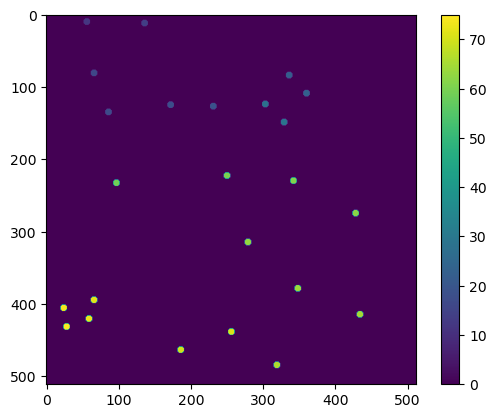

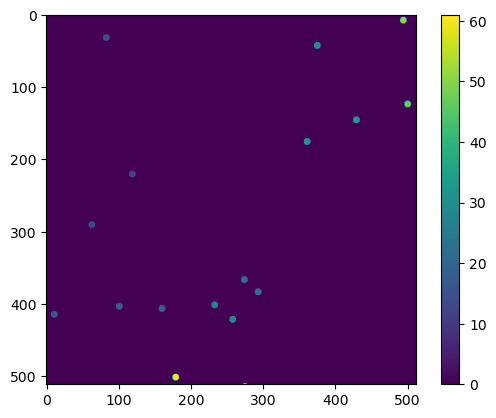

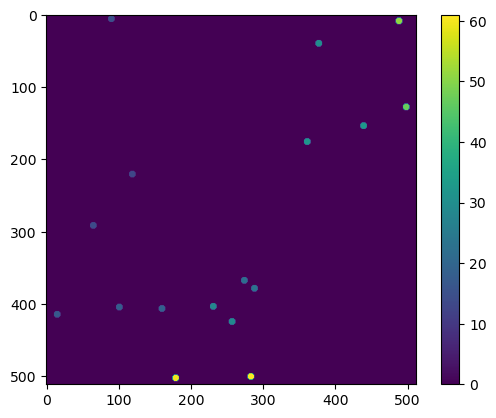

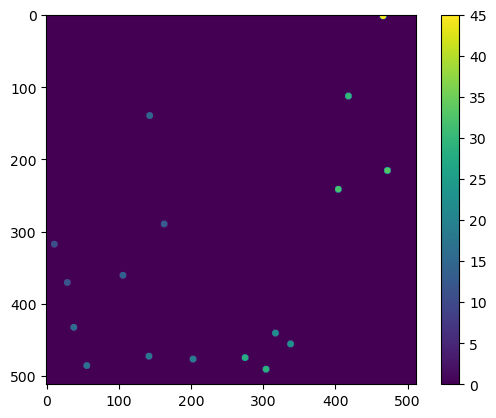

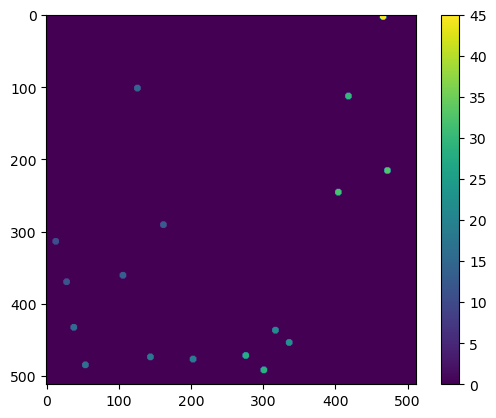

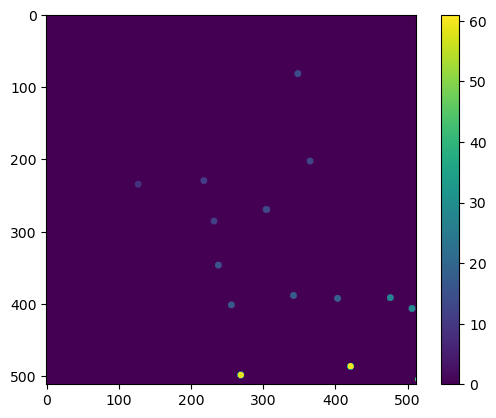

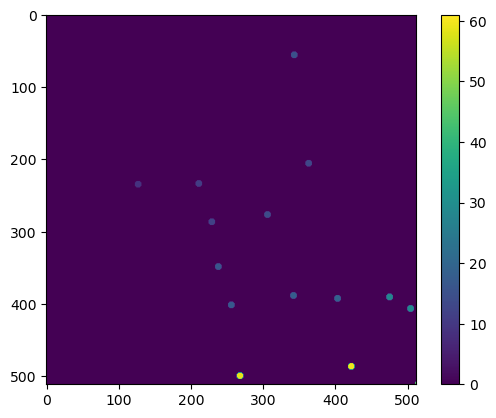

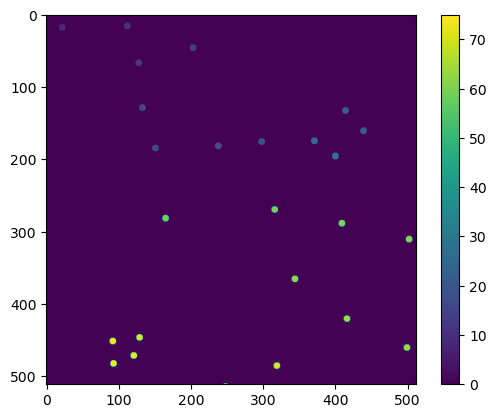

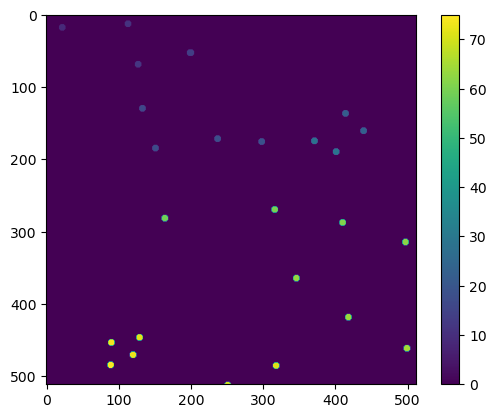

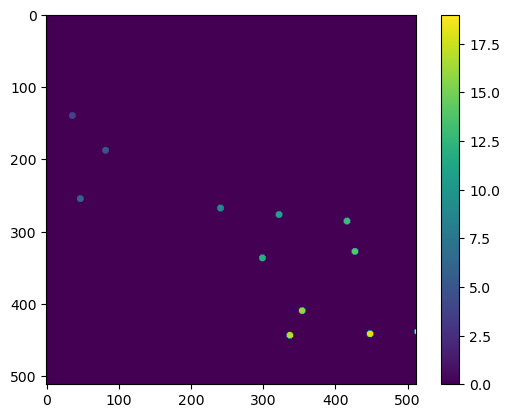

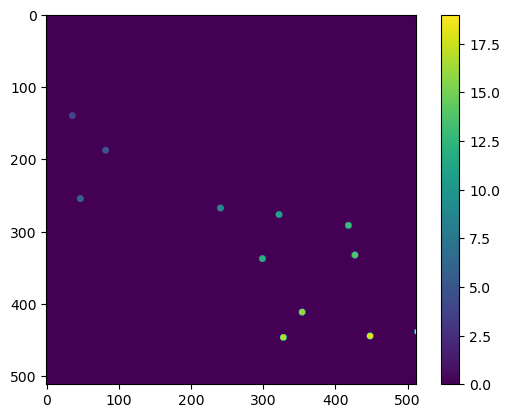

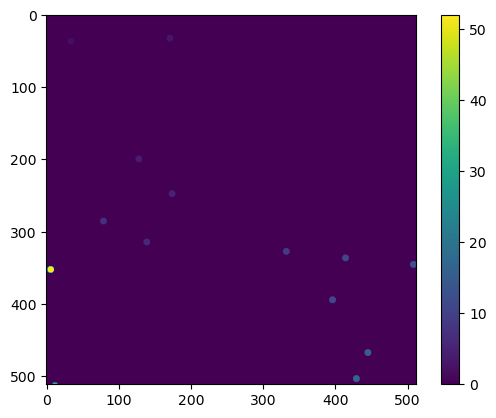

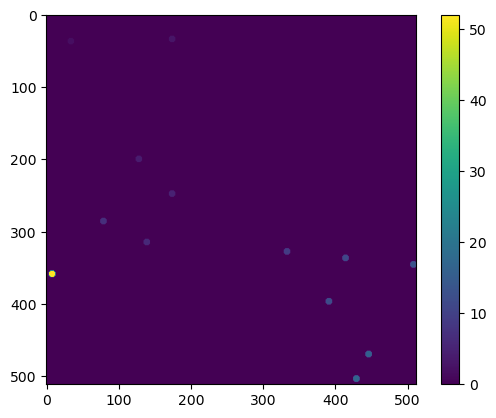

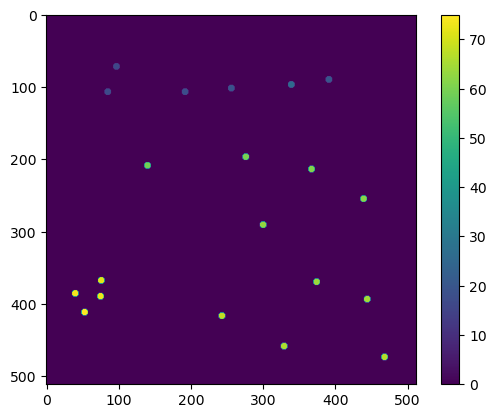

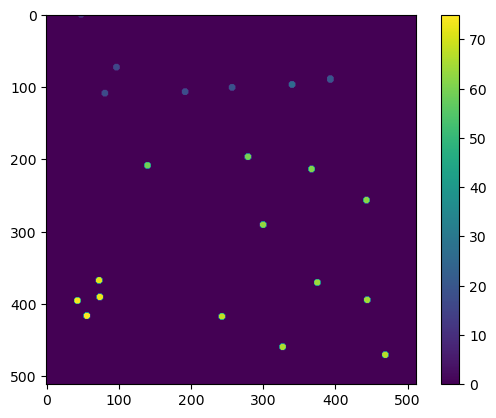

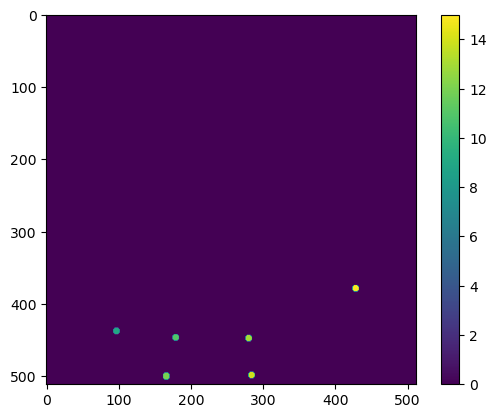

In [ ]:
path_X = ['/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01/',
          '/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/02/']
suff_X = 't' 


path_Y = ['/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/01_GT/TRA/',
          '/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/Fluo-C2DL-Huh7/02_GT/TRA/']
suff_Y='man_track'

prompt_a='hela_ctc, cell, microscopy image, grayscale'
prompt_b='fluo_ctc, cell, microscopy image, grayscale'

alt=[0,1,2,3]

l_ind=0

for k in range(len(path_X)):
    for h in range(len(alt)):
        if k < 2:
            prompt_ctc=prompt_a
        else:
            prompt_ctc=prompt_b
        l_ind=ctc_2_CNet_track(path_X[k],suff_X,path_Y[k],suff_Y,start_ind=l_ind,prompt=prompt_b,alt=alt[h])
        print(l_ind)
        


In [ ]:
in_path='/home/mo/Desktop/IWR/Cell_GT_Proj/red_dots'
out_path='/home/mo/Desktop/IWR/Cell_GT_Proj/CNet_cells_rd/'


red_dots2Cnet(in_path,out_path)

In [8]:
# Path to the image folder
image_folder = "/home/mo/Desktop/IWR/Cell_GT_Proj/image_log/val"

# Create a new folder for the combined images
output_folder = "/home/mo/Desktop/IWR/Cell_GT_Proj/image_log/assembled_val"
os.makedirs(output_folder, exist_ok=True)

# Get a list of all image files in the folder
image_files = [filename for filename in os.listdir(image_folder) if filename.endswith(".png")]

# Process each set of corresponding images
for image_file in image_files:
    # Extract the common identifier from the image filename
    identifier = image_file.split("_gs-", 1)[1].split(".")[0]

    # Construct the filenames of the three corresponding images
    samples_file = os.path.join(image_folder, f"samples_cfg_scale_9.00_gs-{identifier}.png")
    reconstruction_file = os.path.join(image_folder, f"reconstruction_gs-{identifier}.png")
    control_file = os.path.join(image_folder, f"control_gs-{identifier}.png")

    # Open the images
    samples_image = Image.open(samples_file)
    reconstruction_image = Image.open(reconstruction_file)
    control_image = Image.open(control_file)

    # Resize the images by half
    new_size = (samples_image.width // 2, samples_image.height // 2)
    samples_image = samples_image.resize(new_size)
    reconstruction_image = reconstruction_image.resize(new_size)
    control_image = control_image.resize(new_size)

    # Create a new image with the combined images
    combined_image = Image.new("RGB", (new_size[0], new_size[1] * 2))
    combined_image.paste(samples_image, (0, 0))
    #combined_image.paste(reconstruction_image, (0, new_size[1]))
    combined_image.paste(control_image, (0, new_size[1]))

    # Save the combined image in the output folder
    output_file = os.path.join(output_folder, f"combined_{identifier}.png")
    combined_image.save(output_file)

    # Print the saved file path
    print(f"Combined image saved: {output_file}")

OSError: image file is truncated